In [1]:
import numpy as np
import pandas as pd
import re
import torch
import torch.nn as nn
from transformers import BertTokenizer, BertModel, BertForSequenceClassification, Trainer, TrainingArguments
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report
from sklearn.metrics.pairwise import pairwise_distances
import matplotlib.pyplot as plt
import time
import wandb
import random

In [2]:
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
secret_value_0 = user_secrets.get_secret("wandb_key")

wandb.login(key=secret_value_0)

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [3]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

In [4]:
train_data = pd.read_csv('/kaggle/input/netifier/processed_train.csv', encoding='latin-1')
val_data = pd.read_csv('/kaggle/input/netifier/processed_test.csv', encoding='latin-1')

data = pd.concat([train_data, val_data], ignore_index=True)
data.shape

(7773, 7)

In [5]:
data.head()

,original_text,source,pornografi,sara,radikalisme,pencemaran_nama_baik,processed_text
0,[QUOTE=jessepinkman16;5a50ac34d89b093f368b456e...,kaskus,0,0,0,1,jabar memang provinsi barokah boleh juga dan n...
1,"@verosvante kita2 aja nitizen yang pada kepo,t...",instagram,0,0,0,0,kita saja nitizen yang pada penasaran toh kelu...
2,"""#SidangAhok smg sipenista agama n ateknya mat...",twitter,0,1,1,1,sidangahok semoga sipenista agama dan ateknya ...
3,@bolususulembang.jkt barusan baca undang2 ini....,instagram,0,0,0,0,jakarta barusan baca undang ini tetap dibedaka...
4,bikin anak mulu lu nof \nkaga mikir apa kasian...,kaskus,0,0,0,0,buat anak melulu kamu nof nkaga mikir apa kasi...


In [6]:
train_data, val_data = train_test_split(data, test_size=0.2, random_state=42, shuffle=False)

In [7]:
train_labels = train_data.columns[2:6]
val_labels = val_data.columns[2:6]

# Extract features and labels for training and validation
X_train = train_data['processed_text'].values
y_train = train_data[train_labels].values
X_val = val_data['processed_text'].values
y_val = val_data[val_labels].values

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

(6218,) (6218, 4)
(1555,) (1555, 4)


In [8]:
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from torch.utils.data import Dataset
import numpy as np
import torch

# Define custom Dataset class
class NetifierDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        labels = self.labels[idx]
        encoding = self.tokenizer(text, truncation=True, padding='max_length', max_length=self.max_length, return_tensors='pt')
        item = {key: val.squeeze() for key, val in encoding.items()}
        item['labels'] = torch.tensor(labels, dtype=torch.float)
        return item

# Initialize BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('indobenchmark/indobert-base-p1')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/229k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.53k [00:00<?, ?B/s]

In [9]:
# Define compute metrics for evaluation
def compute_metrics(p):
    preds = torch.sigmoid(torch.tensor(p.predictions)).round()  # Sigmoid and threshold for multi-label
    labels = torch.tensor(p.label_ids)
    
    accuracy = accuracy_score(labels, preds)

    # Standard multi-label precision, recall, and F1 metrics
    precision, recall, f1_micro, _ = precision_recall_fscore_support(labels, preds, average='micro', zero_division=0)
    a, b, f1_macro, _ = precision_recall_fscore_support(labels, preds, average='macro', zero_division=0)
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_micro': f1_micro,
        'f1_macro': f1_macro
    }

In [10]:
# Define compute metrics for evaluation
def compute_metrics_eval(p):
    result = compute_metrics(p)
    
    preds = torch.sigmoid(torch.tensor(p.predictions)).round()  # Sigmoid and threshold for multi-label
    labels = torch.tensor(p.label_ids)
    
    report = classification_report(
        labels, 
        preds, 
        target_names=['pornografi', 'sara', 'radikalisme', 'pencemaran_nama_baik'],
        zero_division=0
    )    
    return {
        'accuracy': result['accuracy'],
        'precision': result['precision'],
        'recall': result['recall'],
        'f1_micro': result['f1_micro'],
        'f1_macro': result['f1_macro'],
        'report': report
    }

# ACTIVE LEARNING LOOP

In [11]:
accuracies = []
f1_micros = []
f1_macros = []
sampling_dur = []
data_used = []

In [12]:
filename = 'netifier-coreset'
epochs = 10
total_data = len(X_train) + len(X_val)
initial_train_size = int(0.05 * total_data)
checkpoints = [
    int(0.5 * total_data), 
    int(0.6 * total_data), 
    int(0.7 * total_data),
    len(X_train)
]
min_increment = 200

In [13]:
def coreset_sampling(model, X_pool, train_indices, remaining_indices, trials, n_samples=min_increment):
    start_time = time.time()
    model.eval()  # Set the model to evaluation mode
    embeddings = []

    current_train_size = len(train_indices)

    dataset = NetifierDataset(X_pool, np.zeros((len(X_pool), 4)), tokenizer, max_length=128)
    dataloader = DataLoader(
        dataset,
        batch_size=16,
        num_workers=4,
        pin_memory=True,
    )
    
    with torch.no_grad():
        for data in dataloader:
            input_ids = data['input_ids'].to(device)
            attention_mask = data['attention_mask'].to(device)
            with torch.no_grad():
                outputs = model.base_model(input_ids=input_ids, attention_mask=attention_mask)
            hidden_states = outputs.last_hidden_state.mean(dim=1)  # Mean of hidden states for vector representation
            embeddings.append(hidden_states.cpu().numpy())

    embeddings = np.vstack(embeddings)
    embeddings = np.array(embeddings)

    # Use pairwise distances to compute a distance matrix for Coreset selection
    distance_matrix = pairwise_distances(embeddings)    
    selected_indices = [0]  # Start with an arbitrary first sample (e.g., index 0)
    
    # Calculate the minimum distance from selected points to all other points
    min_distances = distance_matrix[selected_indices].min(axis=0)
    sorted = np.argsort(min_distances)
    sorted = sorted[::-1]
    
    threshold = np.percentile(min_distances, 90)
    candidates = np.where(min_distances >= threshold)[0]  # Select the point farthest from the current set
    num_of_candidates = len(candidates)

    nearest_cp = 0
    for cp in checkpoints:
        if cp > current_train_size:
            nearest_cp = cp
            break

    if num_of_candidates <= n_samples and n_samples < nearest_cp - current_train_size:
        selected_indices = sorted[:n_samples]
    elif num_of_candidates > n_samples and num_of_candidates < nearest_cp - current_train_size:
        selected_indices = sorted[:num_of_candidates]
    else:
        selected_indices = sorted[:nearest_cp - current_train_size]

        temp = train_indices.copy()
        temp.extend(selected_indices)
        
        # Save acquired data up to checkpoint
        acquired_data = pd.DataFrame({
            'processed_text': [X_train[i] for i in temp],
            'pornografi': [y_train[i][0] for i in temp],
            'sara': [y_train[i][1] for i in temp],
            'radikalisme': [y_train[i][2] for i in temp],
            'pencemaran_nama_baik': [y_train[i][3] for i in temp],
        })

        acquired_data.to_csv(f'{filename}-{trials+1}-data-{nearest_cp}.csv', index=False)
    
    end_time = time.time()  # Record the end time
    duration = end_time - start_time  # Calculate the duration in seconds

    print("Nearest checkpoint:", nearest_cp)
    print("Threshold:", threshold)
    print("Samples above threshold:", num_of_candidates)
    print("Acquired samples:", len(selected_indices))
    print(f"Sampling duration: {duration} seconds")  # Print or return the runtime if needed

    sampling_dur.append(duration)
    
    return [remaining_indices[i] for i in selected_indices]

In [14]:
def train_model(current_train_size, train_indices, trials, seed):
    model = BertForSequenceClassification.from_pretrained(
        'indobenchmark/indobert-base-p1',
        num_labels=len(train_labels),
        problem_type="multi_label_classification"
    )
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    # Freeze the first few layers of the encoder
    for name, param in model.named_parameters():
        # Specify the layers you want to freeze (e.g., first 6 layers)
        if "encoder.layer" in name:
            # Extract the layer number safely
            layer_num = name.split(".")[3]
            try:
                # Freeze only the first 6 layers
                if int(layer_num) < 9:
                    param.requires_grad = False
            except ValueError:
                # Skip any parameter names that don’t follow the expected format
                continue
    
    # Create Dataset with current training data
    current_X_train = [X_train[i] for i in train_indices]
    current_y_train = [y_train[i] for i in train_indices]
    train_dataset = NetifierDataset(current_X_train, current_y_train, tokenizer, max_length=128)
    val_dataset = NetifierDataset(X_val, y_val, tokenizer, max_length=128)
    
    # Define training arguments
    training_args = TrainingArguments(
        output_dir=f'./results/{filename}-{trials+1}',
        eval_strategy="epoch",                    # Evaluate after every epoch
        save_strategy="epoch",                    # Save model after every epoch
        learning_rate=2e-5,
        per_device_train_batch_size=16,
        per_device_eval_batch_size=16,
        num_train_epochs=epochs,
        weight_decay=0.01,
        load_best_model_at_end=True,
        metric_for_best_model='f1_micro',
        save_total_limit=1,
        seed=seed
    )

    # Initialize Trainer
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        compute_metrics=compute_metrics
    )

    # Train the model
    trainer.train()

    # Evaluate after training
    trainer.compute_metrics = compute_metrics_eval
    eval_results = trainer.evaluate()
    print(f"Iteration {current_train_size}: Accuracy: {eval_results['eval_accuracy']}, F1 Micro: {eval_results['eval_f1_micro']}, F1 Macro: {eval_results['eval_f1_macro']}")
    print(eval_results['eval_report'])

    torch.save(model.state_dict(), f'{filename}-{trials+1}-model.pth')
    model.config.to_json_file(f'{filename}-{trials+1}-config.json')

    data_used.append(current_train_size)
    accuracies.append(eval_results['eval_accuracy'])
    f1_micros.append(eval_results['eval_f1_micro'])
    f1_macros.append(eval_results['eval_f1_macro'])
    
    return model, trainer

In [15]:
import matplotlib.pyplot as plt

def plot_result(data_used, accuracies, f1_micros, f1_macros):
    fig, axs = plt.subplots(1, 3, figsize=(21, 5))

    data_used = [round(data / total_data * 100, 1) for data in data_used]

    # Plot for Accuracy
    axs[0].plot(data_used, accuracies, label="Accuracy", color="blue")
    axs[0].set_xlabel("Percentage of data used")
    axs[0].set_title("Accuracy")
    axs[0].set_xticks(data_used)

    # Plot for F1 Micro
    axs[1].plot(data_used, f1_micros, label="F1 Micro", color="orange")
    axs[1].set_xlabel("Percentage of data used")
    axs[1].set_title("F1 Micro")
    axs[1].set_xticks(data_used)

    # Plot for F1 Macro
    axs[2].plot(data_used, f1_macros, label="F1 Macro", color="green")
    axs[2].set_xlabel("Percentage of data used")
    axs[2].set_title("F1 Macro")
    axs[2].set_xticks(data_used)

    # Adjust layout and show the plots
    plt.tight_layout()
    plt.show()

In [16]:
def active_learning(seed, i):
    accuracies.clear()
    f1_micros.clear()
    f1_macros.clear()
    sampling_dur.clear()
    data_used.clear()

    set_seed(seed)
    
    print("===============================================")
    print("TRIAL {}".format(i+1))
    print("Random seed:", seed)
    
    train_indices = np.random.choice(range(len(X_train)), initial_train_size, replace=False).tolist()
    remaining_indices = list(set(range(len(X_train))) - set(train_indices))
    
    current_train_size = initial_train_size
    
    start_time = time.time()
    while current_train_size < checkpoints[len(checkpoints) - 1]:
        model, trainer = train_model(current_train_size, train_indices, i, seed)
    
        # Perform query strategy to select new samples
        new_samples = coreset_sampling(
            model, 
            [X_train[i] for i in remaining_indices], 
            train_indices,
            remaining_indices,
            trials=i, 
        )
        train_indices.extend(new_samples)
        remaining_indices = list(set(remaining_indices) - set(new_samples))
    
        # Update current training size
        current_train_size = len(train_indices)
        print("New train size: {}".format(current_train_size))
    
    # Train last epoch
    model, trainer = train_model(current_train_size, train_indices, i, seed)
    
    end_time = time.time()
    duration = end_time - start_time  # Calculate the duration in seconds
    
    print(f"Total sampling time: {np.array(sampling_dur).sum().round(2)} seconds")
    print(f"Total runtime: {duration} seconds")
    
    plot_result(data_used, accuracies, f1_micros, f1_macros)
    
    results = pd.DataFrame({
        'Data Used': data_used,
        'Accuracy': accuracies,
        'F1 Micro': f1_micros,
        'F1 Macro': f1_macros,
    })
    sampling_dur.insert(0, 0)
    
    results['Sampling Duration'] = sampling_dur
    
    results.to_csv(f'{filename}-{i+1}-results.csv', index=False)

In [17]:
seeds = [50, 81, 14, 3, 94]

## RUN 1

TRIAL 1
Random seed: 50


pytorch_model.bin:   0%|          | 0.00/498M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Currently logged in as: nicost918 (nicost918-petra-christian-university). Use `wandb login --relogin` to force relogin
wandb: Tracking run with wandb version 0.18.3
wandb: Run data is saved locally in /kaggle/working/wandb/run-20241218_153537-m6slk8k4
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run ./results/netifier-coreset-1
wandb: ⭐️ View project at https://wandb.ai/nicost918-petra-christian-university/huggingface
wandb: 🚀 View run at https://w

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.471070,0.441801,0.722222,0.009804,0.019345,0.016121
2,No log,0.408955,0.549839,0.937743,0.181750,0.304485,0.212706
3,No log,0.356134,0.570418,0.760807,0.398190,0.522772,0.458811
4,No log,0.333005,0.578135,0.745169,0.465309,0.572888,0.519570
5,No log,0.328695,0.599357,0.754325,0.493213,0.596443,0.562729
6,No log,0.316878,0.602572,0.734064,0.555807,0.632618,0.600391
7,No log,0.322708,0.605788,0.756849,0.500000,0.602180,0.576849
8,No log,0.310757,0.618006,0.728030,0.593514,0.653926,0.632917
9,No log,0.310798,0.616720,0.731638,0.585973,0.650754,0.631457
10,No log,0.310642,0.616077,0.733840,0.582202,0.649285,0.630442


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.90      0.80      0.85       362
                sara       0.62      0.32      0.42       237
         radikalisme       0.69      0.66      0.68       235
pencemaran_nama_baik       0.64      0.54      0.59       492

           micro avg       0.73      0.59      0.65      1326
           macro avg       0.71      0.58      0.63      1326
        weighted avg       0.72      0.59      0.64      1326
         samples avg       0.35      0.33      0.33      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 388: Accuracy: 0.6180064308681672, F1 Micro: 0.653926049023681, F1 Macro: 0.6329171582051338
                      precision    recall  f1-score   support

          pornografi       0.90      0.80      0.85       362
                sara       0.62      0.32      0.42       237
         radikalisme       0.69      0.66      0.68       235
pencemaran_nama_baik       0.64      0.54      0.59       492

           micro avg       0.73      0.59      0.65      1326
           macro avg       0.71      0.58      0.63      1326
        weighted avg       0.72      0.59      0.64      1326
         samples avg       0.35      0.33      0.33      1326



/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 3886
Threshold: 24.41180419921875
Samples above threshold: 586
Acquired samples: 586
Sampling duration: 20.872732162475586 seconds
New train size: 974


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.378640,0.549839,0.817204,0.229261,0.358068,0.233581
2,No log,0.351685,0.553698,0.774545,0.321267,0.454158,0.367716
3,No log,0.319885,0.598071,0.739819,0.493213,0.591855,0.555624
4,No log,0.313941,0.619936,0.693910,0.653092,0.672883,0.662754
5,No log,0.307595,0.632797,0.699067,0.677979,0.688361,0.681140
6,No log,0.318404,0.633441,0.729148,0.613122,0.666120,0.649499
7,No log,0.329720,0.645016,0.705329,0.678733,0.691776,0.682861
8,No log,0.329551,0.641158,0.713259,0.673454,0.692785,0.681225
9,0.124600,0.328354,0.648232,0.720968,0.674208,0.696804,0.685067
10,0.124600,0.329444,0.648232,0.718650,0.674208,0.695720,0.685428


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.85      0.86      0.86       362
                sara       0.65      0.46      0.54       237
         radikalisme       0.69      0.73      0.71       235
pencemaran_nama_baik       0.66      0.61      0.63       492

           micro avg       0.72      0.67      0.70      1326
           macro avg       0.71      0.67      0.69      1326
        weighted avg       0.72      0.67      0.69      1326
         samples avg       0.38      0.38      0.37      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 974: Accuracy: 0.6482315112540193, F1 Micro: 0.6968043647700701, F1 Macro: 0.6850668023660791
                      precision    recall  f1-score   support

          pornografi       0.85      0.86      0.86       362
                sara       0.65      0.46      0.54       237
         radikalisme       0.69      0.73      0.71       235
pencemaran_nama_baik       0.66      0.61      0.63       492

           micro avg       0.72      0.67      0.70      1326
           macro avg       0.71      0.67      0.69      1326
        weighted avg       0.72      0.67      0.69      1326
         samples avg       0.38      0.38      0.37      1326



/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 3886
Threshold: 23.55172481536865
Samples above threshold: 525
Acquired samples: 525
Sampling duration: 18.46069598197937 seconds
New train size: 1499


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.376782,0.570418,0.848684,0.291855,0.434343,0.337575
2,No log,0.352304,0.610289,0.810321,0.438160,0.568771,0.490601
3,No log,0.299895,0.635370,0.752607,0.598793,0.666947,0.628067
4,No log,0.304544,0.636656,0.735573,0.644042,0.686771,0.650683
5,No log,0.318894,0.655305,0.736088,0.658371,0.695064,0.673255
6,0.121800,0.333350,0.648875,0.751144,0.619155,0.678793,0.653712
7,0.121800,0.338843,0.649518,0.732069,0.669683,0.699488,0.679486
8,0.121800,0.355337,0.645016,0.725103,0.664404,0.693428,0.675763
9,0.121800,0.353807,0.648232,0.714509,0.690799,0.702454,0.687873
10,0.121800,0.351412,0.644373,0.716680,0.677225,0.696394,0.678413


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.83      0.88      0.86       362
                sara       0.64      0.44      0.52       237
         radikalisme       0.68      0.77      0.73       235
pencemaran_nama_baik       0.66      0.63      0.65       492

           micro avg       0.71      0.69      0.70      1326
           macro avg       0.70      0.68      0.69      1326
        weighted avg       0.71      0.69      0.70      1326
         samples avg       0.40      0.40      0.39      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 1499: Accuracy: 0.6482315112540193, F1 Micro: 0.7024539877300614, F1 Macro: 0.6878734613246507
                      precision    recall  f1-score   support

          pornografi       0.83      0.88      0.86       362
                sara       0.64      0.44      0.52       237
         radikalisme       0.68      0.77      0.73       235
pencemaran_nama_baik       0.66      0.63      0.65       492

           micro avg       0.71      0.69      0.70      1326
           macro avg       0.70      0.68      0.69      1326
        weighted avg       0.71      0.69      0.70      1326
         samples avg       0.40      0.40      0.39      1326



/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 3886
Threshold: 23.170793533325195
Samples above threshold: 472
Acquired samples: 472
Sampling duration: 16.610580444335938 seconds
New train size: 1971


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.354153,0.581350,0.787682,0.366516,0.500257,0.399925
2,No log,0.297597,0.621865,0.711864,0.665158,0.687719,0.656271
3,No log,0.301218,0.643087,0.814159,0.555053,0.660090,0.582405
4,No log,0.296579,0.658521,0.761739,0.660633,0.707593,0.672763
5,0.139600,0.296239,0.663666,0.742089,0.707391,0.724324,0.702777
6,0.139600,0.313729,0.664309,0.740157,0.708899,0.724191,0.706729
7,0.139600,0.321348,0.668810,0.726379,0.724736,0.725557,0.713854
8,0.139600,0.338739,0.663666,0.742994,0.699849,0.720777,0.699600
9,0.045800,0.343032,0.663023,0.731878,0.708145,0.719816,0.702492
10,0.045800,0.344609,0.662379,0.729457,0.709653,0.719419,0.701761


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.89      0.86      0.88       362
                sara       0.63      0.49      0.55       237
         radikalisme       0.68      0.81      0.74       235
pencemaran_nama_baik       0.67      0.69      0.68       492

           micro avg       0.73      0.72      0.73      1326
           macro avg       0.72      0.72      0.71      1326
        weighted avg       0.73      0.72      0.72      1326
         samples avg       0.41      0.41      0.40      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 1971: Accuracy: 0.6688102893890675, F1 Micro: 0.7255568138920347, F1 Macro: 0.7138540517118874
                      precision    recall  f1-score   support

          pornografi       0.89      0.86      0.88       362
                sara       0.63      0.49      0.55       237
         radikalisme       0.68      0.81      0.74       235
pencemaran_nama_baik       0.67      0.69      0.68       492

           micro avg       0.73      0.72      0.73      1326
           macro avg       0.72      0.72      0.71      1326
        weighted avg       0.73      0.72      0.72      1326
         samples avg       0.41      0.41      0.40      1326



/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 3886
Threshold: 22.105390548706055
Samples above threshold: 425
Acquired samples: 425
Sampling duration: 14.921244144439697 seconds
New train size: 2396


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.341568,0.591640,0.848987,0.347662,0.493312,0.400112
2,No log,0.281256,0.656592,0.807609,0.560332,0.661621,0.604685
3,No log,0.269314,0.670740,0.760033,0.699849,0.728700,0.700744
4,0.153000,0.286633,0.679743,0.782798,0.679487,0.727493,0.690239
5,0.153000,0.291462,0.677814,0.756735,0.720211,0.738022,0.716215
6,0.153000,0.304747,0.676527,0.768333,0.695324,0.730008,0.700119
7,0.057000,0.321292,0.680386,0.744240,0.730769,0.737443,0.720736
8,0.057000,0.327829,0.681672,0.732456,0.755656,0.743875,0.732479
9,0.057000,0.336917,0.684244,0.727666,0.761689,0.744289,0.735290
10,0.030100,0.339169,0.678457,0.730205,0.751131,0.740520,0.727993


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.91      0.88      0.90       362
                sara       0.65      0.54      0.59       237
         radikalisme       0.69      0.83      0.75       235
pencemaran_nama_baik       0.66      0.75      0.70       492

           micro avg       0.73      0.76      0.74      1326
           macro avg       0.73      0.75      0.74      1326
        weighted avg       0.73      0.76      0.74      1326
         samples avg       0.43      0.43      0.42      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 2396: Accuracy: 0.6842443729903537, F1 Micro: 0.7442888725128961, F1 Macro: 0.7352903153543142
                      precision    recall  f1-score   support

          pornografi       0.91      0.88      0.90       362
                sara       0.65      0.54      0.59       237
         radikalisme       0.69      0.83      0.75       235
pencemaran_nama_baik       0.66      0.75      0.70       492

           micro avg       0.73      0.76      0.74      1326
           macro avg       0.73      0.75      0.74      1326
        weighted avg       0.73      0.76      0.74      1326
         samples avg       0.43      0.43      0.42      1326



/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 3886
Threshold: 21.992998313903808
Samples above threshold: 383
Acquired samples: 383
Sampling duration: 13.380363941192627 seconds
New train size: 2779


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.338139,0.592283,0.826758,0.363499,0.504976,0.400632
2,No log,0.263704,0.654662,0.784259,0.638763,0.704073,0.639076
3,0.167600,0.264631,0.686174,0.803704,0.654600,0.721530,0.681743
4,0.167600,0.276430,0.679743,0.773950,0.694570,0.732114,0.702400
5,0.167600,0.308147,0.654662,0.703830,0.776018,0.738164,0.717420
6,0.070800,0.301405,0.689389,0.723944,0.775264,0.748725,0.738934
7,0.070800,0.307719,0.684887,0.736881,0.751885,0.744308,0.733473
8,0.070800,0.321447,0.685531,0.728959,0.770739,0.749267,0.737489
9,0.040000,0.332130,0.682315,0.722772,0.770739,0.745985,0.733886
10,0.040000,0.330192,0.682958,0.735099,0.753394,0.744134,0.728145


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.93      0.87      0.90       362
                sara       0.66      0.52      0.58       237
         radikalisme       0.68      0.83      0.75       235
pencemaran_nama_baik       0.66      0.78      0.72       492

           micro avg       0.73      0.77      0.75      1326
           macro avg       0.73      0.75      0.74      1326
        weighted avg       0.74      0.77      0.75      1326
         samples avg       0.44      0.44      0.43      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 2779: Accuracy: 0.6855305466237942, F1 Micro: 0.749266862170088, F1 Macro: 0.7374888628664577
                      precision    recall  f1-score   support

          pornografi       0.93      0.87      0.90       362
                sara       0.66      0.52      0.58       237
         radikalisme       0.68      0.83      0.75       235
pencemaran_nama_baik       0.66      0.78      0.72       492

           micro avg       0.73      0.77      0.75      1326
           macro avg       0.73      0.75      0.74      1326
        weighted avg       0.74      0.77      0.75      1326
         samples avg       0.44      0.44      0.43      1326



/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 3886
Threshold: 20.774326705932616
Samples above threshold: 344
Acquired samples: 344
Sampling duration: 12.045804023742676 seconds
New train size: 3123


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.340380,0.591640,0.862782,0.346154,0.494080,0.399829
2,No log,0.258342,0.683601,0.765574,0.704374,0.733700,0.702160
3,0.183200,0.267155,0.681029,0.783595,0.677225,0.726537,0.705283
4,0.183200,0.266957,0.686817,0.762579,0.731523,0.746728,0.726454
5,0.183200,0.291780,0.679100,0.754137,0.721719,0.737572,0.711745
6,0.083700,0.300816,0.691318,0.743436,0.747360,0.745393,0.736068
7,0.083700,0.331441,0.677814,0.732695,0.750377,0.741431,0.730274
8,0.046800,0.332409,0.674598,0.724163,0.750377,0.737037,0.725892
9,0.046800,0.340375,0.672669,0.720029,0.756410,0.737771,0.730856
10,0.046800,0.347310,0.673312,0.718460,0.760181,0.738732,0.730951


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.91      0.88      0.90       362
                sara       0.71      0.44      0.55       237
         radikalisme       0.72      0.77      0.74       235
pencemaran_nama_baik       0.70      0.74      0.72       492

           micro avg       0.76      0.73      0.75      1326
           macro avg       0.76      0.71      0.73      1326
        weighted avg       0.76      0.73      0.74      1326
         samples avg       0.43      0.42      0.42      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 3123: Accuracy: 0.6868167202572347, F1 Micro: 0.7467282525019244, F1 Macro: 0.7264539960342551
                      precision    recall  f1-score   support

          pornografi       0.91      0.88      0.90       362
                sara       0.71      0.44      0.55       237
         radikalisme       0.72      0.77      0.74       235
pencemaran_nama_baik       0.70      0.74      0.72       492

           micro avg       0.76      0.73      0.75      1326
           macro avg       0.76      0.71      0.73      1326
        weighted avg       0.76      0.73      0.74      1326
         samples avg       0.43      0.42      0.42      1326



/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 3886
Threshold: 21.031661987304688
Samples above threshold: 355
Acquired samples: 355
Sampling duration: 10.866553783416748 seconds
New train size: 3478


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.323371,0.625080,0.879397,0.395928,0.546022,0.456980
2,No log,0.254917,0.690032,0.796931,0.665913,0.725555,0.696203
3,0.185400,0.255598,0.690032,0.767701,0.727753,0.747193,0.720292
4,0.185400,0.269783,0.700322,0.781046,0.720965,0.749804,0.735722
5,0.091500,0.288355,0.694534,0.769231,0.739065,0.753846,0.739381
6,0.091500,0.326252,0.662379,0.711724,0.778281,0.743516,0.732967
7,0.053400,0.314092,0.696463,0.759358,0.749623,0.754459,0.741661
8,0.053400,0.331735,0.690675,0.749441,0.757919,0.753656,0.739254
9,0.053400,0.343027,0.679100,0.728754,0.776018,0.751644,0.741888
10,0.035900,0.341391,0.682958,0.732666,0.773002,0.752294,0.743979


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.91      0.90      0.90       362
                sara       0.68      0.53      0.60       237
         radikalisme       0.71      0.80      0.76       235
pencemaran_nama_baik       0.71      0.72      0.71       492

           micro avg       0.76      0.75      0.75      1326
           macro avg       0.75      0.74      0.74      1326
        weighted avg       0.76      0.75      0.75      1326
         samples avg       0.43      0.43      0.42      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 3478: Accuracy: 0.6964630225080386, F1 Micro: 0.7544592030360532, F1 Macro: 0.7416608180293991
                      precision    recall  f1-score   support

          pornografi       0.91      0.90      0.90       362
                sara       0.68      0.53      0.60       237
         radikalisme       0.71      0.80      0.76       235
pencemaran_nama_baik       0.71      0.72      0.71       492

           micro avg       0.76      0.75      0.75      1326
           macro avg       0.75      0.74      0.74      1326
        weighted avg       0.76      0.75      0.75      1326
         samples avg       0.43      0.43      0.42      1326



/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 3886
Threshold: 20.25936164855957
Samples above threshold: 274
Acquired samples: 274
Sampling duration: 9.554830312728882 seconds
New train size: 3752


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.322521,0.621222,0.876847,0.402715,0.551938,0.465562
2,No log,0.247010,0.693891,0.813197,0.659879,0.728560,0.693842
3,0.199900,0.253242,0.693891,0.750185,0.763198,0.756636,0.738730
4,0.199900,0.267115,0.699678,0.756098,0.771493,0.763718,0.755394
5,0.104600,0.285504,0.697749,0.756594,0.757164,0.756879,0.747974
6,0.104600,0.306054,0.685531,0.739478,0.768477,0.753698,0.744925
7,0.061900,0.330904,0.691961,0.725530,0.799397,0.760675,0.757990
8,0.061900,0.350852,0.682315,0.710700,0.811463,0.757746,0.754367
9,0.041400,0.357340,0.677814,0.709441,0.804676,0.754064,0.749041
10,0.041400,0.350748,0.684887,0.722683,0.788084,0.753968,0.748767


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.91      0.90      0.90       362
                sara       0.68      0.59      0.63       237
         radikalisme       0.72      0.82      0.76       235
pencemaran_nama_baik       0.70      0.75      0.72       492

           micro avg       0.76      0.77      0.76      1326
           macro avg       0.75      0.76      0.76      1326
        weighted avg       0.76      0.77      0.76      1326
         samples avg       0.44      0.44      0.43      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 3752: Accuracy: 0.6996784565916399, F1 Micro: 0.7637178051511757, F1 Macro: 0.7553942778248396
                      precision    recall  f1-score   support

          pornografi       0.91      0.90      0.90       362
                sara       0.68      0.59      0.63       237
         radikalisme       0.72      0.82      0.76       235
pencemaran_nama_baik       0.70      0.75      0.72       492

           micro avg       0.76      0.77      0.76      1326
           macro avg       0.75      0.76      0.76      1326
        weighted avg       0.76      0.77      0.76      1326
         samples avg       0.44      0.44      0.43      1326



/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 3886
Threshold: 19.90263080596924
Samples above threshold: 247
Acquired samples: 134
Sampling duration: 8.79787802696228 seconds
New train size: 3886


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.289579,0.629582,0.844384,0.470588,0.604358,0.523087
2,No log,0.245495,0.703537,0.736842,0.791855,0.763359,0.754121
3,0.208000,0.260208,0.695177,0.723376,0.814480,0.766229,0.763164
4,0.208000,0.268700,0.698392,0.750183,0.774510,0.762152,0.753582
5,0.110200,0.287371,0.700322,0.740113,0.790347,0.764406,0.758835
6,0.110200,0.309398,0.691961,0.728149,0.797888,0.761425,0.754772
7,0.069200,0.315701,0.700322,0.739313,0.795626,0.766437,0.760231
8,0.069200,0.327316,0.696463,0.731063,0.793363,0.760940,0.753660
9,0.046700,0.341402,0.697106,0.728344,0.792609,0.759119,0.751387
10,0.046700,0.342833,0.698392,0.730345,0.798643,0.762968,0.758117


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.92      0.90      0.91       362
                sara       0.67      0.62      0.64       237
         radikalisme       0.71      0.83      0.76       235
pencemaran_nama_baik       0.67      0.79      0.73       492

           micro avg       0.74      0.80      0.77      1326
           macro avg       0.74      0.78      0.76      1326
        weighted avg       0.75      0.80      0.77      1326
         samples avg       0.45      0.45      0.44      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 3886: Accuracy: 0.7003215434083602, F1 Micro: 0.7664366146022521, F1 Macro: 0.7602310738850628
                      precision    recall  f1-score   support

          pornografi       0.92      0.90      0.91       362
                sara       0.67      0.62      0.64       237
         radikalisme       0.71      0.83      0.76       235
pencemaran_nama_baik       0.67      0.79      0.73       492

           micro avg       0.74      0.80      0.77      1326
           macro avg       0.74      0.78      0.76      1326
        weighted avg       0.75      0.80      0.77      1326
         samples avg       0.45      0.45      0.44      1326



/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 4663
Threshold: 19.653493118286132
Samples above threshold: 234
Acquired samples: 234
Sampling duration: 8.245853662490845 seconds
New train size: 4120


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.279991,0.654019,0.814433,0.536199,0.646658,0.606643
2,0.222400,0.238325,0.693891,0.772182,0.728507,0.749709,0.728603
3,0.222400,0.250158,0.698392,0.820728,0.662896,0.733417,0.700383
4,0.125500,0.251743,0.700322,0.784202,0.726244,0.754111,0.730988
5,0.125500,0.268216,0.706752,0.753813,0.782805,0.768036,0.758013
6,0.083800,0.296683,0.696463,0.732278,0.802413,0.765743,0.760668
7,0.083800,0.305695,0.708039,0.745965,0.801659,0.772810,0.767617
8,0.055500,0.321061,0.696463,0.737395,0.794118,0.764706,0.757722
9,0.055500,0.319923,0.700965,0.748014,0.781297,0.764294,0.757752
10,0.040200,0.323461,0.700322,0.745000,0.786576,0.765224,0.758745


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.91      0.90      0.91       362
                sara       0.65      0.68      0.66       237
         radikalisme       0.72      0.83      0.77       235
pencemaran_nama_baik       0.70      0.77      0.73       492

           micro avg       0.75      0.80      0.77      1326
           macro avg       0.74      0.80      0.77      1326
        weighted avg       0.75      0.80      0.77      1326
         samples avg       0.45      0.45      0.44      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 4120: Accuracy: 0.7080385852090032, F1 Micro: 0.772809887313704, F1 Macro: 0.7676165058333231
                      precision    recall  f1-score   support

          pornografi       0.91      0.90      0.91       362
                sara       0.65      0.68      0.66       237
         radikalisme       0.72      0.83      0.77       235
pencemaran_nama_baik       0.70      0.77      0.73       492

           micro avg       0.75      0.80      0.77      1326
           macro avg       0.74      0.80      0.77      1326
        weighted avg       0.75      0.80      0.77      1326
         samples avg       0.45      0.45      0.44      1326



/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 4663
Threshold: 19.414354705810545
Samples above threshold: 210
Acquired samples: 210
Sampling duration: 7.409613132476807 seconds
New train size: 4330


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.273988,0.668810,0.745951,0.659879,0.700280,0.696673
2,0.234300,0.254383,0.681029,0.704689,0.838612,0.765840,0.762242
3,0.234300,0.242981,0.702894,0.763001,0.774510,0.768713,0.758498
4,0.137400,0.256496,0.706752,0.740766,0.816742,0.776901,0.775237
5,0.137400,0.292353,0.683601,0.714005,0.822775,0.764541,0.758676
6,0.092400,0.291782,0.705466,0.748747,0.788839,0.768270,0.761644
7,0.092400,0.304270,0.695177,0.734483,0.803167,0.767291,0.762888
8,0.063200,0.312133,0.704180,0.755589,0.764706,0.760120,0.754430
9,0.063200,0.327973,0.694534,0.736620,0.788839,0.761835,0.756078
10,0.045800,0.320982,0.699035,0.748542,0.774510,0.761305,0.755946


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.94      0.88      0.91       362
                sara       0.63      0.74      0.68       237
         radikalisme       0.71      0.85      0.77       235
pencemaran_nama_baik       0.69      0.79      0.74       492

           micro avg       0.74      0.82      0.78      1326
           macro avg       0.74      0.81      0.78      1326
        weighted avg       0.75      0.82      0.78      1326
         samples avg       0.45      0.46      0.45      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 4330: Accuracy: 0.7067524115755627, F1 Micro: 0.7769010043041606, F1 Macro: 0.7752368754164619
                      precision    recall  f1-score   support

          pornografi       0.94      0.88      0.91       362
                sara       0.63      0.74      0.68       237
         radikalisme       0.71      0.85      0.77       235
pencemaran_nama_baik       0.69      0.79      0.74       492

           micro avg       0.74      0.82      0.78      1326
           macro avg       0.74      0.81      0.78      1326
        weighted avg       0.75      0.82      0.78      1326
         samples avg       0.45      0.46      0.45      1326



/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 4663
Threshold: 18.727344703674316
Samples above threshold: 189
Acquired samples: 200
Sampling duration: 6.647526264190674 seconds
New train size: 4530


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.262757,0.663666,0.806256,0.602564,0.689685,0.669360
2,0.240000,0.245572,0.689389,0.786575,0.689291,0.734727,0.723016
3,0.240000,0.237951,0.699678,0.758982,0.764706,0.761833,0.750967
4,0.144400,0.252923,0.699678,0.738112,0.807692,0.771336,0.764569
5,0.144400,0.269744,0.702894,0.739160,0.809955,0.772940,0.768620
6,0.101000,0.281173,0.704180,0.749286,0.791101,0.769626,0.765624
7,0.101000,0.314993,0.691961,0.724161,0.813725,0.766335,0.762336
8,0.068200,0.316721,0.699678,0.748368,0.778281,0.763031,0.755000
9,0.049800,0.331275,0.703537,0.741152,0.805430,0.771955,0.766217
10,0.049800,0.323274,0.704823,0.750181,0.783560,0.766507,0.760492


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.93      0.89      0.91       362
                sara       0.63      0.68      0.65       237
         radikalisme       0.73      0.83      0.77       235
pencemaran_nama_baik       0.68      0.81      0.74       492

           micro avg       0.74      0.81      0.77      1326
           macro avg       0.74      0.80      0.77      1326
        weighted avg       0.75      0.81      0.78      1326
         samples avg       0.46      0.46      0.45      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 4530: Accuracy: 0.7028938906752411, F1 Micro: 0.7729399064411658, F1 Macro: 0.7686195450817634
                      precision    recall  f1-score   support

          pornografi       0.93      0.89      0.91       362
                sara       0.63      0.68      0.65       237
         radikalisme       0.73      0.83      0.77       235
pencemaran_nama_baik       0.68      0.81      0.74       492

           micro avg       0.74      0.81      0.77      1326
           macro avg       0.74      0.80      0.77      1326
        weighted avg       0.75      0.81      0.78      1326
         samples avg       0.46      0.46      0.45      1326



/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 4663
Threshold: 18.82966194152832
Samples above threshold: 169
Acquired samples: 133
Sampling duration: 6.135111093521118 seconds
New train size: 4663


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.271935,0.658521,0.808102,0.571644,0.669611,0.636810
2,0.245000,0.239276,0.699678,0.743697,0.800905,0.771242,0.760429
3,0.245000,0.234586,0.708039,0.763353,0.776018,0.769634,0.760516
4,0.146600,0.248019,0.713826,0.761421,0.791855,0.776340,0.769065
5,0.146600,0.284166,0.694534,0.717067,0.833333,0.770841,0.765811
6,0.106000,0.287718,0.708039,0.743094,0.811463,0.775775,0.771043
7,0.072900,0.311334,0.701608,0.730487,0.825792,0.775221,0.767208
8,0.072900,0.306462,0.711897,0.751401,0.809201,0.779230,0.774372
9,0.052500,0.309316,0.712540,0.765832,0.784314,0.774963,0.769296
10,0.052500,0.315398,0.709325,0.756272,0.795626,0.775450,0.769616


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.93      0.91      0.92       362
                sara       0.64      0.67      0.65       237
         radikalisme       0.74      0.84      0.79       235
pencemaran_nama_baik       0.70      0.79      0.74       492

           micro avg       0.75      0.81      0.78      1326
           macro avg       0.75      0.80      0.77      1326
        weighted avg       0.76      0.81      0.78      1326
         samples avg       0.46      0.46      0.45      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 4663: Accuracy: 0.7118971061093248, F1 Micro: 0.7792302106027597, F1 Macro: 0.7743721042654346
                      precision    recall  f1-score   support

          pornografi       0.93      0.91      0.92       362
                sara       0.64      0.67      0.65       237
         radikalisme       0.74      0.84      0.79       235
pencemaran_nama_baik       0.70      0.79      0.74       492

           micro avg       0.75      0.81      0.78      1326
           macro avg       0.75      0.80      0.77      1326
        weighted avg       0.76      0.81      0.78      1326
         samples avg       0.46      0.46      0.45      1326



/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 5441
Threshold: 19.09109573364258
Samples above threshold: 156
Acquired samples: 200
Sampling duration: 5.550132751464844 seconds
New train size: 4863


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.256302,0.690032,0.785072,0.658371,0.716161,0.710833
2,0.252300,0.239447,0.711897,0.774648,0.746606,0.760369,0.754596
3,0.252300,0.234200,0.708039,0.801160,0.729261,0.763522,0.745809
4,0.157400,0.253487,0.700322,0.742361,0.806184,0.772957,0.767559
5,0.114200,0.271283,0.694534,0.742477,0.800151,0.770236,0.762290
6,0.114200,0.289607,0.700322,0.735875,0.815234,0.773524,0.765931
7,0.077700,0.300097,0.711254,0.748933,0.794118,0.770864,0.764032
8,0.077700,0.315603,0.706752,0.742138,0.800905,0.770403,0.763120
9,0.060300,0.322561,0.711897,0.750353,0.802413,0.775510,0.767858
10,0.045900,0.324251,0.709968,0.749474,0.805430,0.776445,0.770180


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.95      0.90      0.93       362
                sara       0.63      0.65      0.64       237
         radikalisme       0.73      0.83      0.77       235
pencemaran_nama_baik       0.69      0.80      0.74       492

           micro avg       0.75      0.81      0.78      1326
           macro avg       0.75      0.79      0.77      1326
        weighted avg       0.76      0.81      0.78      1326
         samples avg       0.46      0.46      0.45      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 4863: Accuracy: 0.7099678456591639, F1 Micro: 0.7764449291166847, F1 Macro: 0.7701799739232943
                      precision    recall  f1-score   support

          pornografi       0.95      0.90      0.93       362
                sara       0.63      0.65      0.64       237
         radikalisme       0.73      0.83      0.77       235
pencemaran_nama_baik       0.69      0.80      0.74       492

           micro avg       0.75      0.81      0.78      1326
           macro avg       0.75      0.79      0.77      1326
        weighted avg       0.76      0.81      0.78      1326
         samples avg       0.46      0.46      0.45      1326



/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 5441
Threshold: 19.344175338745117
Samples above threshold: 136
Acquired samples: 200
Sampling duration: 4.892844200134277 seconds
New train size: 5063


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.252536,0.696463,0.785464,0.676471,0.726904,0.714398
2,0.256600,0.234101,0.704823,0.795282,0.711916,0.751293,0.731685
3,0.256600,0.229473,0.722186,0.786719,0.759427,0.772832,0.763613
4,0.165500,0.240586,0.717685,0.775019,0.776772,0.775895,0.767573
5,0.121600,0.263122,0.714469,0.755175,0.797888,0.775944,0.769542
6,0.121600,0.293045,0.705466,0.731132,0.818250,0.772242,0.765527
7,0.086500,0.283933,0.722830,0.780195,0.784314,0.782249,0.773809
8,0.063900,0.298411,0.719614,0.781583,0.774510,0.778030,0.770809
9,0.063900,0.309077,0.709325,0.759913,0.794872,0.777000,0.771967
10,0.051400,0.317313,0.704180,0.747710,0.800151,0.773042,0.767786


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.94      0.89      0.92       362
                sara       0.66      0.65      0.65       237
         radikalisme       0.75      0.80      0.77       235
pencemaran_nama_baik       0.74      0.76      0.75       492

           micro avg       0.78      0.78      0.78      1326
           macro avg       0.77      0.78      0.77      1326
        weighted avg       0.78      0.78      0.78      1326
         samples avg       0.46      0.45      0.44      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 5063: Accuracy: 0.7228295819935692, F1 Micro: 0.7822489657766077, F1 Macro: 0.773808744113816
                      precision    recall  f1-score   support

          pornografi       0.94      0.89      0.92       362
                sara       0.66      0.65      0.65       237
         radikalisme       0.75      0.80      0.77       235
pencemaran_nama_baik       0.74      0.76      0.75       492

           micro avg       0.78      0.78      0.78      1326
           macro avg       0.77      0.78      0.77      1326
        weighted avg       0.78      0.78      0.78      1326
         samples avg       0.46      0.45      0.44      1326



/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 5441
Threshold: 18.381642150878907
Samples above threshold: 116
Acquired samples: 200
Sampling duration: 4.18235182762146 seconds
New train size: 5263


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.249562,0.698392,0.764107,0.735294,0.749424,0.736629
2,0.264900,0.236059,0.697749,0.798291,0.704374,0.748397,0.734654
3,0.264900,0.236907,0.721543,0.753338,0.808446,0.779920,0.774721
4,0.178800,0.258683,0.711254,0.726740,0.842383,0.780300,0.778089
5,0.127100,0.270272,0.708682,0.745455,0.803922,0.773585,0.766989
6,0.127100,0.274767,0.709325,0.761248,0.791101,0.775888,0.769362
7,0.092900,0.295714,0.704823,0.738621,0.807692,0.771614,0.765663
8,0.071200,0.306019,0.713826,0.747346,0.796380,0.771084,0.765586
9,0.071200,0.309801,0.714469,0.758671,0.791855,0.774908,0.769810
10,0.054500,0.314067,0.715756,0.756602,0.799397,0.777411,0.772761


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.93      0.89      0.91       362
                sara       0.60      0.76      0.67       237
         radikalisme       0.72      0.85      0.78       235
pencemaran_nama_baik       0.68      0.84      0.75       492

           micro avg       0.73      0.84      0.78      1326
           macro avg       0.73      0.84      0.78      1326
        weighted avg       0.74      0.84      0.79      1326
         samples avg       0.46      0.48      0.46      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 5263: Accuracy: 0.7112540192926045, F1 Micro: 0.7803003842123647, F1 Macro: 0.7780892165289606
                      precision    recall  f1-score   support

          pornografi       0.93      0.89      0.91       362
                sara       0.60      0.76      0.67       237
         radikalisme       0.72      0.85      0.78       235
pencemaran_nama_baik       0.68      0.84      0.75       492

           micro avg       0.73      0.84      0.78      1326
           macro avg       0.73      0.84      0.78      1326
        weighted avg       0.74      0.84      0.79      1326
         samples avg       0.46      0.48      0.46      1326



/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 5441
Threshold: 17.609204483032226
Samples above threshold: 96
Acquired samples: 178
Sampling duration: 3.7035036087036133 seconds
New train size: 5441


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.250522,0.698392,0.796580,0.667421,0.726303,0.717765
2,0.265600,0.228089,0.709968,0.752320,0.794872,0.773011,0.762351
3,0.180400,0.228425,0.708039,0.761172,0.783560,0.772204,0.763238
4,0.180400,0.261979,0.705466,0.720989,0.857466,0.783328,0.779818
5,0.130500,0.251794,0.719614,0.809801,0.735294,0.770751,0.759221
6,0.094600,0.287773,0.706109,0.729801,0.831071,0.777151,0.773163
7,0.094600,0.288931,0.720900,0.765557,0.797888,0.781388,0.771044
8,0.074300,0.302028,0.715756,0.747398,0.812217,0.778460,0.772999
9,0.055300,0.302637,0.721543,0.782209,0.769231,0.775665,0.767310
10,0.055300,0.308158,0.718971,0.766300,0.788839,0.777406,0.772514


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.91      0.91      0.91       362
                sara       0.59      0.78      0.67       237
         radikalisme       0.71      0.86      0.78       235
pencemaran_nama_baik       0.68      0.85      0.76       492

           micro avg       0.72      0.86      0.78      1326
           macro avg       0.72      0.85      0.78      1326
        weighted avg       0.73      0.86      0.79      1326
         samples avg       0.47      0.49      0.47      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 5441: Accuracy: 0.7054662379421222, F1 Micro: 0.7833275921460557, F1 Macro: 0.7798175442366313
                      precision    recall  f1-score   support

          pornografi       0.91      0.91      0.91       362
                sara       0.59      0.78      0.67       237
         radikalisme       0.71      0.86      0.78       235
pencemaran_nama_baik       0.68      0.85      0.76       492

           micro avg       0.72      0.86      0.78      1326
           macro avg       0.72      0.85      0.78      1326
        weighted avg       0.73      0.86      0.79      1326
         samples avg       0.47      0.49      0.47      1326



/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 6218
Threshold: 16.9408935546875
Samples above threshold: 78
Acquired samples: 200
Sampling duration: 2.8961565494537354 seconds
New train size: 5641


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.257136,0.674598,0.847778,0.575415,0.685535,0.660217
2,0.274600,0.229881,0.708039,0.791426,0.723982,0.756203,0.735899
3,0.180800,0.221247,0.721543,0.768437,0.785822,0.777032,0.770795
4,0.180800,0.232188,0.712540,0.771513,0.784314,0.777861,0.765820
5,0.137900,0.245131,0.721543,0.765502,0.809955,0.787102,0.781368
6,0.104800,0.280173,0.721543,0.751206,0.822021,0.785020,0.778737
7,0.104800,0.271932,0.714469,0.776355,0.777526,0.776940,0.769637
8,0.078200,0.287660,0.720257,0.781346,0.770739,0.776006,0.769972
9,0.057900,0.303884,0.720257,0.760313,0.806184,0.782577,0.776913
10,0.051200,0.305581,0.720900,0.761396,0.806184,0.783150,0.777624


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.93      0.90      0.92       362
                sara       0.62      0.70      0.66       237
         radikalisme       0.76      0.83      0.79       235
pencemaran_nama_baik       0.73      0.79      0.76       492

           micro avg       0.77      0.81      0.79      1326
           macro avg       0.76      0.80      0.78      1326
        weighted avg       0.77      0.81      0.79      1326
         samples avg       0.46      0.46      0.45      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 5641: Accuracy: 0.7215434083601286, F1 Micro: 0.787101502381825, F1 Macro: 0.7813679120268355
                      precision    recall  f1-score   support

          pornografi       0.93      0.90      0.92       362
                sara       0.62      0.70      0.66       237
         radikalisme       0.76      0.83      0.79       235
pencemaran_nama_baik       0.73      0.79      0.76       492

           micro avg       0.77      0.81      0.79      1326
           macro avg       0.76      0.80      0.78      1326
        weighted avg       0.77      0.81      0.79      1326
         samples avg       0.46      0.46      0.45      1326



/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 6218
Threshold: 16.63647346496582
Samples above threshold: 58
Acquired samples: 200
Sampling duration: 2.2317278385162354 seconds
New train size: 5841


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.245839,0.695820,0.802703,0.671946,0.731527,0.725644
2,0.282900,0.224906,0.706752,0.768651,0.769231,0.768941,0.749931
3,0.191400,0.227144,0.715756,0.777358,0.776772,0.777065,0.762234
4,0.191400,0.237475,0.719614,0.773810,0.784314,0.779026,0.767994
5,0.145600,0.249944,0.718971,0.805464,0.733786,0.767956,0.752011
6,0.106700,0.282870,0.720900,0.747626,0.831071,0.787143,0.781303
7,0.080500,0.283714,0.717042,0.765091,0.793363,0.778971,0.770212
8,0.080500,0.305786,0.713183,0.754853,0.791855,0.772911,0.764794
9,0.063600,0.303527,0.715756,0.766129,0.788084,0.776952,0.769511
10,0.051400,0.314902,0.713183,0.755000,0.797134,0.775495,0.768340


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.93      0.92      0.92       362
                sara       0.62      0.72      0.66       237
         radikalisme       0.70      0.88      0.78       235
pencemaran_nama_baik       0.72      0.79      0.76       492

           micro avg       0.75      0.83      0.79      1326
           macro avg       0.74      0.83      0.78      1326
        weighted avg       0.76      0.83      0.79      1326
         samples avg       0.46      0.47      0.45      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 5841: Accuracy: 0.7209003215434083, F1 Micro: 0.7871428571428571, F1 Macro: 0.7813032679846413
                      precision    recall  f1-score   support

          pornografi       0.93      0.92      0.92       362
                sara       0.62      0.72      0.66       237
         radikalisme       0.70      0.88      0.78       235
pencemaran_nama_baik       0.72      0.79      0.76       492

           micro avg       0.75      0.83      0.79      1326
           macro avg       0.74      0.83      0.78      1326
        weighted avg       0.76      0.83      0.79      1326
         samples avg       0.46      0.47      0.45      1326



/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 6218
Threshold: 15.627617073059081
Samples above threshold: 38
Acquired samples: 200
Sampling duration: 1.552551031112671 seconds
New train size: 6041


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.236571,0.706752,0.783806,0.730015,0.755955,0.739522
2,0.290000,0.226273,0.707395,0.788274,0.730015,0.758027,0.739863
3,0.195400,0.228965,0.720900,0.770987,0.789593,0.780179,0.771055
4,0.153000,0.245774,0.720900,0.752770,0.819759,0.784838,0.776204
5,0.153000,0.259948,0.717685,0.754558,0.811463,0.781977,0.773937
6,0.109400,0.267390,0.710611,0.773282,0.763952,0.768589,0.756367
7,0.085200,0.284224,0.717042,0.773313,0.769231,0.771267,0.762423
8,0.070300,0.295803,0.717685,0.763808,0.792609,0.777942,0.770130
9,0.070300,0.310626,0.716399,0.757706,0.797134,0.776920,0.770803
10,0.055600,0.310933,0.712540,0.762564,0.789593,0.775843,0.767854


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.90      0.92      0.91       362
                sara       0.64      0.68      0.66       237
         radikalisme       0.69      0.90      0.78       235
pencemaran_nama_baik       0.74      0.78      0.76       492

           micro avg       0.75      0.82      0.78      1326
           macro avg       0.74      0.82      0.78      1326
        weighted avg       0.76      0.82      0.79      1326
         samples avg       0.46      0.46      0.45      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 6041: Accuracy: 0.7209003215434083, F1 Micro: 0.7848375451263537, F1 Macro: 0.7762040426246134
                      precision    recall  f1-score   support

          pornografi       0.90      0.92      0.91       362
                sara       0.64      0.68      0.66       237
         radikalisme       0.69      0.90      0.78       235
pencemaran_nama_baik       0.74      0.78      0.76       492

           micro avg       0.75      0.82      0.78      1326
           macro avg       0.74      0.82      0.78      1326
        weighted avg       0.76      0.82      0.79      1326
         samples avg       0.46      0.46      0.45      1326



/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 6218
Threshold: 14.797327995300293
Samples above threshold: 18
Acquired samples: 177
Sampling duration: 1.0684618949890137 seconds
New train size: 6218


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.234776,0.710611,0.772025,0.753394,0.762595,0.756984
2,0.292700,0.219512,0.717042,0.786782,0.754148,0.770119,0.755035
3,0.204200,0.220923,0.727974,0.792702,0.769985,0.781178,0.770567
4,0.160200,0.237698,0.732476,0.808632,0.748869,0.777604,0.763040
5,0.160200,0.255140,0.717685,0.762651,0.806938,0.784170,0.777199
6,0.122900,0.269182,0.723473,0.796148,0.748115,0.771384,0.762516
7,0.094600,0.285930,0.720900,0.770540,0.785068,0.777736,0.772910
8,0.072700,0.296722,0.721543,0.762554,0.801659,0.781618,0.775392
9,0.060900,0.302468,0.723473,0.767223,0.797888,0.782255,0.779337
10,0.060900,0.309054,0.723473,0.767054,0.797134,0.781805,0.776181


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.92      0.91      0.91       362
                sara       0.63      0.67      0.65       237
         radikalisme       0.73      0.86      0.79       235
pencemaran_nama_baik       0.73      0.77      0.75       492

           micro avg       0.76      0.81      0.78      1326
           macro avg       0.75      0.80      0.78      1326
        weighted avg       0.77      0.81      0.79      1326
         samples avg       0.46      0.46      0.45      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 6218: Accuracy: 0.7176848874598071, F1 Micro: 0.7841700256504214, F1 Macro: 0.7771985899129635
                      precision    recall  f1-score   support

          pornografi       0.92      0.91      0.91       362
                sara       0.63      0.67      0.65       237
         radikalisme       0.73      0.86      0.79       235
pencemaran_nama_baik       0.73      0.77      0.75       492

           micro avg       0.76      0.81      0.78      1326
           macro avg       0.75      0.80      0.78      1326
        weighted avg       0.77      0.81      0.79      1326
         samples avg       0.46      0.46      0.45      1326

Total sampling time: 180.03 seconds
Total runtime: 11235.143072366714 seconds


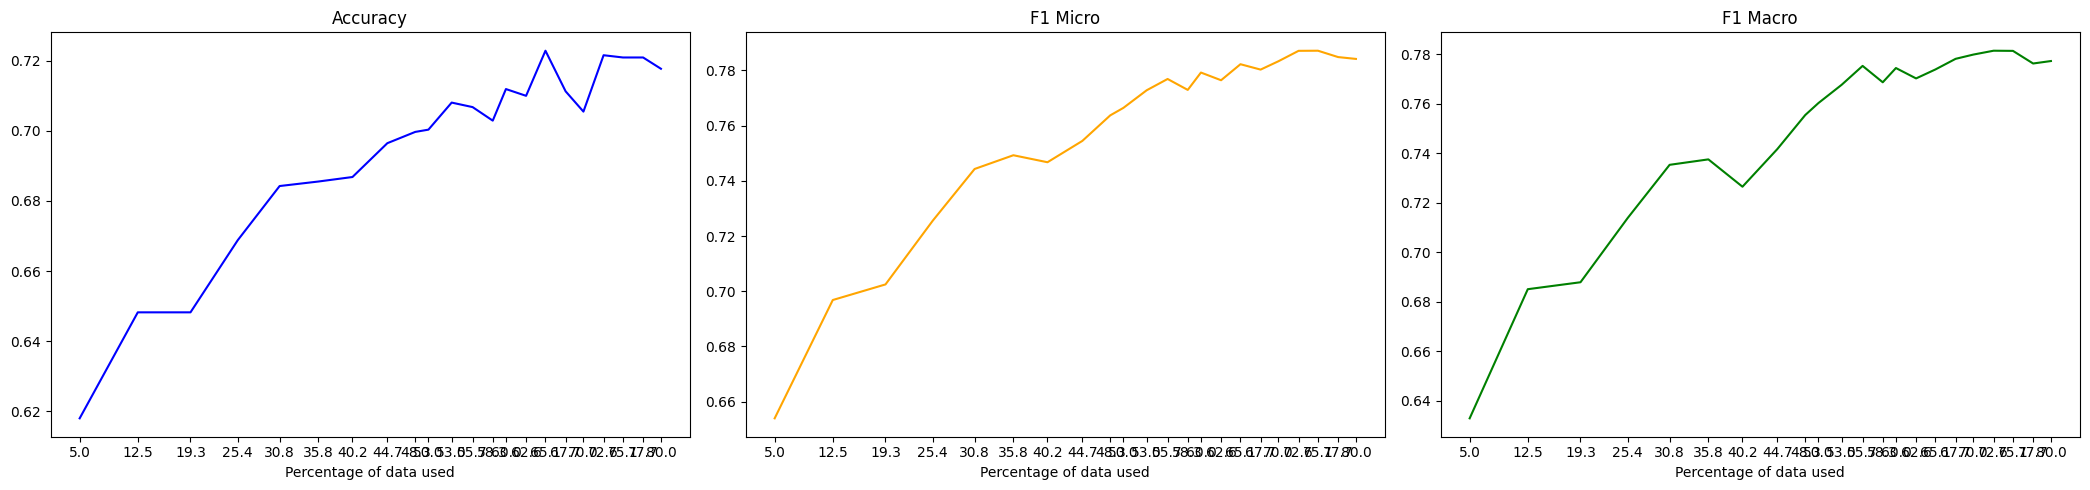

In [18]:
active_learning(seeds[0], 0)

## RUN 2

TRIAL 2
Random seed: 81


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.460827,0.440514,0.957447,0.033937,0.065550,0.044738
2,No log,0.398824,0.576849,0.872222,0.236802,0.372479,0.261927
3,No log,0.353225,0.591640,0.830054,0.349925,0.492308,0.420032
4,No log,0.330393,0.585852,0.775510,0.429864,0.553130,0.459224
5,No log,0.314286,0.593569,0.761511,0.486425,0.593649,0.525215
6,No log,0.306425,0.605145,0.788366,0.480392,0.597001,0.545943
7,No log,0.299625,0.612862,0.739634,0.578431,0.649175,0.610205
8,No log,0.297249,0.616720,0.771834,0.533183,0.630687,0.596109
9,No log,0.294833,0.624437,0.772004,0.549020,0.641692,0.603582
10,No log,0.295964,0.617363,0.774123,0.532428,0.630920,0.592582


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.89      0.79      0.84       362
                sara       0.74      0.23      0.35       237
         radikalisme       0.68      0.60      0.64       235
pencemaran_nama_baik       0.65      0.58      0.62       492

           micro avg       0.74      0.58      0.65      1326
           macro avg       0.74      0.55      0.61      1326
        weighted avg       0.74      0.58      0.63      1326
         samples avg       0.38      0.34      0.35      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 388: Accuracy: 0.6128617363344051, F1 Micro: 0.649174777824799, F1 Macro: 0.6102054118583491
                      precision    recall  f1-score   support

          pornografi       0.89      0.79      0.84       362
                sara       0.74      0.23      0.35       237
         radikalisme       0.68      0.60      0.64       235
pencemaran_nama_baik       0.65      0.58      0.62       492

           micro avg       0.74      0.58      0.65      1326
           macro avg       0.74      0.55      0.61      1326
        weighted avg       0.74      0.58      0.63      1326
         samples avg       0.38      0.34      0.35      1326



/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 3886
Threshold: 23.818601608276367
Samples above threshold: 583
Acquired samples: 583
Sampling duration: 20.859224557876587 seconds
New train size: 971


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.391608,0.568489,0.918567,0.212670,0.345377,0.216756
2,No log,0.346334,0.568489,0.900285,0.238311,0.376863,0.278184
3,No log,0.309935,0.597428,0.745251,0.503017,0.600630,0.569863
4,No log,0.298179,0.605145,0.711864,0.601810,0.652227,0.627850
5,No log,0.297356,0.621865,0.758368,0.546757,0.635408,0.597555
6,No log,0.324648,0.615434,0.794416,0.472097,0.592242,0.540061
7,No log,0.299302,0.621865,0.714286,0.648567,0.679842,0.663419
8,No log,0.307765,0.621865,0.729849,0.621418,0.671283,0.651521
9,0.135700,0.307668,0.630225,0.743119,0.610860,0.670530,0.647768
10,0.135700,0.309351,0.627010,0.733871,0.617647,0.670762,0.648270


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.90      0.87      0.88       362
                sara       0.62      0.43      0.50       237
         radikalisme       0.67      0.63      0.65       235
pencemaran_nama_baik       0.63      0.60      0.62       492

           micro avg       0.71      0.65      0.68      1326
           macro avg       0.70      0.63      0.66      1326
        weighted avg       0.71      0.65      0.68      1326
         samples avg       0.40      0.38      0.38      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 971: Accuracy: 0.6218649517684888, F1 Micro: 0.6798418972332015, F1 Macro: 0.6634189925322678
                      precision    recall  f1-score   support

          pornografi       0.90      0.87      0.88       362
                sara       0.62      0.43      0.50       237
         radikalisme       0.67      0.63      0.65       235
pencemaran_nama_baik       0.63      0.60      0.62       492

           micro avg       0.71      0.65      0.68      1326
           macro avg       0.70      0.63      0.66      1326
        weighted avg       0.71      0.65      0.68      1326
         samples avg       0.40      0.38      0.38      1326



/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 3886
Threshold: 22.461806869506844
Samples above threshold: 525
Acquired samples: 525
Sampling duration: 18.41736888885498 seconds
New train size: 1496


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.351425,0.576849,0.817805,0.297888,0.436705,0.304050
2,No log,0.318509,0.600643,0.785420,0.430618,0.556259,0.422041
3,No log,0.294906,0.605788,0.733075,0.571644,0.642373,0.576802
4,No log,0.290022,0.627653,0.728534,0.633484,0.677693,0.636938
5,No log,0.303255,0.630868,0.764113,0.571644,0.654012,0.610851
6,0.136400,0.296028,0.635370,0.722313,0.668929,0.694597,0.676383
7,0.136400,0.299554,0.646302,0.730737,0.665158,0.696407,0.679282
8,0.136400,0.320263,0.637942,0.756447,0.597285,0.667509,0.641130
9,0.136400,0.317313,0.639871,0.739092,0.638763,0.685275,0.662646
10,0.136400,0.319192,0.639871,0.743386,0.635747,0.685366,0.661766


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.91      0.86      0.89       362
                sara       0.60      0.44      0.51       237
         radikalisme       0.68      0.67      0.67       235
pencemaran_nama_baik       0.67      0.62      0.65       492

           micro avg       0.73      0.67      0.70      1326
           macro avg       0.71      0.65      0.68      1326
        weighted avg       0.73      0.67      0.69      1326
         samples avg       0.40      0.39      0.38      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 1496: Accuracy: 0.6463022508038585, F1 Micro: 0.6964074220292144, F1 Macro: 0.6792815716943266
                      precision    recall  f1-score   support

          pornografi       0.91      0.86      0.89       362
                sara       0.60      0.44      0.51       237
         radikalisme       0.68      0.67      0.67       235
pencemaran_nama_baik       0.67      0.62      0.65       492

           micro avg       0.73      0.67      0.70      1326
           macro avg       0.71      0.65      0.68      1326
        weighted avg       0.73      0.67      0.69      1326
         samples avg       0.40      0.39      0.38      1326



/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 3886
Threshold: 22.361486625671386
Samples above threshold: 473
Acquired samples: 473
Sampling duration: 16.547898769378662 seconds
New train size: 1969


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.317878,0.600643,0.770596,0.458522,0.574941,0.488968
2,No log,0.280756,0.636656,0.738837,0.661388,0.697971,0.646290
3,No log,0.285537,0.656592,0.823529,0.538462,0.651163,0.601524
4,No log,0.278428,0.650161,0.733071,0.702112,0.717257,0.702419
5,0.147700,0.299029,0.660450,0.775746,0.607843,0.681607,0.647760
6,0.147700,0.300136,0.655305,0.733175,0.698341,0.715334,0.689976
7,0.147700,0.317394,0.661736,0.745164,0.668175,0.704573,0.694170
8,0.147700,0.314433,0.666238,0.729584,0.714178,0.721799,0.708856
9,0.051900,0.321538,0.666881,0.760309,0.667421,0.710843,0.693288
10,0.051900,0.323824,0.671383,0.750825,0.686275,0.717100,0.702617


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.90      0.88      0.89       362
                sara       0.58      0.52      0.55       237
         radikalisme       0.72      0.71      0.72       235
pencemaran_nama_baik       0.68      0.69      0.68       492

           micro avg       0.73      0.71      0.72      1326
           macro avg       0.72      0.70      0.71      1326
        weighted avg       0.73      0.71      0.72      1326
         samples avg       0.42      0.41      0.41      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 1969: Accuracy: 0.6662379421221865, F1 Micro: 0.7217987804878048, F1 Macro: 0.7088562070959576
                      precision    recall  f1-score   support

          pornografi       0.90      0.88      0.89       362
                sara       0.58      0.52      0.55       237
         radikalisme       0.72      0.71      0.72       235
pencemaran_nama_baik       0.68      0.69      0.68       492

           micro avg       0.73      0.71      0.72      1326
           macro avg       0.72      0.70      0.71      1326
        weighted avg       0.73      0.71      0.72      1326
         samples avg       0.42      0.41      0.41      1326



/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 3886
Threshold: 22.308552551269532
Samples above threshold: 425
Acquired samples: 425
Sampling duration: 14.917022228240967 seconds
New train size: 2394


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.360553,0.605788,0.854991,0.342383,0.488961,0.389920
2,No log,0.266159,0.645659,0.742690,0.670437,0.704717,0.671246
3,No log,0.272191,0.647588,0.715134,0.726998,0.721017,0.709329
4,0.160800,0.283903,0.663023,0.775529,0.635747,0.698715,0.667481
5,0.160800,0.285202,0.672669,0.779783,0.651584,0.709942,0.685383
6,0.160800,0.300943,0.667524,0.752902,0.684766,0.717220,0.694573
7,0.062100,0.306030,0.681029,0.758143,0.702112,0.729052,0.711974
8,0.062100,0.322226,0.672026,0.749390,0.694570,0.720939,0.701485
9,0.062100,0.327216,0.674598,0.754591,0.681750,0.716323,0.698538
10,0.035000,0.333296,0.674598,0.760720,0.668929,0.711878,0.684678


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.92      0.89      0.90       362
                sara       0.62      0.46      0.53       237
         radikalisme       0.74      0.71      0.73       235
pencemaran_nama_baik       0.70      0.67      0.69       492

           micro avg       0.76      0.70      0.73      1326
           macro avg       0.74      0.69      0.71      1326
        weighted avg       0.75      0.70      0.73      1326
         samples avg       0.42      0.41      0.40      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 2394: Accuracy: 0.6810289389067524, F1 Micro: 0.7290524667188724, F1 Macro: 0.7119744884793027
                      precision    recall  f1-score   support

          pornografi       0.92      0.89      0.90       362
                sara       0.62      0.46      0.53       237
         radikalisme       0.74      0.71      0.73       235
pencemaran_nama_baik       0.70      0.67      0.69       492

           micro avg       0.76      0.70      0.73      1326
           macro avg       0.74      0.69      0.71      1326
        weighted avg       0.75      0.70      0.73      1326
         samples avg       0.42      0.41      0.40      1326



/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 3886
Threshold: 21.014312744140625
Samples above threshold: 384
Acquired samples: 384
Sampling duration: 13.4156014919281 seconds
New train size: 2778


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.345789,0.609646,0.882000,0.332579,0.483023,0.385406
2,No log,0.307891,0.651447,0.856135,0.457768,0.596560,0.494183
3,0.178900,0.265356,0.679100,0.813131,0.607089,0.695164,0.663426
4,0.178900,0.277710,0.671383,0.793446,0.602564,0.684955,0.655765
5,0.178900,0.283980,0.668810,0.743550,0.717195,0.730134,0.712087
6,0.077700,0.299652,0.663023,0.736963,0.724736,0.730798,0.710261
7,0.077700,0.304510,0.677170,0.748031,0.716440,0.731895,0.722502
8,0.077700,0.322348,0.668810,0.737125,0.723228,0.730110,0.709198
9,0.045100,0.324098,0.660450,0.732673,0.725490,0.729064,0.713951
10,0.045100,0.327233,0.668810,0.734866,0.723228,0.729000,0.713871


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.93      0.87      0.90       362
                sara       0.60      0.55      0.57       237
         radikalisme       0.74      0.72      0.73       235
pencemaran_nama_baik       0.69      0.68      0.69       492

           micro avg       0.75      0.72      0.73      1326
           macro avg       0.74      0.71      0.72      1326
        weighted avg       0.75      0.72      0.73      1326
         samples avg       0.42      0.42      0.41      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 2778: Accuracy: 0.6771704180064309, F1 Micro: 0.7318952234206472, F1 Macro: 0.7225016898977357
                      precision    recall  f1-score   support

          pornografi       0.93      0.87      0.90       362
                sara       0.60      0.55      0.57       237
         radikalisme       0.74      0.72      0.73       235
pencemaran_nama_baik       0.69      0.68      0.69       492

           micro avg       0.75      0.72      0.73      1326
           macro avg       0.74      0.71      0.72      1326
        weighted avg       0.75      0.72      0.73      1326
         samples avg       0.42      0.42      0.41      1326



/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 3886
Threshold: 20.6895471572876
Samples above threshold: 344
Acquired samples: 344
Sampling duration: 12.037031173706055 seconds
New train size: 3122


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.317437,0.620579,0.835843,0.418552,0.557789,0.472766
2,No log,0.261823,0.675241,0.714187,0.778281,0.744857,0.734724
3,0.189000,0.255753,0.679743,0.805061,0.647813,0.717927,0.678224
4,0.189000,0.258444,0.684244,0.760474,0.725490,0.742570,0.728163
5,0.189000,0.279612,0.674598,0.759839,0.713424,0.735900,0.712510
6,0.093300,0.284823,0.686817,0.753058,0.742836,0.747912,0.739550
7,0.093300,0.296491,0.688103,0.748489,0.747360,0.747925,0.739972
8,0.055600,0.314237,0.680386,0.752329,0.730769,0.741393,0.726286
9,0.055600,0.321179,0.676527,0.737864,0.745098,0.741463,0.730869
10,0.055600,0.322834,0.681672,0.739421,0.751131,0.745230,0.735185


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.95      0.88      0.91       362
                sara       0.62      0.54      0.58       237
         radikalisme       0.78      0.77      0.77       235
pencemaran_nama_baik       0.66      0.74      0.70       492

           micro avg       0.75      0.75      0.75      1326
           macro avg       0.75      0.73      0.74      1326
        weighted avg       0.75      0.75      0.75      1326
         samples avg       0.43      0.43      0.42      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 3122: Accuracy: 0.6881028938906752, F1 Micro: 0.7479245283018867, F1 Macro: 0.7399724271076312
                      precision    recall  f1-score   support

          pornografi       0.95      0.88      0.91       362
                sara       0.62      0.54      0.58       237
         radikalisme       0.78      0.77      0.77       235
pencemaran_nama_baik       0.66      0.74      0.70       492

           micro avg       0.75      0.75      0.75      1326
           macro avg       0.75      0.73      0.74      1326
        weighted avg       0.75      0.75      0.75      1326
         samples avg       0.43      0.43      0.42      1326



/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 3886
Threshold: 20.16983699798584
Samples above threshold: 310
Acquired samples: 310
Sampling duration: 10.85038423538208 seconds
New train size: 3432


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.275758,0.649518,0.775647,0.610106,0.682989,0.613259
2,No log,0.244922,0.702894,0.789923,0.697587,0.740889,0.726491
3,0.200400,0.244179,0.699678,0.782367,0.742836,0.762089,0.747683
4,0.200400,0.257493,0.681672,0.733939,0.792609,0.762146,0.759026
5,0.104000,0.277812,0.686174,0.785345,0.687029,0.732904,0.712303
6,0.104000,0.280349,0.695820,0.758955,0.766968,0.762941,0.751360
7,0.061200,0.301474,0.678457,0.738197,0.778281,0.757709,0.747572
8,0.061200,0.295959,0.701608,0.772586,0.748115,0.760153,0.749092
9,0.061200,0.304851,0.697106,0.755720,0.772247,0.763894,0.755944
10,0.039400,0.308992,0.692605,0.751852,0.765460,0.758595,0.748806


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.91      0.89      0.90       362
                sara       0.66      0.59      0.62       237
         radikalisme       0.78      0.77      0.78       235
pencemaran_nama_baik       0.68      0.77      0.73       492

           micro avg       0.76      0.77      0.76      1326
           macro avg       0.76      0.76      0.76      1326
        weighted avg       0.76      0.77      0.76      1326
         samples avg       0.44      0.44      0.43      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 3432: Accuracy: 0.6971061093247588, F1 Micro: 0.7638940693770981, F1 Macro: 0.755943778185957
                      precision    recall  f1-score   support

          pornografi       0.91      0.89      0.90       362
                sara       0.66      0.59      0.62       237
         radikalisme       0.78      0.77      0.78       235
pencemaran_nama_baik       0.68      0.77      0.73       492

           micro avg       0.76      0.77      0.76      1326
           macro avg       0.76      0.76      0.76      1326
        weighted avg       0.76      0.77      0.76      1326
         samples avg       0.44      0.44      0.43      1326



/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 3886
Threshold: 19.897738456726074
Samples above threshold: 279
Acquired samples: 279
Sampling duration: 9.827316284179688 seconds
New train size: 3711


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.278483,0.645659,0.815696,0.517345,0.633133,0.582296
2,No log,0.243671,0.697106,0.772222,0.733786,0.752514,0.740063
3,0.212600,0.241705,0.700965,0.758775,0.766214,0.762477,0.754928
4,0.212600,0.252509,0.692605,0.783828,0.716440,0.748621,0.725565
5,0.114300,0.264730,0.689389,0.743205,0.783560,0.762849,0.756579
6,0.114300,0.290614,0.681029,0.730526,0.785068,0.756816,0.757159
7,0.070400,0.296347,0.686817,0.748547,0.776772,0.762398,0.752924
8,0.070400,0.319362,0.677814,0.721733,0.803922,0.760614,0.757847
9,0.046300,0.310909,0.697106,0.764165,0.752640,0.758359,0.750005
10,0.046300,0.316255,0.689389,0.749088,0.774510,0.761587,0.756268


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.93      0.88      0.90       362
                sara       0.65      0.62      0.64       237
         radikalisme       0.73      0.79      0.76       235
pencemaran_nama_baik       0.67      0.79      0.73       492

           micro avg       0.74      0.78      0.76      1326
           macro avg       0.75      0.77      0.76      1326
        weighted avg       0.75      0.78      0.76      1326
         samples avg       0.45      0.45      0.44      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 3711: Accuracy: 0.6893890675241158, F1 Micro: 0.762848751835536, F1 Macro: 0.756579481023691
                      precision    recall  f1-score   support

          pornografi       0.93      0.88      0.90       362
                sara       0.65      0.62      0.64       237
         radikalisme       0.73      0.79      0.76       235
pencemaran_nama_baik       0.67      0.79      0.73       492

           micro avg       0.74      0.78      0.76      1326
           macro avg       0.75      0.77      0.76      1326
        weighted avg       0.75      0.78      0.76      1326
         samples avg       0.45      0.45      0.44      1326



/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 3886
Threshold: 19.181897735595705
Samples above threshold: 251
Acquired samples: 175
Sampling duration: 9.009800910949707 seconds
New train size: 3886


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.269893,0.646945,0.772334,0.606335,0.679341,0.672329
2,No log,0.246316,0.689389,0.792672,0.668929,0.725562,0.711026
3,0.220200,0.246687,0.688103,0.749633,0.769985,0.759673,0.752652
4,0.220200,0.255564,0.697749,0.734973,0.811463,0.771326,0.769214
5,0.121000,0.261297,0.704823,0.794362,0.722474,0.756714,0.740430
6,0.121000,0.281387,0.699678,0.749641,0.788084,0.768382,0.763325
7,0.074900,0.300727,0.686817,0.739192,0.786576,0.762148,0.754907
8,0.074900,0.300108,0.704823,0.770479,0.751885,0.761069,0.748085
9,0.051300,0.305556,0.702251,0.756439,0.775264,0.765736,0.757669
10,0.051300,0.312100,0.693248,0.741637,0.785822,0.763090,0.756276


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.94      0.89      0.92       362
                sara       0.60      0.74      0.66       237
         radikalisme       0.72      0.82      0.77       235
pencemaran_nama_baik       0.69      0.78      0.73       492

           micro avg       0.73      0.81      0.77      1326
           macro avg       0.74      0.81      0.77      1326
        weighted avg       0.75      0.81      0.78      1326
         samples avg       0.44      0.46      0.44      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 3886: Accuracy: 0.6977491961414791, F1 Micro: 0.7713261648745521, F1 Macro: 0.7692144456485993
                      precision    recall  f1-score   support

          pornografi       0.94      0.89      0.92       362
                sara       0.60      0.74      0.66       237
         radikalisme       0.72      0.82      0.77       235
pencemaran_nama_baik       0.69      0.78      0.73       492

           micro avg       0.73      0.81      0.77      1326
           macro avg       0.74      0.81      0.77      1326
        weighted avg       0.75      0.81      0.78      1326
         samples avg       0.44      0.46      0.44      1326



/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 4663
Threshold: 18.456042098999024
Samples above threshold: 234
Acquired samples: 234
Sampling duration: 8.266539096832275 seconds
New train size: 4120


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.270710,0.646302,0.808808,0.567873,0.667257,0.581424
2,0.231600,0.239113,0.708039,0.768936,0.757919,0.763388,0.756720
3,0.231600,0.249106,0.700322,0.736915,0.806938,0.770338,0.764955
4,0.128700,0.251368,0.689389,0.757957,0.772247,0.765035,0.755084
5,0.128700,0.261872,0.702251,0.760822,0.782051,0.771290,0.766791
6,0.085700,0.280054,0.698392,0.738440,0.806938,0.771171,0.764001
7,0.085700,0.288967,0.698392,0.765554,0.760935,0.763238,0.755374
8,0.055400,0.318181,0.693248,0.726725,0.818250,0.769777,0.767071
9,0.055400,0.311511,0.691961,0.743041,0.785068,0.763476,0.754639
10,0.043800,0.309043,0.706752,0.756914,0.784314,0.770370,0.762555


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.93      0.89      0.91       362
                sara       0.67      0.66      0.67       237
         radikalisme       0.72      0.81      0.76       235
pencemaran_nama_baik       0.71      0.75      0.73       492

           micro avg       0.76      0.78      0.77      1326
           macro avg       0.76      0.78      0.77      1326
        weighted avg       0.76      0.78      0.77      1326
         samples avg       0.44      0.44      0.43      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 4120: Accuracy: 0.7022508038585209, F1 Micro: 0.7712904425436965, F1 Macro: 0.7667911880925126
                      precision    recall  f1-score   support

          pornografi       0.93      0.89      0.91       362
                sara       0.67      0.66      0.67       237
         radikalisme       0.72      0.81      0.76       235
pencemaran_nama_baik       0.71      0.75      0.73       492

           micro avg       0.76      0.78      0.77      1326
           macro avg       0.76      0.78      0.77      1326
        weighted avg       0.76      0.78      0.77      1326
         samples avg       0.44      0.44      0.43      1326



/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 4663
Threshold: 19.52783031463623
Samples above threshold: 210
Acquired samples: 210
Sampling duration: 7.39797568321228 seconds
New train size: 4330


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.273442,0.648875,0.830012,0.533937,0.649839,0.616883
2,0.237800,0.241966,0.702894,0.783182,0.716440,0.748326,0.730284
3,0.237800,0.240304,0.702251,0.759559,0.779035,0.769173,0.759477
4,0.132500,0.245769,0.702894,0.773819,0.753394,0.763470,0.748734
5,0.132500,0.280913,0.702251,0.732215,0.822775,0.774858,0.771964
6,0.088900,0.273256,0.711254,0.781903,0.762443,0.772050,0.763668
7,0.088900,0.299523,0.708682,0.754323,0.789593,0.771555,0.766624
8,0.060600,0.319496,0.699035,0.738652,0.809955,0.772662,0.769974
9,0.060600,0.312608,0.707395,0.759764,0.777526,0.768543,0.761476
10,0.044900,0.318807,0.709968,0.754825,0.796380,0.775046,0.771235


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.94      0.91      0.92       362
                sara       0.65      0.65      0.65       237
         radikalisme       0.74      0.83      0.78       235
pencemaran_nama_baik       0.69      0.76      0.72       492

           micro avg       0.75      0.80      0.78      1326
           macro avg       0.75      0.79      0.77      1326
        weighted avg       0.76      0.80      0.78      1326
         samples avg       0.45      0.45      0.44      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 4330: Accuracy: 0.7099678456591639, F1 Micro: 0.775045871559633, F1 Macro: 0.771234887696188
                      precision    recall  f1-score   support

          pornografi       0.94      0.91      0.92       362
                sara       0.65      0.65      0.65       237
         radikalisme       0.74      0.83      0.78       235
pencemaran_nama_baik       0.69      0.76      0.72       492

           micro avg       0.75      0.80      0.78      1326
           macro avg       0.75      0.79      0.77      1326
        weighted avg       0.76      0.80      0.78      1326
         samples avg       0.45      0.45      0.44      1326



/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 4663
Threshold: 18.73076629638672
Samples above threshold: 189
Acquired samples: 200
Sampling duration: 6.681150436401367 seconds
New train size: 4530


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.280399,0.650161,0.836145,0.523379,0.643785,0.601690
2,0.242000,0.245544,0.704180,0.737131,0.809955,0.771829,0.767701
3,0.242000,0.240870,0.697749,0.782780,0.747360,0.764660,0.747014
4,0.143600,0.257082,0.704823,0.753571,0.795626,0.774028,0.765412
5,0.143600,0.273427,0.704180,0.737526,0.813725,0.773754,0.770038
6,0.098400,0.276648,0.708682,0.766390,0.766968,0.766679,0.758492
7,0.098400,0.299647,0.705466,0.751061,0.800905,0.775182,0.769066
8,0.066800,0.319295,0.701608,0.732519,0.813725,0.770990,0.767401
9,0.047500,0.327191,0.707395,0.737449,0.819759,0.776429,0.773833
10,0.047500,0.317851,0.704180,0.751070,0.794118,0.771994,0.767091


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.94      0.90      0.92       362
                sara       0.62      0.73      0.67       237
         radikalisme       0.71      0.83      0.77       235
pencemaran_nama_baik       0.68      0.80      0.74       492

           micro avg       0.74      0.82      0.78      1326
           macro avg       0.74      0.82      0.77      1326
        weighted avg       0.75      0.82      0.78      1326
         samples avg       0.46      0.46      0.45      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 4530: Accuracy: 0.707395498392283, F1 Micro: 0.7764285714285715, F1 Macro: 0.7738330229960001
                      precision    recall  f1-score   support

          pornografi       0.94      0.90      0.92       362
                sara       0.62      0.73      0.67       237
         radikalisme       0.71      0.83      0.77       235
pencemaran_nama_baik       0.68      0.80      0.74       492

           micro avg       0.74      0.82      0.78      1326
           macro avg       0.74      0.82      0.77      1326
        weighted avg       0.75      0.82      0.78      1326
         samples avg       0.46      0.46      0.45      1326



/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 4663
Threshold: 18.276095390319824
Samples above threshold: 169
Acquired samples: 133
Sampling duration: 6.120131254196167 seconds
New train size: 4663


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.261237,0.673312,0.811550,0.604072,0.692607,0.675354
2,0.247800,0.245051,0.709968,0.805240,0.695324,0.746257,0.735243
3,0.247800,0.233334,0.709325,0.780109,0.757164,0.768465,0.753380
4,0.145800,0.254871,0.707395,0.739876,0.812971,0.774704,0.768449
5,0.145800,0.274319,0.709968,0.721897,0.837858,0.775567,0.775734
6,0.104000,0.286539,0.713183,0.740055,0.813725,0.775144,0.770951
7,0.069900,0.291773,0.708039,0.760319,0.791855,0.775767,0.769190
8,0.069900,0.301399,0.714469,0.767374,0.791101,0.779057,0.771991
9,0.050200,0.312230,0.713183,0.756184,0.806938,0.780737,0.776272
10,0.050200,0.317870,0.709325,0.754423,0.803922,0.778386,0.772536


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.93      0.90      0.92       362
                sara       0.64      0.68      0.66       237
         radikalisme       0.75      0.83      0.79       235
pencemaran_nama_baik       0.70      0.79      0.74       492

           micro avg       0.76      0.81      0.78      1326
           macro avg       0.76      0.80      0.78      1326
        weighted avg       0.76      0.81      0.78      1326
         samples avg       0.46      0.46      0.45      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 4663: Accuracy: 0.7131832797427653, F1 Micro: 0.7807369573148486, F1 Macro: 0.7762723791776763
                      precision    recall  f1-score   support

          pornografi       0.93      0.90      0.92       362
                sara       0.64      0.68      0.66       237
         radikalisme       0.75      0.83      0.79       235
pencemaran_nama_baik       0.70      0.79      0.74       492

           micro avg       0.76      0.81      0.78      1326
           macro avg       0.76      0.80      0.78      1326
        weighted avg       0.76      0.81      0.78      1326
         samples avg       0.46      0.46      0.45      1326



/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 5441
Threshold: 18.13023452758789
Samples above threshold: 156
Acquired samples: 200
Sampling duration: 5.517064094543457 seconds
New train size: 4863


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.251115,0.688746,0.782379,0.669683,0.721658,0.711253
2,0.253900,0.245247,0.695820,0.716389,0.843891,0.774931,0.771872
3,0.253900,0.239990,0.709968,0.745775,0.798643,0.771304,0.764810
4,0.159900,0.252418,0.706109,0.735951,0.819759,0.775598,0.771776
5,0.110700,0.267204,0.711897,0.744314,0.814480,0.777818,0.770268
6,0.110700,0.280721,0.712540,0.749298,0.804676,0.776000,0.768753
7,0.078400,0.281475,0.717685,0.761632,0.802413,0.781491,0.774153
8,0.078400,0.300241,0.719614,0.759745,0.808446,0.783339,0.777187
9,0.059300,0.310573,0.720257,0.763899,0.797888,0.780524,0.772081
10,0.044900,0.315407,0.711254,0.752809,0.808446,0.779636,0.773722


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.94      0.91      0.92       362
                sara       0.63      0.70      0.66       237
         radikalisme       0.72      0.85      0.78       235
pencemaran_nama_baik       0.73      0.77      0.75       492

           micro avg       0.76      0.81      0.78      1326
           macro avg       0.75      0.81      0.78      1326
        weighted avg       0.77      0.81      0.79      1326
         samples avg       0.45      0.46      0.45      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 4863: Accuracy: 0.7196141479099678, F1 Micro: 0.7833394227256121, F1 Macro: 0.7771865529110269
                      precision    recall  f1-score   support

          pornografi       0.94      0.91      0.92       362
                sara       0.63      0.70      0.66       237
         radikalisme       0.72      0.85      0.78       235
pencemaran_nama_baik       0.73      0.77      0.75       492

           micro avg       0.76      0.81      0.78      1326
           macro avg       0.75      0.81      0.78      1326
        weighted avg       0.77      0.81      0.79      1326
         samples avg       0.45      0.46      0.45      1326



/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 5441
Threshold: 18.711044311523438
Samples above threshold: 136
Acquired samples: 200
Sampling duration: 4.799919128417969 seconds
New train size: 5063


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.250220,0.699035,0.759690,0.739065,0.749235,0.746265
2,0.258800,0.233578,0.706109,0.774517,0.756410,0.765357,0.763342
3,0.258800,0.232211,0.713183,0.766396,0.784314,0.775252,0.770681
4,0.162400,0.238723,0.715756,0.772455,0.778281,0.775357,0.769160
5,0.117600,0.277495,0.701608,0.717185,0.852941,0.779194,0.776604
6,0.117600,0.276841,0.704180,0.750000,0.796380,0.772495,0.763311
7,0.084600,0.284403,0.715113,0.753879,0.806184,0.779155,0.772234
8,0.062000,0.308663,0.706752,0.738292,0.808446,0.771778,0.765484
9,0.062000,0.314762,0.711254,0.745179,0.815988,0.778978,0.772360
10,0.047900,0.310960,0.709968,0.751233,0.803922,0.776685,0.769557


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.95      0.88      0.91       362
                sara       0.57      0.81      0.67       237
         radikalisme       0.69      0.86      0.77       235
pencemaran_nama_baik       0.68      0.85      0.76       492

           micro avg       0.72      0.85      0.78      1326
           macro avg       0.72      0.85      0.78      1326
        weighted avg       0.74      0.85      0.79      1326
         samples avg       0.46      0.48      0.46      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 5063: Accuracy: 0.7016077170418007, F1 Micro: 0.779193937306235, F1 Macro: 0.7766044113195493
                      precision    recall  f1-score   support

          pornografi       0.95      0.88      0.91       362
                sara       0.57      0.81      0.67       237
         radikalisme       0.69      0.86      0.77       235
pencemaran_nama_baik       0.68      0.85      0.76       492

           micro avg       0.72      0.85      0.78      1326
           macro avg       0.72      0.85      0.78      1326
        weighted avg       0.74      0.85      0.79      1326
         samples avg       0.46      0.48      0.46      1326



/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 5441
Threshold: 17.793231582641603
Samples above threshold: 116
Acquired samples: 200
Sampling duration: 4.168260335922241 seconds
New train size: 5263


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.253653,0.687460,0.768020,0.699095,0.731938,0.713182
2,0.261900,0.232087,0.708039,0.747022,0.803922,0.774428,0.771784
3,0.261900,0.228674,0.718328,0.770310,0.786576,0.778358,0.771680
4,0.177000,0.242484,0.714469,0.761388,0.794118,0.777409,0.771272
5,0.122800,0.261087,0.706752,0.749644,0.794872,0.771596,0.758625
6,0.122800,0.265538,0.711897,0.763756,0.785068,0.774266,0.764402
7,0.090500,0.276805,0.706109,0.760965,0.785068,0.772829,0.763295
8,0.065600,0.293010,0.706752,0.759300,0.785068,0.771969,0.761577
9,0.065600,0.297070,0.712540,0.766052,0.782805,0.774338,0.763750
10,0.053200,0.307359,0.709325,0.748945,0.803167,0.775109,0.768134


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.95      0.87      0.91       362
                sara       0.67      0.64      0.65       237
         radikalisme       0.71      0.87      0.78       235
pencemaran_nama_baik       0.74      0.75      0.74       492

           micro avg       0.77      0.79      0.78      1326
           macro avg       0.76      0.78      0.77      1326
        weighted avg       0.78      0.79      0.78      1326
         samples avg       0.44      0.44      0.43      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 5263: Accuracy: 0.7183279742765273, F1 Micro: 0.778358208955224, F1 Macro: 0.7716804581807537
                      precision    recall  f1-score   support

          pornografi       0.95      0.87      0.91       362
                sara       0.67      0.64      0.65       237
         radikalisme       0.71      0.87      0.78       235
pencemaran_nama_baik       0.74      0.75      0.74       492

           micro avg       0.77      0.79      0.78      1326
           macro avg       0.76      0.78      0.77      1326
        weighted avg       0.78      0.79      0.78      1326
         samples avg       0.44      0.44      0.43      1326



/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 5441
Threshold: 16.97161102294922
Samples above threshold: 96
Acquired samples: 178
Sampling duration: 3.6850056648254395 seconds
New train size: 5441


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.256064,0.686174,0.791552,0.650075,0.713872,0.710991
2,0.273700,0.230590,0.719614,0.752113,0.805430,0.777859,0.775469
3,0.179500,0.227126,0.726688,0.774854,0.799397,0.786934,0.778269
4,0.179500,0.236808,0.717685,0.780938,0.766214,0.773506,0.765048
5,0.129800,0.271146,0.702251,0.725490,0.837104,0.777311,0.774201
6,0.092400,0.294727,0.699035,0.722149,0.831071,0.772791,0.769202
7,0.092400,0.296836,0.699678,0.740868,0.810709,0.774217,0.765775
8,0.072200,0.296465,0.709968,0.775188,0.777526,0.776355,0.766868
9,0.054600,0.309089,0.712540,0.759339,0.797134,0.777778,0.771005
10,0.054600,0.307054,0.715113,0.764069,0.798643,0.780973,0.772791


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.96      0.88      0.91       362
                sara       0.67      0.64      0.66       237
         radikalisme       0.72      0.85      0.78       235
pencemaran_nama_baik       0.73      0.80      0.76       492

           micro avg       0.77      0.80      0.79      1326
           macro avg       0.77      0.79      0.78      1326
        weighted avg       0.78      0.80      0.79      1326
         samples avg       0.46      0.45      0.45      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 5441: Accuracy: 0.7266881028938906, F1 Micro: 0.7869339272457313, F1 Macro: 0.7782690336215752
                      precision    recall  f1-score   support

          pornografi       0.96      0.88      0.91       362
                sara       0.67      0.64      0.66       237
         radikalisme       0.72      0.85      0.78       235
pencemaran_nama_baik       0.73      0.80      0.76       492

           micro avg       0.77      0.80      0.79      1326
           macro avg       0.77      0.79      0.78      1326
        weighted avg       0.78      0.80      0.79      1326
         samples avg       0.46      0.45      0.45      1326



/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 6218
Threshold: 16.60842971801758
Samples above threshold: 78
Acquired samples: 200
Sampling duration: 2.92208194732666 seconds
New train size: 5641


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.245555,0.700322,0.766983,0.732278,0.749228,0.742360
2,0.276000,0.225357,0.696463,0.792875,0.721719,0.755626,0.743323
3,0.183700,0.223681,0.720900,0.790297,0.761689,0.775730,0.759386
4,0.183700,0.241759,0.715113,0.750345,0.820513,0.783862,0.774990
5,0.138700,0.244093,0.716399,0.764448,0.788084,0.776086,0.767200
6,0.103100,0.270668,0.714469,0.758496,0.791101,0.774456,0.765352
7,0.103100,0.273731,0.718971,0.766035,0.792609,0.779096,0.771782
8,0.079300,0.295055,0.720257,0.761665,0.800151,0.780434,0.771317
9,0.058800,0.301626,0.718971,0.768833,0.785068,0.776866,0.765678
10,0.051600,0.315089,0.711897,0.752793,0.812971,0.781726,0.774105


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.91      0.92      0.91       362
                sara       0.62      0.68      0.65       237
         radikalisme       0.71      0.86      0.77       235
pencemaran_nama_baik       0.73      0.80      0.76       492

           micro avg       0.75      0.82      0.78      1326
           macro avg       0.74      0.81      0.77      1326
        weighted avg       0.75      0.82      0.79      1326
         samples avg       0.46      0.46      0.45      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 5641: Accuracy: 0.715112540192926, F1 Micro: 0.7838616714697405, F1 Macro: 0.7749897005763335
                      precision    recall  f1-score   support

          pornografi       0.91      0.92      0.91       362
                sara       0.62      0.68      0.65       237
         radikalisme       0.71      0.86      0.77       235
pencemaran_nama_baik       0.73      0.80      0.76       492

           micro avg       0.75      0.82      0.78      1326
           macro avg       0.74      0.81      0.77      1326
        weighted avg       0.75      0.82      0.79      1326
         samples avg       0.46      0.46      0.45      1326



/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 6218
Threshold: 16.23237724304199
Samples above threshold: 58
Acquired samples: 200
Sampling duration: 2.2188174724578857 seconds
New train size: 5841


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.242101,0.701608,0.792388,0.690799,0.738114,0.728879
2,0.282700,0.236381,0.717042,0.742994,0.819759,0.779491,0.773811
3,0.188800,0.226691,0.720900,0.764875,0.804676,0.784270,0.778141
4,0.188800,0.249999,0.707395,0.733157,0.837104,0.781690,0.778130
5,0.146800,0.253543,0.717042,0.761087,0.802413,0.781204,0.775591
6,0.105600,0.265362,0.722830,0.769231,0.799397,0.784024,0.775033
7,0.083100,0.289379,0.718971,0.761364,0.808446,0.784199,0.778332
8,0.083100,0.299266,0.720257,0.768158,0.789593,0.778728,0.773353
9,0.062000,0.304407,0.722186,0.775130,0.785068,0.780067,0.774568
10,0.051300,0.313060,0.724116,0.764706,0.803922,0.783824,0.777159


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.91      0.91      0.91       362
                sara       0.65      0.69      0.67       237
         radikalisme       0.71      0.88      0.79       235
pencemaran_nama_baik       0.75      0.75      0.75       492

           micro avg       0.76      0.80      0.78      1326
           macro avg       0.75      0.81      0.78      1326
        weighted avg       0.77      0.80      0.78      1326
         samples avg       0.45      0.45      0.44      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 5841: Accuracy: 0.7209003215434083, F1 Micro: 0.7842704887908857, F1 Macro: 0.7781410278314324
                      precision    recall  f1-score   support

          pornografi       0.91      0.91      0.91       362
                sara       0.65      0.69      0.67       237
         radikalisme       0.71      0.88      0.79       235
pencemaran_nama_baik       0.75      0.75      0.75       492

           micro avg       0.76      0.80      0.78      1326
           macro avg       0.75      0.81      0.78      1326
        weighted avg       0.77      0.80      0.78      1326
         samples avg       0.45      0.45      0.44      1326



/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 6218
Threshold: 15.26936779022217
Samples above threshold: 38
Acquired samples: 200
Sampling duration: 1.5443365573883057 seconds
New train size: 6041


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.240717,0.705466,0.777152,0.728507,0.752044,0.736825
2,0.287200,0.229039,0.695177,0.800000,0.708899,0.751699,0.726207
3,0.197200,0.219516,0.726688,0.784314,0.784314,0.784314,0.774295
4,0.151100,0.238750,0.719614,0.765086,0.803167,0.783664,0.775304
5,0.151100,0.262668,0.708682,0.747779,0.825038,0.784511,0.781091
6,0.114000,0.262945,0.719614,0.768212,0.787330,0.777654,0.772337
7,0.084800,0.287063,0.724759,0.761024,0.806938,0.783309,0.776311
8,0.069200,0.287621,0.727331,0.779522,0.786576,0.783033,0.776791
9,0.069200,0.304812,0.724116,0.766112,0.797888,0.781677,0.776152
10,0.054200,0.304762,0.724116,0.770468,0.794872,0.782480,0.776941


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.94      0.90      0.92       362
                sara       0.65      0.69      0.67       237
         radikalisme       0.77      0.81      0.79       235
pencemaran_nama_baik       0.67      0.84      0.75       492

           micro avg       0.75      0.83      0.78      1326
           macro avg       0.76      0.81      0.78      1326
        weighted avg       0.76      0.83      0.79      1326
         samples avg       0.47      0.47      0.46      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 6041: Accuracy: 0.7086816720257235, F1 Micro: 0.7845105772678379, F1 Macro: 0.78109113869405
                      precision    recall  f1-score   support

          pornografi       0.94      0.90      0.92       362
                sara       0.65      0.69      0.67       237
         radikalisme       0.77      0.81      0.79       235
pencemaran_nama_baik       0.67      0.84      0.75       492

           micro avg       0.75      0.83      0.78      1326
           macro avg       0.76      0.81      0.78      1326
        weighted avg       0.76      0.83      0.79      1326
         samples avg       0.47      0.47      0.46      1326



/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 6218
Threshold: 14.128590774536132
Samples above threshold: 18
Acquired samples: 177
Sampling duration: 1.107177495956421 seconds
New train size: 6218


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.242019,0.706109,0.744928,0.775264,0.759793,0.750383
2,0.297700,0.223420,0.710611,0.790660,0.740573,0.764798,0.755066
3,0.204700,0.218579,0.721543,0.768895,0.797888,0.783124,0.776561
4,0.158000,0.233555,0.722186,0.781722,0.780543,0.781132,0.774697
5,0.158000,0.243784,0.716399,0.762348,0.803167,0.782225,0.771391
6,0.121800,0.262557,0.725402,0.764085,0.818250,0.790240,0.782974
7,0.093700,0.279064,0.715756,0.760854,0.806184,0.782863,0.775345
8,0.073000,0.294827,0.722186,0.762074,0.809201,0.784931,0.779366
9,0.057600,0.303275,0.722186,0.764037,0.810709,0.786681,0.780281
10,0.057600,0.304875,0.721543,0.766262,0.808446,0.786789,0.779535


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.89      0.93      0.91       362
                sara       0.65      0.68      0.66       237
         radikalisme       0.74      0.88      0.80       235
pencemaran_nama_baik       0.74      0.77      0.76       492

           micro avg       0.76      0.82      0.79      1326
           macro avg       0.75      0.81      0.78      1326
        weighted avg       0.76      0.82      0.79      1326
         samples avg       0.46      0.46      0.45      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 6218: Accuracy: 0.7254019292604501, F1 Micro: 0.7902403495994172, F1 Macro: 0.7829741257550714
                      precision    recall  f1-score   support

          pornografi       0.89      0.93      0.91       362
                sara       0.65      0.68      0.66       237
         radikalisme       0.74      0.88      0.80       235
pencemaran_nama_baik       0.74      0.77      0.76       492

           micro avg       0.76      0.82      0.79      1326
           macro avg       0.75      0.81      0.78      1326
        weighted avg       0.76      0.82      0.79      1326
         samples avg       0.46      0.46      0.45      1326

Total sampling time: 180.31 seconds
Total runtime: 11130.863033294678 seconds


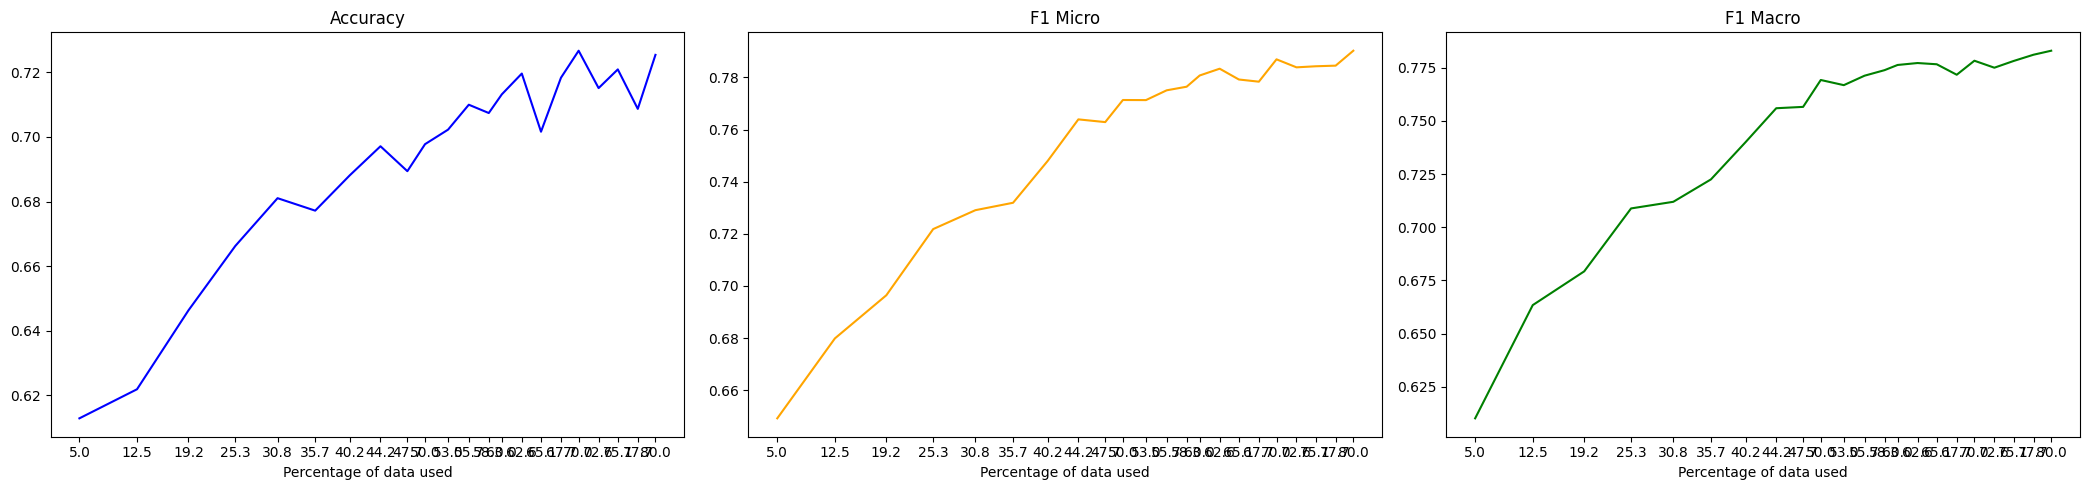

In [19]:
active_learning(seeds[1], 1)

## RUN 3

TRIAL 3
Random seed: 14


pytorch_model.bin:   0%|          | 0.00/498M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Tracking run with wandb version 0.19.1
wandb: Run data is saved locally in /kaggle/working/wandb/run-20241219_090220-uq7347ks
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run ./results/netifier-coreset-3
wandb: ⭐️ View project at https://wandb.ai/nicost918-petra-christian-university/huggingface
wandb: 🚀 View run at https://wandb.ai/nicost918-petra-christian-university/huggingface/runs/uq7347ks


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.466312,0.447588,1.000000,0.012821,0.025316,0.022427
2,No log,0.392322,0.554984,0.920290,0.191554,0.317104,0.211713
3,No log,0.349551,0.584566,0.834646,0.319759,0.462377,0.381456
4,No log,0.331326,0.586495,0.799035,0.374811,0.510267,0.438305
5,No log,0.317812,0.590997,0.812303,0.388386,0.525510,0.465296
6,No log,0.312626,0.603859,0.802213,0.437406,0.566130,0.506563
7,No log,0.301693,0.610289,0.758030,0.533937,0.626549,0.600378
8,No log,0.300017,0.610932,0.759957,0.532428,0.626164,0.598342
9,No log,0.301048,0.610289,0.765419,0.524133,0.622202,0.587982
10,No log,0.300751,0.610289,0.768632,0.521116,0.621124,0.587391


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.91      0.81      0.86       362
                sara       0.64      0.25      0.36       237
         radikalisme       0.68      0.66      0.67       235
pencemaran_nama_baik       0.69      0.41      0.51       492

           micro avg       0.76      0.53      0.63      1326
           macro avg       0.73      0.53      0.60      1326
        weighted avg       0.74      0.53      0.61      1326
         samples avg       0.35      0.31      0.32      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 388: Accuracy: 0.6102893890675242, F1 Micro: 0.6265486725663717, F1 Macro: 0.6003779383425171
                      precision    recall  f1-score   support

          pornografi       0.91      0.81      0.86       362
                sara       0.64      0.25      0.36       237
         radikalisme       0.68      0.66      0.67       235
pencemaran_nama_baik       0.69      0.41      0.51       492

           micro avg       0.76      0.53      0.63      1326
           macro avg       0.73      0.53      0.60      1326
        weighted avg       0.74      0.53      0.61      1326
         samples avg       0.35      0.31      0.32      1326



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 3886
Threshold: 24.150782012939455
Samples above threshold: 583
Acquired samples: 583
Sampling duration: 20.896555423736572 seconds
New train size: 971


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.352159,0.567203,0.767169,0.345400,0.476339,0.384188
2,No log,0.338369,0.590354,0.826230,0.380090,0.520661,0.428523
3,No log,0.325773,0.617363,0.839130,0.436652,0.574405,0.509877
4,No log,0.312565,0.627010,0.774228,0.548265,0.641943,0.595012
5,No log,0.311162,0.626367,0.735185,0.598793,0.660017,0.636888
6,No log,0.313549,0.632154,0.750695,0.610860,0.673597,0.637218
7,No log,0.317825,0.639871,0.755140,0.609351,0.674457,0.648364
8,No log,0.323047,0.635370,0.746175,0.625189,0.680345,0.650232
9,0.122100,0.327552,0.635370,0.750234,0.604827,0.669729,0.644107
10,0.122100,0.327740,0.639228,0.749314,0.617647,0.677139,0.653861


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.90      0.85      0.87       362
                sara       0.63      0.34      0.44       237
         radikalisme       0.76      0.56      0.64       235
pencemaran_nama_baik       0.66      0.63      0.65       492

           micro avg       0.75      0.63      0.68      1326
           macro avg       0.74      0.59      0.65      1326
        weighted avg       0.74      0.63      0.67      1326
         samples avg       0.38      0.35      0.36      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 971: Accuracy: 0.6353697749196141, F1 Micro: 0.6803446860894543, F1 Macro: 0.6502318077631655
                      precision    recall  f1-score   support

          pornografi       0.90      0.85      0.87       362
                sara       0.63      0.34      0.44       237
         radikalisme       0.76      0.56      0.64       235
pencemaran_nama_baik       0.66      0.63      0.65       492

           micro avg       0.75      0.63      0.68      1326
           macro avg       0.74      0.59      0.65      1326
        weighted avg       0.74      0.63      0.67      1326
         samples avg       0.38      0.35      0.36      1326



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 3886
Threshold: 23.501198196411135
Samples above threshold: 525
Acquired samples: 525
Sampling duration: 18.843034982681274 seconds
New train size: 1496


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.327477,0.587138,0.670937,0.631976,0.650874,0.639136
2,No log,0.287769,0.646302,0.818792,0.552036,0.659459,0.642996
3,No log,0.278813,0.650161,0.764279,0.635747,0.694113,0.684108
4,No log,0.282871,0.657878,0.799401,0.604072,0.688144,0.655135
5,No log,0.283773,0.669453,0.805093,0.619910,0.700469,0.680241
6,0.172700,0.296026,0.668167,0.794428,0.623680,0.698775,0.681163
7,0.172700,0.294243,0.668810,0.776386,0.654600,0.710311,0.696036
8,0.172700,0.298232,0.663023,0.772968,0.659879,0.711961,0.693799
9,0.172700,0.304357,0.662379,0.777575,0.643288,0.704086,0.683782
10,0.172700,0.306928,0.666238,0.778890,0.645551,0.705979,0.685988


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.94      0.84      0.89       362
                sara       0.66      0.46      0.55       237
         radikalisme       0.72      0.62      0.67       235
pencemaran_nama_baik       0.72      0.64      0.68       492

           micro avg       0.77      0.66      0.71      1326
           macro avg       0.76      0.64      0.69      1326
        weighted avg       0.77      0.66      0.71      1326
         samples avg       0.38      0.37      0.36      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 1496: Accuracy: 0.6630225080385852, F1 Micro: 0.7119609438567942, F1 Macro: 0.6937989937835953
                      precision    recall  f1-score   support

          pornografi       0.94      0.84      0.89       362
                sara       0.66      0.46      0.55       237
         radikalisme       0.72      0.62      0.67       235
pencemaran_nama_baik       0.72      0.64      0.68       492

           micro avg       0.77      0.66      0.71      1326
           macro avg       0.76      0.64      0.69      1326
        weighted avg       0.77      0.66      0.71      1326
         samples avg       0.38      0.37      0.36      1326



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 3886
Threshold: 22.331089019775394
Samples above threshold: 473
Acquired samples: 473
Sampling duration: 16.89799737930298 seconds
New train size: 1969


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.342170,0.546624,0.597681,0.777526,0.675844,0.677464
2,No log,0.282993,0.659807,0.740408,0.684012,0.711094,0.699169
3,No log,0.270309,0.676527,0.775952,0.676471,0.722804,0.709675
4,No log,0.275297,0.676527,0.796364,0.660633,0.722176,0.704324
5,0.224800,0.280244,0.681672,0.799445,0.652338,0.718439,0.697830
6,0.224800,0.287215,0.677170,0.811357,0.635747,0.712896,0.701643
7,0.224800,0.292400,0.684244,0.798541,0.660633,0.723071,0.713550
8,0.224800,0.303012,0.676527,0.797373,0.641026,0.710702,0.693827
9,0.095700,0.302632,0.682315,0.784777,0.676471,0.726610,0.715172
10,0.095700,0.305481,0.685531,0.794595,0.665158,0.724138,0.710019


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.94      0.85      0.89       362
                sara       0.69      0.53      0.60       237
         radikalisme       0.71      0.68      0.69       235
pencemaran_nama_baik       0.74      0.62      0.68       492

           micro avg       0.78      0.68      0.73      1326
           macro avg       0.77      0.67      0.72      1326
        weighted avg       0.78      0.68      0.72      1326
         samples avg       0.39      0.37      0.37      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 1969: Accuracy: 0.682315112540193, F1 Micro: 0.7266099635479952, F1 Macro: 0.7151724376760238
                      precision    recall  f1-score   support

          pornografi       0.94      0.85      0.89       362
                sara       0.69      0.53      0.60       237
         radikalisme       0.71      0.68      0.69       235
pencemaran_nama_baik       0.74      0.62      0.68       492

           micro avg       0.78      0.68      0.73      1326
           macro avg       0.77      0.67      0.72      1326
        weighted avg       0.78      0.68      0.72      1326
         samples avg       0.39      0.37      0.37      1326



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 3886
Threshold: 20.69972801208496
Samples above threshold: 425
Acquired samples: 425
Sampling duration: 15.247282266616821 seconds
New train size: 2394


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.302687,0.621222,0.748609,0.608597,0.671381,0.660752
2,No log,0.270020,0.670740,0.752205,0.707391,0.729110,0.723677
3,No log,0.267610,0.669453,0.782918,0.663650,0.718367,0.695206
4,0.255400,0.268625,0.684244,0.771452,0.705128,0.736801,0.719063
5,0.255400,0.273752,0.674598,0.779913,0.673454,0.722784,0.700433
6,0.255400,0.286058,0.676527,0.761280,0.699849,0.729273,0.717167
7,0.119000,0.293800,0.674598,0.780786,0.674208,0.723594,0.704145
8,0.119000,0.300532,0.682315,0.784400,0.674962,0.725578,0.714924
9,0.119000,0.304463,0.682315,0.787798,0.671946,0.725275,0.710587
10,0.071400,0.308849,0.682315,0.789615,0.665158,0.722063,0.706880


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.90      0.88      0.89       362
                sara       0.70      0.50      0.58       237
         radikalisme       0.72      0.68      0.70       235
pencemaran_nama_baik       0.72      0.69      0.71       492

           micro avg       0.77      0.71      0.74      1326
           macro avg       0.76      0.69      0.72      1326
        weighted avg       0.77      0.71      0.73      1326
         samples avg       0.40      0.40      0.39      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 2394: Accuracy: 0.6842443729903537, F1 Micro: 0.7368006304176518, F1 Macro: 0.7190626440150769
                      precision    recall  f1-score   support

          pornografi       0.90      0.88      0.89       362
                sara       0.70      0.50      0.58       237
         radikalisme       0.72      0.68      0.70       235
pencemaran_nama_baik       0.72      0.69      0.71       492

           micro avg       0.77      0.71      0.74      1326
           macro avg       0.76      0.69      0.72      1326
        weighted avg       0.77      0.71      0.73      1326
         samples avg       0.40      0.40      0.39      1326



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 3886
Threshold: 19.679644966125487
Samples above threshold: 383
Acquired samples: 383
Sampling duration: 13.782339334487915 seconds
New train size: 2777


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.287616,0.643730,0.730739,0.693816,0.711799,0.696464
2,No log,0.255076,0.677170,0.788121,0.670437,0.724531,0.714757
3,0.264500,0.253367,0.690032,0.778418,0.712670,0.744094,0.730843
4,0.264500,0.247571,0.702894,0.782784,0.733786,0.757493,0.744109
5,0.264500,0.263012,0.701608,0.780788,0.717195,0.747642,0.738763
6,0.135600,0.272571,0.699035,0.777152,0.728507,0.752044,0.743249
7,0.135600,0.285980,0.704180,0.810762,0.681750,0.740680,0.728377
8,0.135600,0.291021,0.700322,0.783429,0.720211,0.750491,0.741682
9,0.080900,0.297811,0.690675,0.778148,0.703620,0.739010,0.726249
10,0.080900,0.299523,0.693891,0.783122,0.699849,0.739148,0.726175


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.94      0.87      0.90       362
                sara       0.70      0.53      0.60       237
         radikalisme       0.75      0.74      0.75       235
pencemaran_nama_baik       0.72      0.73      0.72       492

           micro avg       0.78      0.73      0.76      1326
           macro avg       0.78      0.72      0.74      1326
        weighted avg       0.78      0.73      0.76      1326
         samples avg       0.42      0.41      0.41      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 2777: Accuracy: 0.7028938906752411, F1 Micro: 0.7574931880108992, F1 Macro: 0.744109197913649
                      precision    recall  f1-score   support

          pornografi       0.94      0.87      0.90       362
                sara       0.70      0.53      0.60       237
         radikalisme       0.75      0.74      0.75       235
pencemaran_nama_baik       0.72      0.73      0.72       492

           micro avg       0.78      0.73      0.76      1326
           macro avg       0.78      0.72      0.74      1326
        weighted avg       0.78      0.73      0.76      1326
         samples avg       0.42      0.41      0.41      1326



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 3886
Threshold: 18.968320846557617
Samples above threshold: 345
Acquired samples: 345
Sampling duration: 12.440654754638672 seconds
New train size: 3122


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.279596,0.648875,0.787819,0.604827,0.684300,0.648976
2,No log,0.249990,0.686817,0.806066,0.661388,0.726595,0.705154
3,0.276000,0.248482,0.708682,0.745416,0.797134,0.770408,0.766723
4,0.276000,0.251979,0.698392,0.747285,0.778281,0.762468,0.758564
5,0.276000,0.251024,0.706752,0.803223,0.714178,0.756088,0.742625
6,0.151400,0.266674,0.708039,0.800169,0.712670,0.753889,0.742723
7,0.151400,0.279807,0.711254,0.791974,0.729261,0.759325,0.749037
8,0.091000,0.284115,0.706752,0.786872,0.732278,0.758594,0.750300
9,0.091000,0.287161,0.710611,0.783373,0.739065,0.760574,0.751246
10,0.091000,0.290687,0.708039,0.788399,0.727753,0.756863,0.746836


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.93      0.87      0.90       362
                sara       0.65      0.68      0.66       237
         radikalisme       0.72      0.83      0.77       235
pencemaran_nama_baik       0.69      0.79      0.73       492

           micro avg       0.75      0.80      0.77      1326
           macro avg       0.75      0.79      0.77      1326
        weighted avg       0.75      0.80      0.77      1326
         samples avg       0.44      0.45      0.43      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 3122: Accuracy: 0.7086816720257235, F1 Micro: 0.7704081632653063, F1 Macro: 0.7667227205222228
                      precision    recall  f1-score   support

          pornografi       0.93      0.87      0.90       362
                sara       0.65      0.68      0.66       237
         radikalisme       0.72      0.83      0.77       235
pencemaran_nama_baik       0.69      0.79      0.73       492

           micro avg       0.75      0.80      0.77      1326
           macro avg       0.75      0.79      0.77      1326
        weighted avg       0.75      0.80      0.77      1326
         samples avg       0.44      0.45      0.43      1326



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 3886
Threshold: 18.648527145385742
Samples above threshold: 310
Acquired samples: 310
Sampling duration: 11.20482873916626 seconds
New train size: 3432


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.263584,0.684887,0.771186,0.686275,0.726257,0.722243
2,No log,0.246616,0.695177,0.768868,0.737557,0.752887,0.739274
3,0.279000,0.246168,0.705466,0.815217,0.678733,0.740741,0.731948
4,0.279000,0.249132,0.706752,0.767196,0.765460,0.766327,0.759271
5,0.155900,0.261709,0.707395,0.759851,0.770739,0.765256,0.760416
6,0.155900,0.275177,0.707395,0.790429,0.722474,0.754925,0.746557
7,0.103300,0.287787,0.710611,0.762980,0.764706,0.763842,0.758655
8,0.103300,0.298115,0.706109,0.765613,0.748869,0.757148,0.749542
9,0.103300,0.292927,0.705466,0.783279,0.727753,0.754496,0.744823
10,0.069200,0.294144,0.707395,0.785714,0.721719,0.752358,0.742898


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.93      0.87      0.90       362
                sara       0.69      0.62      0.65       237
         radikalisme       0.71      0.81      0.76       235
pencemaran_nama_baik       0.72      0.74      0.73       492

           micro avg       0.77      0.77      0.77      1326
           macro avg       0.76      0.76      0.76      1326
        weighted avg       0.77      0.77      0.77      1326
         samples avg       0.44      0.43      0.43      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 3432: Accuracy: 0.7067524115755627, F1 Micro: 0.7663269158172896, F1 Macro: 0.7592713474674339
                      precision    recall  f1-score   support

          pornografi       0.93      0.87      0.90       362
                sara       0.69      0.62      0.65       237
         radikalisme       0.71      0.81      0.76       235
pencemaran_nama_baik       0.72      0.74      0.73       492

           micro avg       0.77      0.77      0.77      1326
           macro avg       0.76      0.76      0.76      1326
        weighted avg       0.77      0.77      0.77      1326
         samples avg       0.44      0.43      0.43      1326



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 3886
Threshold: 18.3694429397583
Samples above threshold: 279
Acquired samples: 279
Sampling duration: 10.093319177627563 seconds
New train size: 3711


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.282262,0.645016,0.682446,0.782805,0.729189,0.734206
2,No log,0.256747,0.684887,0.835378,0.616139,0.709201,0.673060
3,0.289900,0.241341,0.699035,0.808341,0.687029,0.742764,0.731387
4,0.289900,0.251401,0.695177,0.761285,0.750377,0.755792,0.744889
5,0.167600,0.250972,0.708039,0.771863,0.765460,0.768648,0.762528
6,0.167600,0.265240,0.709968,0.789896,0.742836,0.765643,0.755047
7,0.113600,0.274471,0.711897,0.797521,0.727753,0.761041,0.751970
8,0.113600,0.285120,0.715756,0.798046,0.739065,0.767424,0.756925
9,0.076600,0.290849,0.711897,0.784144,0.753394,0.768462,0.759709
10,0.076600,0.290817,0.710611,0.779859,0.753394,0.766398,0.759317


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.93      0.89      0.91       362
                sara       0.65      0.65      0.65       237
         radikalisme       0.74      0.79      0.76       235
pencemaran_nama_baik       0.73      0.72      0.73       492

           micro avg       0.77      0.77      0.77      1326
           macro avg       0.76      0.76      0.76      1326
        weighted avg       0.77      0.77      0.77      1326
         samples avg       0.43      0.43      0.42      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 3711: Accuracy: 0.7080385852090032, F1 Micro: 0.7686482393032942, F1 Macro: 0.7625280656241644
                      precision    recall  f1-score   support

          pornografi       0.93      0.89      0.91       362
                sara       0.65      0.65      0.65       237
         radikalisme       0.74      0.79      0.76       235
pencemaran_nama_baik       0.73      0.72      0.73       492

           micro avg       0.77      0.77      0.77      1326
           macro avg       0.76      0.76      0.76      1326
        weighted avg       0.77      0.77      0.77      1326
         samples avg       0.43      0.43      0.42      1326



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 3886
Threshold: 18.05417823791504
Samples above threshold: 253
Acquired samples: 175
Sampling duration: 9.425967454910278 seconds
New train size: 3886


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.275327,0.638585,0.737226,0.685520,0.710434,0.682935
2,No log,0.242098,0.699035,0.757463,0.765460,0.761440,0.754863
3,0.294900,0.240544,0.704180,0.751265,0.783560,0.767073,0.762087
4,0.294900,0.237522,0.706752,0.779767,0.755656,0.767522,0.763121
5,0.177100,0.254332,0.717685,0.807725,0.725490,0.764402,0.755107
6,0.177100,0.266138,0.711254,0.761488,0.787330,0.774194,0.772688
7,0.116300,0.278111,0.710611,0.775019,0.753394,0.764054,0.757467
8,0.116300,0.284165,0.704180,0.761161,0.771493,0.766292,0.761986
9,0.081600,0.290630,0.715113,0.776074,0.763198,0.769582,0.763212
10,0.081600,0.291238,0.719614,0.791534,0.747360,0.768813,0.761771


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.95      0.89      0.92       362
                sara       0.64      0.71      0.67       237
         radikalisme       0.76      0.79      0.78       235
pencemaran_nama_baik       0.70      0.75      0.72       492

           micro avg       0.76      0.79      0.77      1326
           macro avg       0.76      0.78      0.77      1326
        weighted avg       0.77      0.79      0.78      1326
         samples avg       0.44      0.44      0.43      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 3886: Accuracy: 0.7112540192926045, F1 Micro: 0.7741935483870968, F1 Macro: 0.7726875134138671
                      precision    recall  f1-score   support

          pornografi       0.95      0.89      0.92       362
                sara       0.64      0.71      0.67       237
         radikalisme       0.76      0.79      0.78       235
pencemaran_nama_baik       0.70      0.75      0.72       492

           micro avg       0.76      0.79      0.77      1326
           macro avg       0.76      0.78      0.77      1326
        weighted avg       0.77      0.79      0.78      1326
         samples avg       0.44      0.44      0.43      1326



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 4663
Threshold: 17.63262348175049
Samples above threshold: 234
Acquired samples: 234
Sampling duration: 8.507975578308105 seconds
New train size: 4120


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.265665,0.654019,0.736280,0.728507,0.732373,0.716500
2,0.304700,0.235634,0.706109,0.780374,0.755656,0.767816,0.754339
3,0.304700,0.233756,0.709325,0.797364,0.730015,0.762205,0.750218
4,0.185000,0.243488,0.702251,0.754717,0.784314,0.769231,0.764007
5,0.185000,0.249907,0.712540,0.770089,0.780543,0.775281,0.771532
6,0.128600,0.261445,0.705466,0.774637,0.764706,0.769639,0.764253
7,0.128600,0.279450,0.713826,0.783931,0.757919,0.770706,0.762896
8,0.088700,0.294797,0.706109,0.764003,0.771493,0.767730,0.761837
9,0.088700,0.294776,0.706752,0.786454,0.744344,0.764820,0.757661
10,0.069100,0.296227,0.709325,0.783359,0.752640,0.767692,0.760607


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.95      0.87      0.90       362
                sara       0.66      0.68      0.67       237
         radikalisme       0.72      0.83      0.77       235
pencemaran_nama_baik       0.73      0.74      0.74       492

           micro avg       0.77      0.78      0.78      1326
           macro avg       0.77      0.78      0.77      1326
        weighted avg       0.78      0.78      0.78      1326
         samples avg       0.44      0.44      0.43      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 4120: Accuracy: 0.712540192926045, F1 Micro: 0.7752808988764044, F1 Macro: 0.7715316430299167
                      precision    recall  f1-score   support

          pornografi       0.95      0.87      0.90       362
                sara       0.66      0.68      0.67       237
         radikalisme       0.72      0.83      0.77       235
pencemaran_nama_baik       0.73      0.74      0.74       492

           micro avg       0.77      0.78      0.78      1326
           macro avg       0.77      0.78      0.77      1326
        weighted avg       0.78      0.78      0.78      1326
         samples avg       0.44      0.44      0.43      1326



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 4663
Threshold: 17.26502170562744
Samples above threshold: 210
Acquired samples: 210
Sampling duration: 7.690026760101318 seconds
New train size: 4330


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.257262,0.668167,0.750000,0.728507,0.739097,0.719380
2,0.300000,0.235056,0.709968,0.761624,0.778281,0.769862,0.765317
3,0.300000,0.233858,0.709968,0.758646,0.794118,0.775976,0.770519
4,0.185800,0.237005,0.717042,0.804401,0.744344,0.773208,0.764082
5,0.185800,0.252114,0.720257,0.818884,0.719457,0.765957,0.751946
6,0.129200,0.268808,0.715113,0.784760,0.753394,0.768757,0.760003
7,0.129200,0.276399,0.715756,0.793715,0.742836,0.767433,0.757291
8,0.089800,0.284590,0.713826,0.781298,0.762443,0.771756,0.764392
9,0.089800,0.288280,0.713183,0.790865,0.744344,0.766900,0.759491
10,0.069100,0.292432,0.712540,0.781734,0.761689,0.771581,0.765400


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.95      0.88      0.91       362
                sara       0.63      0.69      0.66       237
         radikalisme       0.73      0.81      0.77       235
pencemaran_nama_baik       0.72      0.78      0.74       492

           micro avg       0.76      0.79      0.78      1326
           macro avg       0.76      0.79      0.77      1326
        weighted avg       0.77      0.79      0.78      1326
         samples avg       0.45      0.45      0.44      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 4330: Accuracy: 0.7099678456591639, F1 Micro: 0.7759764185703758, F1 Macro: 0.7705191968953091
                      precision    recall  f1-score   support

          pornografi       0.95      0.88      0.91       362
                sara       0.63      0.69      0.66       237
         radikalisme       0.73      0.81      0.77       235
pencemaran_nama_baik       0.72      0.78      0.74       492

           micro avg       0.76      0.79      0.78      1326
           macro avg       0.76      0.79      0.77      1326
        weighted avg       0.77      0.79      0.78      1326
         samples avg       0.45      0.45      0.44      1326



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 4663
Threshold: 17.26460704803467
Samples above threshold: 189
Acquired samples: 200
Sampling duration: 6.956068992614746 seconds
New train size: 4530


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.251927,0.681029,0.779762,0.691554,0.733014,0.718789
2,0.298800,0.239302,0.702894,0.750897,0.788839,0.769401,0.765392
3,0.298800,0.231824,0.713183,0.772218,0.779789,0.775985,0.771216
4,0.185900,0.241471,0.710611,0.784591,0.752640,0.768283,0.759614
5,0.185900,0.246709,0.713183,0.786499,0.755656,0.770769,0.756339
6,0.133300,0.264806,0.711254,0.787133,0.747360,0.766731,0.755954
7,0.133300,0.285435,0.713183,0.781421,0.754902,0.767932,0.759780
8,0.093000,0.284926,0.709968,0.761696,0.785822,0.773571,0.766938
9,0.070300,0.290262,0.715756,0.786385,0.757919,0.771889,0.763299
10,0.070300,0.295664,0.721543,0.782041,0.768477,0.775200,0.769212


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.92      0.88      0.90       362
                sara       0.66      0.70      0.68       237
         radikalisme       0.73      0.81      0.76       235
pencemaran_nama_baik       0.75      0.73      0.74       492

           micro avg       0.77      0.78      0.78      1326
           macro avg       0.76      0.78      0.77      1326
        weighted avg       0.78      0.78      0.78      1326
         samples avg       0.44      0.44      0.43      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 4530: Accuracy: 0.7131832797427653, F1 Micro: 0.775984990619137, F1 Macro: 0.7712157681973895
                      precision    recall  f1-score   support

          pornografi       0.92      0.88      0.90       362
                sara       0.66      0.70      0.68       237
         radikalisme       0.73      0.81      0.76       235
pencemaran_nama_baik       0.75      0.73      0.74       492

           micro avg       0.77      0.78      0.78      1326
           macro avg       0.76      0.78      0.77      1326
        weighted avg       0.78      0.78      0.78      1326
         samples avg       0.44      0.44      0.43      1326



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 4663
Threshold: 16.439130783081055
Samples above threshold: 169
Acquired samples: 133
Sampling duration: 6.550201416015625 seconds
New train size: 4663


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.250570,0.698392,0.802880,0.672700,0.732048,0.726257
2,0.300200,0.234295,0.711254,0.775621,0.753394,0.764346,0.762887
3,0.300200,0.230869,0.709968,0.778207,0.759427,0.768702,0.764807
4,0.190600,0.246024,0.712540,0.771129,0.777526,0.774315,0.767162
5,0.190600,0.258595,0.706109,0.753541,0.802413,0.777210,0.773438
6,0.134300,0.273114,0.717042,0.767662,0.794872,0.781030,0.775359
7,0.096800,0.284437,0.709325,0.796862,0.727753,0.760741,0.753449
8,0.096800,0.285451,0.718328,0.790716,0.757919,0.773970,0.764385
9,0.073000,0.293554,0.721543,0.789433,0.766214,0.777650,0.770862
10,0.073000,0.298125,0.715756,0.783179,0.765460,0.774218,0.765250


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.94      0.89      0.91       362
                sara       0.65      0.68      0.66       237
         radikalisme       0.72      0.85      0.78       235
pencemaran_nama_baik       0.73      0.76      0.75       492

           micro avg       0.77      0.79      0.78      1326
           macro avg       0.76      0.79      0.78      1326
        weighted avg       0.77      0.79      0.78      1326
         samples avg       0.45      0.45      0.44      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 4663: Accuracy: 0.7170418006430869, F1 Micro: 0.7810300111152279, F1 Macro: 0.7753594639251972
                      precision    recall  f1-score   support

          pornografi       0.94      0.89      0.91       362
                sara       0.65      0.68      0.66       237
         radikalisme       0.72      0.85      0.78       235
pencemaran_nama_baik       0.73      0.76      0.75       492

           micro avg       0.77      0.79      0.78      1326
           macro avg       0.76      0.79      0.78      1326
        weighted avg       0.77      0.79      0.78      1326
         samples avg       0.45      0.45      0.44      1326



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 5441
Threshold: 16.788074493408203
Samples above threshold: 157
Acquired samples: 200
Sampling duration: 5.79302716255188 seconds
New train size: 4863


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.251355,0.690675,0.742468,0.780543,0.761029,0.755978
2,0.301100,0.231111,0.706109,0.821942,0.689291,0.749795,0.733307
3,0.301100,0.232230,0.715756,0.811644,0.714932,0.760225,0.750801
4,0.191000,0.241468,0.711254,0.752628,0.809955,0.780240,0.775651
5,0.138500,0.248187,0.712540,0.779908,0.766968,0.773384,0.764600
6,0.138500,0.266864,0.717042,0.767425,0.788839,0.777984,0.768724
7,0.097300,0.271443,0.720900,0.792320,0.762443,0.777095,0.770380
8,0.097300,0.282432,0.722830,0.803731,0.747360,0.774521,0.765457
9,0.075200,0.295793,0.722830,0.787136,0.775264,0.781155,0.774264
10,0.061000,0.296691,0.720257,0.788417,0.769985,0.779092,0.771374


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.92      0.90      0.91       362
                sara       0.68      0.64      0.66       237
         radikalisme       0.77      0.80      0.78       235
pencemaran_nama_baik       0.75      0.73      0.74       492

           micro avg       0.79      0.78      0.78      1326
           macro avg       0.78      0.77      0.77      1326
        weighted avg       0.79      0.78      0.78      1326
         samples avg       0.44      0.44      0.43      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 4863: Accuracy: 0.7228295819935692, F1 Micro: 0.7811550151975684, F1 Macro: 0.7742639100166211
                      precision    recall  f1-score   support

          pornografi       0.92      0.90      0.91       362
                sara       0.68      0.64      0.66       237
         radikalisme       0.77      0.80      0.78       235
pencemaran_nama_baik       0.75      0.73      0.74       492

           micro avg       0.79      0.78      0.78      1326
           macro avg       0.78      0.77      0.77      1326
        weighted avg       0.79      0.78      0.78      1326
         samples avg       0.44      0.44      0.43      1326



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 5441
Threshold: 15.702507400512696
Samples above threshold: 136
Acquired samples: 200
Sampling duration: 5.029996156692505 seconds
New train size: 5063


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.250167,0.695177,0.760530,0.735294,0.747699,0.738388
2,0.302000,0.231156,0.711254,0.777001,0.754148,0.765404,0.756046
3,0.302000,0.237735,0.711897,0.742838,0.821267,0.780086,0.775634
4,0.195200,0.248952,0.716399,0.747940,0.821267,0.782890,0.777077
5,0.138500,0.238887,0.720900,0.781532,0.785068,0.783296,0.775590
6,0.138500,0.280006,0.718328,0.752113,0.805430,0.777859,0.770541
7,0.106300,0.272558,0.724759,0.795419,0.759427,0.777006,0.768179
8,0.074800,0.285407,0.721543,0.803571,0.746606,0.774042,0.760355
9,0.074800,0.292189,0.718328,0.779052,0.768477,0.773728,0.765847
10,0.063400,0.293588,0.723473,0.784404,0.773756,0.779043,0.770145


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.93      0.90      0.92       362
                sara       0.64      0.65      0.65       237
         radikalisme       0.78      0.79      0.79       235
pencemaran_nama_baik       0.74      0.76      0.75       492

           micro avg       0.78      0.79      0.78      1326
           macro avg       0.78      0.78      0.78      1326
        weighted avg       0.78      0.79      0.78      1326
         samples avg       0.45      0.45      0.44      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 5063: Accuracy: 0.7209003215434083, F1 Micro: 0.783295711060948, F1 Macro: 0.7755897973547299
                      precision    recall  f1-score   support

          pornografi       0.93      0.90      0.92       362
                sara       0.64      0.65      0.65       237
         radikalisme       0.78      0.79      0.79       235
pencemaran_nama_baik       0.74      0.76      0.75       492

           micro avg       0.78      0.79      0.78      1326
           macro avg       0.78      0.78      0.78      1326
        weighted avg       0.78      0.79      0.78      1326
         samples avg       0.45      0.45      0.44      1326



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 5441
Threshold: 15.575226211547852
Samples above threshold: 116
Acquired samples: 200
Sampling duration: 4.369675397872925 seconds
New train size: 5263


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.241189,0.700965,0.774557,0.725490,0.749221,0.743959
2,0.298300,0.227305,0.708039,0.779953,0.751131,0.765271,0.753500
3,0.298300,0.231364,0.717685,0.770880,0.786576,0.778649,0.772784
4,0.199400,0.231999,0.724116,0.808667,0.745852,0.775991,0.765174
5,0.144700,0.248375,0.728617,0.782840,0.777526,0.780174,0.773211
6,0.144700,0.257907,0.718971,0.779043,0.773756,0.776390,0.769515
7,0.111400,0.275810,0.725402,0.775888,0.791101,0.783420,0.777921
8,0.078600,0.290211,0.725402,0.782905,0.780543,0.781722,0.773480
9,0.078600,0.298403,0.715756,0.770540,0.785068,0.777736,0.772109
10,0.065600,0.301091,0.718328,0.768382,0.788084,0.778109,0.770759


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.93      0.91      0.92       362
                sara       0.67      0.65      0.66       237
         radikalisme       0.76      0.83      0.79       235
pencemaran_nama_baik       0.73      0.76      0.74       492

           micro avg       0.78      0.79      0.78      1326
           macro avg       0.77      0.79      0.78      1326
        weighted avg       0.78      0.79      0.78      1326
         samples avg       0.45      0.45      0.44      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 5263: Accuracy: 0.7254019292604501, F1 Micro: 0.7834204630321134, F1 Macro: 0.777920802361302
                      precision    recall  f1-score   support

          pornografi       0.93      0.91      0.92       362
                sara       0.67      0.65      0.66       237
         radikalisme       0.76      0.83      0.79       235
pencemaran_nama_baik       0.73      0.76      0.74       492

           micro avg       0.78      0.79      0.78      1326
           macro avg       0.77      0.79      0.78      1326
        weighted avg       0.78      0.79      0.78      1326
         samples avg       0.45      0.45      0.44      1326



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 5441
Threshold: 15.184699821472169
Samples above threshold: 96
Acquired samples: 178
Sampling duration: 3.882734537124634 seconds
New train size: 5441


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.249215,0.684887,0.737491,0.766968,0.751941,0.752796
2,0.299300,0.224966,0.715113,0.794955,0.736802,0.764775,0.756655
3,0.201000,0.229147,0.711897,0.827061,0.696078,0.755938,0.739960
4,0.201000,0.232613,0.724116,0.793538,0.759427,0.776108,0.765120
5,0.148400,0.240610,0.729260,0.797972,0.771493,0.784509,0.778416
6,0.112100,0.264123,0.732476,0.777531,0.793363,0.785368,0.779627
7,0.112100,0.282841,0.725402,0.761024,0.806938,0.783309,0.778043
8,0.083800,0.288992,0.735691,0.781319,0.794872,0.788037,0.782553
9,0.066500,0.298582,0.733762,0.775837,0.803922,0.789630,0.783305
10,0.066500,0.298680,0.735048,0.788015,0.793363,0.790680,0.783815


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.94      0.91      0.92       362
                sara       0.67      0.65      0.66       237
         radikalisme       0.77      0.84      0.80       235
pencemaran_nama_baik       0.75      0.76      0.75       492

           micro avg       0.79      0.79      0.79      1326
           macro avg       0.78      0.79      0.78      1326
        weighted avg       0.79      0.79      0.79      1326
         samples avg       0.45      0.45      0.44      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 5441: Accuracy: 0.735048231511254, F1 Micro: 0.7906801954152574, F1 Macro: 0.7838151192013332
                      precision    recall  f1-score   support

          pornografi       0.94      0.91      0.92       362
                sara       0.67      0.65      0.66       237
         radikalisme       0.77      0.84      0.80       235
pencemaran_nama_baik       0.75      0.76      0.75       492

           micro avg       0.79      0.79      0.79      1326
           macro avg       0.78      0.79      0.78      1326
        weighted avg       0.79      0.79      0.79      1326
         samples avg       0.45      0.45      0.44      1326



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 6218
Threshold: 14.203713226318358
Samples above threshold: 78
Acquired samples: 200
Sampling duration: 3.0741727352142334 seconds
New train size: 5641


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.241834,0.697749,0.771987,0.714932,0.742365,0.730859
2,0.305300,0.227744,0.708039,0.762825,0.773756,0.768252,0.760827
3,0.202400,0.232018,0.720257,0.791033,0.745098,0.767379,0.753467
4,0.202400,0.235458,0.722186,0.793049,0.757164,0.774691,0.762683
5,0.152500,0.247523,0.725402,0.791894,0.766214,0.778842,0.769324
6,0.112600,0.276278,0.711254,0.749827,0.818250,0.782546,0.776589
7,0.112600,0.280199,0.717685,0.778707,0.772247,0.775464,0.765472
8,0.084400,0.299204,0.724759,0.773696,0.794118,0.783774,0.777198
9,0.065400,0.306336,0.727974,0.777122,0.794118,0.785528,0.780190
10,0.059100,0.306639,0.725402,0.778689,0.788084,0.783358,0.778649


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.92      0.92      0.92       362
                sara       0.69      0.65      0.67       237
         radikalisme       0.76      0.84      0.80       235
pencemaran_nama_baik       0.73      0.75      0.74       492

           micro avg       0.78      0.79      0.79      1326
           macro avg       0.77      0.79      0.78      1326
        weighted avg       0.78      0.79      0.79      1326
         samples avg       0.45      0.45      0.44      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 5641: Accuracy: 0.7279742765273312, F1 Micro: 0.7855277881387542, F1 Macro: 0.7801898232328032
                      precision    recall  f1-score   support

          pornografi       0.92      0.92      0.92       362
                sara       0.69      0.65      0.67       237
         radikalisme       0.76      0.84      0.80       235
pencemaran_nama_baik       0.73      0.75      0.74       492

           micro avg       0.78      0.79      0.79      1326
           macro avg       0.77      0.79      0.78      1326
        weighted avg       0.78      0.79      0.79      1326
         samples avg       0.45      0.45      0.44      1326



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 6218
Threshold: 13.968971061706544
Samples above threshold: 58
Acquired samples: 200
Sampling duration: 2.4231081008911133 seconds
New train size: 5841


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.245192,0.693891,0.772364,0.729261,0.750194,0.741318
2,0.300300,0.224666,0.720257,0.801956,0.742081,0.770858,0.760450
3,0.204700,0.222597,0.714469,0.784781,0.769985,0.777313,0.763949
4,0.204700,0.252321,0.709325,0.739218,0.827300,0.780783,0.776105
5,0.156800,0.251551,0.730547,0.788679,0.788084,0.788382,0.781927
6,0.117500,0.274725,0.723473,0.756401,0.824284,0.788885,0.781515
7,0.087200,0.289781,0.724759,0.763830,0.812217,0.787281,0.779265
8,0.087200,0.300288,0.724116,0.769841,0.804676,0.786873,0.781585
9,0.074700,0.297530,0.724759,0.779259,0.793363,0.786248,0.781838
10,0.059700,0.304217,0.726045,0.777452,0.800905,0.789004,0.784789


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.93      0.91      0.92       362
                sara       0.68      0.68      0.68       237
         radikalisme       0.75      0.84      0.79       235
pencemaran_nama_baik       0.73      0.76      0.74       492

           micro avg       0.78      0.80      0.79      1326
           macro avg       0.77      0.80      0.78      1326
        weighted avg       0.78      0.80      0.79      1326
         samples avg       0.45      0.46      0.45      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 5841: Accuracy: 0.7260450160771704, F1 Micro: 0.7890044576523031, F1 Macro: 0.7847891993803159
                      precision    recall  f1-score   support

          pornografi       0.93      0.91      0.92       362
                sara       0.68      0.68      0.68       237
         radikalisme       0.75      0.84      0.79       235
pencemaran_nama_baik       0.73      0.76      0.74       492

           micro avg       0.78      0.80      0.79      1326
           macro avg       0.77      0.80      0.78      1326
        weighted avg       0.78      0.80      0.79      1326
         samples avg       0.45      0.46      0.45      1326



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 6218
Threshold: 13.482587814331055
Samples above threshold: 38
Acquired samples: 200
Sampling duration: 1.6313214302062988 seconds
New train size: 6041


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.240890,0.704180,0.798969,0.701357,0.746988,0.733726
2,0.299200,0.234664,0.706109,0.729855,0.833333,0.778169,0.775170
3,0.203200,0.222459,0.726688,0.793774,0.769231,0.781310,0.771449
4,0.159900,0.225435,0.729260,0.799216,0.768477,0.783545,0.776082
5,0.159900,0.241929,0.728617,0.776000,0.804676,0.790078,0.781449
6,0.118400,0.254069,0.727974,0.777213,0.807692,0.792160,0.783964
7,0.089900,0.278167,0.729260,0.778839,0.799397,0.788984,0.782201
8,0.070300,0.283616,0.726045,0.780488,0.796380,0.788354,0.782832
9,0.070300,0.293062,0.727974,0.780074,0.797134,0.788512,0.783334
10,0.058700,0.298288,0.728617,0.776076,0.802413,0.789025,0.783061


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.93      0.90      0.92       362
                sara       0.66      0.66      0.66       237
         radikalisme       0.75      0.84      0.79       235
pencemaran_nama_baik       0.74      0.79      0.77       492

           micro avg       0.78      0.81      0.79      1326
           macro avg       0.77      0.80      0.78      1326
        weighted avg       0.78      0.81      0.79      1326
         samples avg       0.46      0.46      0.45      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 6041: Accuracy: 0.7279742765273312, F1 Micro: 0.7921597633136094, F1 Macro: 0.7839641111088721
                      precision    recall  f1-score   support

          pornografi       0.93      0.90      0.92       362
                sara       0.66      0.66      0.66       237
         radikalisme       0.75      0.84      0.79       235
pencemaran_nama_baik       0.74      0.79      0.77       492

           micro avg       0.78      0.81      0.79      1326
           macro avg       0.77      0.80      0.78      1326
        weighted avg       0.78      0.81      0.79      1326
         samples avg       0.46      0.46      0.45      1326



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 6218
Threshold: 15.571789169311524
Samples above threshold: 18
Acquired samples: 177
Sampling duration: 1.2089743614196777 seconds
New train size: 6218


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.244868,0.697106,0.739193,0.773756,0.756080,0.752791
2,0.299400,0.229451,0.717042,0.755462,0.808446,0.781056,0.777654
3,0.201500,0.229321,0.713826,0.789100,0.753394,0.770833,0.760804
4,0.157500,0.236474,0.721543,0.767442,0.796380,0.781643,0.775143
5,0.157500,0.262678,0.712540,0.747222,0.811463,0.778019,0.772567
6,0.120500,0.272648,0.726045,0.767374,0.791101,0.779057,0.770581
7,0.088600,0.286161,0.720900,0.774024,0.777526,0.775771,0.769947
8,0.073500,0.316560,0.715756,0.742877,0.825792,0.782143,0.777019
9,0.058700,0.314058,0.720257,0.758065,0.815234,0.785610,0.779983
10,0.058700,0.305254,0.724116,0.777531,0.793363,0.785368,0.780653


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.91      0.92      0.91       362
                sara       0.64      0.68      0.66       237
         radikalisme       0.75      0.84      0.79       235
pencemaran_nama_baik       0.71      0.79      0.75       492

           micro avg       0.76      0.82      0.79      1326
           macro avg       0.75      0.81      0.78      1326
        weighted avg       0.76      0.82      0.79      1326
         samples avg       0.46      0.47      0.46      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 6218: Accuracy: 0.7202572347266881, F1 Micro: 0.7856104651162791, F1 Macro: 0.7799831994430899
                      precision    recall  f1-score   support

          pornografi       0.91      0.92      0.91       362
                sara       0.64      0.68      0.66       237
         radikalisme       0.75      0.84      0.79       235
pencemaran_nama_baik       0.71      0.79      0.75       492

           micro avg       0.76      0.82      0.79      1326
           macro avg       0.75      0.81      0.78      1326
        weighted avg       0.76      0.82      0.79      1326
         samples avg       0.46      0.47      0.46      1326

Total sampling time: 185.95 seconds
Total runtime: 11630.969444036484 seconds


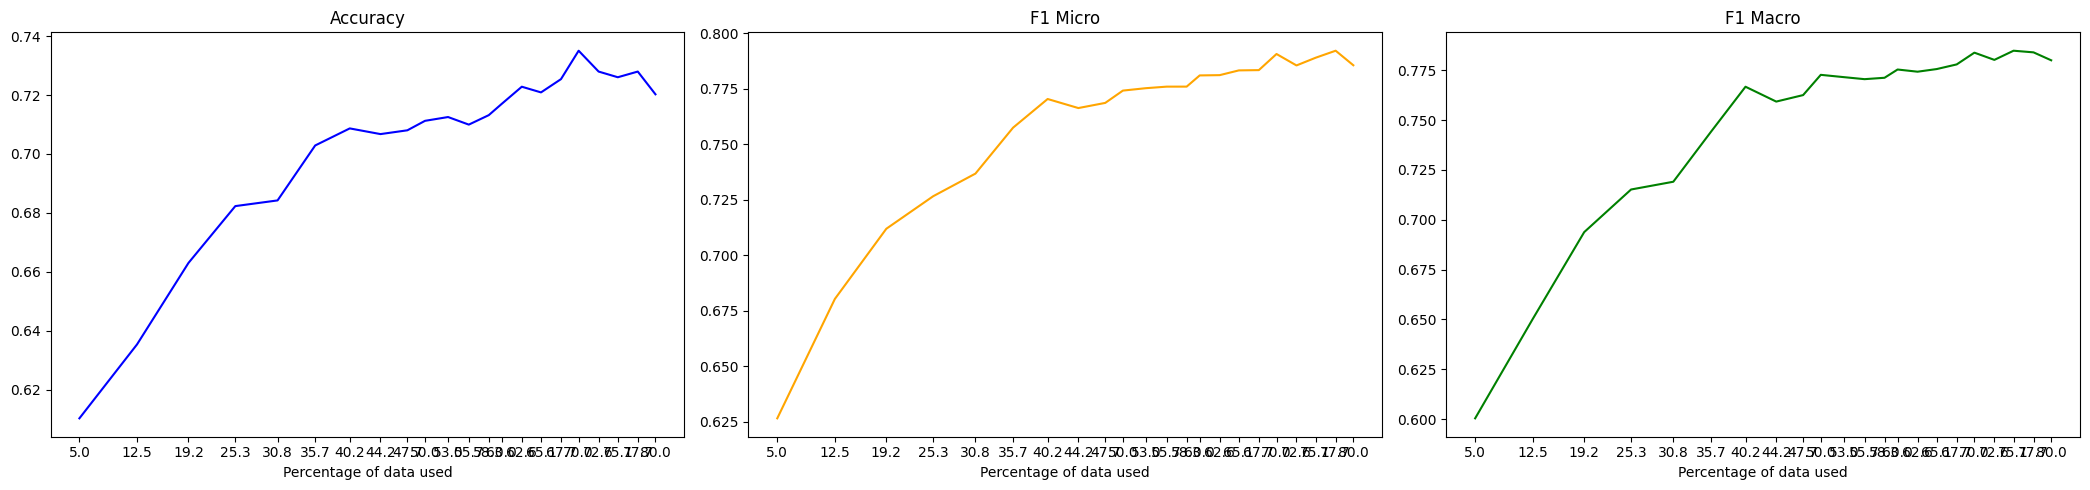

In [ ]:
active_learning(seeds[2], 2)

## RUN 4

TRIAL 4
Random seed: 3


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.463594,0.462379,0.975610,0.030166,0.058522,0.049751
2,No log,0.391793,0.568489,0.831081,0.278281,0.416949,0.340929
3,No log,0.357158,0.562701,0.873684,0.250377,0.389215,0.305181
4,No log,0.331397,0.590354,0.783858,0.432127,0.557122,0.487882
5,No log,0.317543,0.603215,0.790637,0.458522,0.580430,0.516101
6,No log,0.307228,0.619293,0.780571,0.515083,0.620627,0.590389
7,No log,0.304412,0.622508,0.775442,0.528658,0.628700,0.586116
8,No log,0.301726,0.622508,0.763407,0.547511,0.637681,0.605725
9,No log,0.302151,0.625723,0.764644,0.551282,0.640666,0.610989
10,No log,0.300772,0.628939,0.751984,0.571644,0.649529,0.626356


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.93      0.76      0.84       362
                sara       0.70      0.31      0.43       237
         radikalisme       0.65      0.62      0.63       235
pencemaran_nama_baik       0.68      0.53      0.60       492

           micro avg       0.75      0.57      0.65      1326
           macro avg       0.74      0.56      0.63      1326
        weighted avg       0.75      0.57      0.64      1326
         samples avg       0.35      0.33      0.33      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 388: Accuracy: 0.6289389067524116, F1 Micro: 0.6495287060839761, F1 Macro: 0.626355645176144
                      precision    recall  f1-score   support

          pornografi       0.93      0.76      0.84       362
                sara       0.70      0.31      0.43       237
         radikalisme       0.65      0.62      0.63       235
pencemaran_nama_baik       0.68      0.53      0.60       492

           micro avg       0.75      0.57      0.65      1326
           macro avg       0.74      0.56      0.63      1326
        weighted avg       0.75      0.57      0.64      1326
         samples avg       0.35      0.33      0.33      1326



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 3886
Threshold: 25.512775421142578
Samples above threshold: 585
Acquired samples: 585
Sampling duration: 20.793189764022827 seconds
New train size: 973


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.388779,0.564630,0.895899,0.214178,0.345709,0.221962
2,No log,0.344510,0.567846,0.871287,0.265460,0.406936,0.331081
3,No log,0.319508,0.601929,0.826299,0.383861,0.524202,0.457319
4,No log,0.296758,0.627653,0.758376,0.563348,0.646473,0.621173
5,No log,0.302068,0.645659,0.731538,0.634992,0.679855,0.663978
6,No log,0.306392,0.648875,0.751371,0.619910,0.679339,0.662715
7,No log,0.320356,0.642444,0.752153,0.592760,0.663011,0.642337
8,No log,0.328121,0.639228,0.723116,0.644042,0.681292,0.657464
9,0.125400,0.329802,0.645659,0.745170,0.610860,0.671363,0.651048
10,0.125400,0.332005,0.644373,0.734222,0.622926,0.674011,0.655909


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.87      0.86      0.86       362
                sara       0.66      0.42      0.51       237
         radikalisme       0.63      0.58      0.60       235
pencemaran_nama_baik       0.67      0.63      0.65       492

           micro avg       0.72      0.64      0.68      1326
           macro avg       0.71      0.62      0.66      1326
        weighted avg       0.72      0.64      0.68      1326
         samples avg       0.37      0.37      0.36      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 973: Accuracy: 0.6392282958199357, F1 Micro: 0.6812923813322697, F1 Macro: 0.6574642749954621
                      precision    recall  f1-score   support

          pornografi       0.87      0.86      0.86       362
                sara       0.66      0.42      0.51       237
         radikalisme       0.63      0.58      0.60       235
pencemaran_nama_baik       0.67      0.63      0.65       492

           micro avg       0.72      0.64      0.68      1326
           macro avg       0.71      0.62      0.66      1326
        weighted avg       0.72      0.64      0.68      1326
         samples avg       0.37      0.37      0.36      1326



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 3886
Threshold: 25.25302543640137
Samples above threshold: 525
Acquired samples: 525
Sampling duration: 18.626831769943237 seconds
New train size: 1498


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.362726,0.576849,0.897727,0.238311,0.376639,0.261267
2,No log,0.335524,0.603215,0.829352,0.366516,0.508368,0.426669
3,No log,0.283112,0.639871,0.764706,0.588235,0.664962,0.618940
4,No log,0.285563,0.646945,0.755656,0.629713,0.686960,0.662698
5,No log,0.300488,0.655305,0.747639,0.656863,0.699318,0.683741
6,0.120600,0.305611,0.654019,0.748918,0.652338,0.697299,0.676664
7,0.120600,0.315713,0.658521,0.747648,0.659125,0.700601,0.682864
8,0.120600,0.333790,0.652733,0.769157,0.605581,0.677637,0.654712
9,0.120600,0.330898,0.661093,0.726144,0.705882,0.715870,0.700477
10,0.120600,0.333088,0.659807,0.743073,0.667421,0.703218,0.684727


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.89      0.87      0.88       362
                sara       0.63      0.48      0.54       237
         radikalisme       0.66      0.75      0.70       235
pencemaran_nama_baik       0.68      0.67      0.68       492

           micro avg       0.73      0.71      0.72      1326
           macro avg       0.71      0.69      0.70      1326
        weighted avg       0.72      0.71      0.71      1326
         samples avg       0.40      0.41      0.40      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 1498: Accuracy: 0.6610932475884245, F1 Micro: 0.715869980879541, F1 Macro: 0.7004769647273817
                      precision    recall  f1-score   support

          pornografi       0.89      0.87      0.88       362
                sara       0.63      0.48      0.54       237
         radikalisme       0.66      0.75      0.70       235
pencemaran_nama_baik       0.68      0.67      0.68       492

           micro avg       0.73      0.71      0.72      1326
           macro avg       0.71      0.69      0.70      1326
        weighted avg       0.72      0.71      0.71      1326
         samples avg       0.40      0.41      0.40      1326



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 3886
Threshold: 22.914454650878906
Samples above threshold: 472
Acquired samples: 472
Sampling duration: 16.71440029144287 seconds
New train size: 1970


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.377822,0.576849,0.821862,0.306184,0.446154,0.345550
2,No log,0.290131,0.618006,0.727029,0.614630,0.666122,0.612964
3,No log,0.287063,0.654662,0.701805,0.733032,0.717079,0.709022
4,No log,0.302687,0.650804,0.708955,0.716440,0.712678,0.687932
5,0.139600,0.301644,0.669453,0.766245,0.640271,0.697617,0.664641
6,0.139600,0.308103,0.659807,0.749150,0.664404,0.704237,0.676321
7,0.139600,0.335992,0.649518,0.690102,0.762443,0.724472,0.710205
8,0.139600,0.326613,0.662379,0.732689,0.686275,0.708723,0.689565
9,0.048500,0.340972,0.659807,0.721273,0.700603,0.710788,0.691349
10,0.048500,0.340274,0.664309,0.730284,0.698341,0.713955,0.694962


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.88      0.88      0.88       362
                sara       0.58      0.51      0.54       237
         radikalisme       0.66      0.79      0.72       235
pencemaran_nama_baik       0.63      0.78      0.70       492

           micro avg       0.69      0.76      0.72      1326
           macro avg       0.69      0.74      0.71      1326
        weighted avg       0.69      0.76      0.72      1326
         samples avg       0.43      0.44      0.42      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 1970: Accuracy: 0.6495176848874598, F1 Micro: 0.7244715155858115, F1 Macro: 0.7102050395970949
                      precision    recall  f1-score   support

          pornografi       0.88      0.88      0.88       362
                sara       0.58      0.51      0.54       237
         radikalisme       0.66      0.79      0.72       235
pencemaran_nama_baik       0.63      0.78      0.70       492

           micro avg       0.69      0.76      0.72      1326
           macro avg       0.69      0.74      0.71      1326
        weighted avg       0.69      0.76      0.72      1326
         samples avg       0.43      0.44      0.42      1326



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 3886
Threshold: 21.80454387664795
Samples above threshold: 425
Acquired samples: 425
Sampling duration: 15.065368175506592 seconds
New train size: 2395


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.365829,0.583923,0.808028,0.349170,0.487625,0.383283
2,No log,0.278954,0.627010,0.739895,0.634992,0.683442,0.602613
3,No log,0.274187,0.668810,0.786807,0.620664,0.693929,0.659713
4,0.160000,0.301191,0.644373,0.676697,0.797134,0.731994,0.728401
5,0.160000,0.319909,0.663023,0.784474,0.579186,0.666377,0.626999
6,0.160000,0.305382,0.662379,0.755864,0.656109,0.702463,0.676704
7,0.062500,0.317960,0.664309,0.739558,0.680995,0.709069,0.690728
8,0.062500,0.337328,0.671383,0.778828,0.621418,0.691275,0.663700
9,0.062500,0.331638,0.665595,0.730109,0.705882,0.717791,0.698453
10,0.035800,0.334718,0.664309,0.722556,0.724736,0.723645,0.707394


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.94      0.83      0.89       362
                sara       0.54      0.69      0.61       237
         radikalisme       0.65      0.78      0.71       235
pencemaran_nama_baik       0.62      0.83      0.71       492

           micro avg       0.68      0.80      0.73      1326
           macro avg       0.69      0.78      0.73      1326
        weighted avg       0.70      0.80      0.74      1326
         samples avg       0.43      0.46      0.43      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 2395: Accuracy: 0.6443729903536978, F1 Micro: 0.7319944598337951, F1 Macro: 0.7284010342823397
                      precision    recall  f1-score   support

          pornografi       0.94      0.83      0.89       362
                sara       0.54      0.69      0.61       237
         radikalisme       0.65      0.78      0.71       235
pencemaran_nama_baik       0.62      0.83      0.71       492

           micro avg       0.68      0.80      0.73      1326
           macro avg       0.69      0.78      0.73      1326
        weighted avg       0.70      0.80      0.74      1326
         samples avg       0.43      0.46      0.43      1326



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 3886
Threshold: 21.496841430664066
Samples above threshold: 383
Acquired samples: 383
Sampling duration: 13.6622474193573 seconds
New train size: 2778


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.355110,0.586495,0.843373,0.316742,0.460526,0.364505
2,No log,0.310649,0.645659,0.891167,0.426094,0.576531,0.492427
3,0.173000,0.272241,0.666881,0.797776,0.595023,0.681641,0.641719
4,0.173000,0.277944,0.677170,0.792836,0.617647,0.694362,0.657189
5,0.173000,0.288116,0.668810,0.726048,0.731523,0.728775,0.715847
6,0.075900,0.300829,0.670096,0.749369,0.671946,0.708549,0.674832
7,0.075900,0.322077,0.665595,0.699863,0.768477,0.732566,0.722176
8,0.075900,0.327700,0.668167,0.731615,0.727753,0.729679,0.712537
9,0.043000,0.335491,0.664952,0.720654,0.731523,0.726048,0.710341
10,0.043000,0.339989,0.668167,0.720203,0.747360,0.733531,0.721629


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.92      0.88      0.90       362
                sara       0.62      0.54      0.58       237
         radikalisme       0.66      0.77      0.71       235
pencemaran_nama_baik       0.66      0.74      0.70       492

           micro avg       0.72      0.75      0.73      1326
           macro avg       0.72      0.73      0.72      1326
        weighted avg       0.72      0.75      0.73      1326
         samples avg       0.42      0.43      0.42      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 2778: Accuracy: 0.6681672025723473, F1 Micro: 0.7335307179866765, F1 Macro: 0.7216286556175815
                      precision    recall  f1-score   support

          pornografi       0.92      0.88      0.90       362
                sara       0.62      0.54      0.58       237
         radikalisme       0.66      0.77      0.71       235
pencemaran_nama_baik       0.66      0.74      0.70       492

           micro avg       0.72      0.75      0.73      1326
           macro avg       0.72      0.73      0.72      1326
        weighted avg       0.72      0.75      0.73      1326
         samples avg       0.42      0.43      0.42      1326



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 3886
Threshold: 22.051677322387697
Samples above threshold: 344
Acquired samples: 344
Sampling duration: 12.360195875167847 seconds
New train size: 3122


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.302725,0.600000,0.793054,0.413273,0.543381,0.450418
2,No log,0.277542,0.637942,0.808607,0.538462,0.646446,0.561225
3,0.182800,0.270728,0.671383,0.800976,0.619155,0.698426,0.649358
4,0.182800,0.265586,0.686174,0.745594,0.733786,0.739643,0.730648
5,0.182800,0.281380,0.679100,0.732208,0.752640,0.742283,0.735818
6,0.088800,0.320963,0.663023,0.693717,0.799397,0.742817,0.735301
7,0.088800,0.347794,0.668167,0.682489,0.802413,0.737608,0.730847
8,0.050700,0.350008,0.672669,0.693653,0.807692,0.746341,0.742057
9,0.050700,0.337394,0.678457,0.719085,0.758673,0.738349,0.730754
10,0.050700,0.345586,0.666881,0.707317,0.765460,0.735241,0.727337


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.89      0.89      0.89       362
                sara       0.59      0.68      0.64       237
         radikalisme       0.67      0.82      0.73       235
pencemaran_nama_baik       0.64      0.80      0.71       492

           micro avg       0.69      0.81      0.75      1326
           macro avg       0.70      0.80      0.74      1326
        weighted avg       0.70      0.81      0.75      1326
         samples avg       0.44      0.46      0.44      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 3122: Accuracy: 0.6726688102893891, F1 Micro: 0.7463414634146341, F1 Macro: 0.7420568139517993
                      precision    recall  f1-score   support

          pornografi       0.89      0.89      0.89       362
                sara       0.59      0.68      0.64       237
         radikalisme       0.67      0.82      0.73       235
pencemaran_nama_baik       0.64      0.80      0.71       492

           micro avg       0.69      0.81      0.75      1326
           macro avg       0.70      0.80      0.74      1326
        weighted avg       0.70      0.81      0.75      1326
         samples avg       0.44      0.46      0.44      1326



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 3886
Threshold: 20.84160804748535
Samples above threshold: 343
Acquired samples: 343
Sampling duration: 11.135061025619507 seconds
New train size: 3465


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.348627,0.622508,0.915074,0.325038,0.479688,0.382204
2,No log,0.260134,0.651447,0.791913,0.605581,0.686325,0.604641
3,0.190700,0.254904,0.681672,0.709786,0.798643,0.751597,0.742861
4,0.190700,0.258756,0.699678,0.771247,0.732278,0.751257,0.734845
5,0.100000,0.282209,0.693891,0.740175,0.766968,0.753333,0.748656
6,0.100000,0.298548,0.685531,0.765922,0.698341,0.730572,0.706233
7,0.059400,0.305437,0.683601,0.768548,0.718703,0.742790,0.725688
8,0.059400,0.337131,0.677814,0.703826,0.804676,0.750880,0.746429
9,0.059400,0.331261,0.688746,0.734296,0.766968,0.750277,0.744251
10,0.038100,0.337851,0.689389,0.726953,0.779035,0.752093,0.747243


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.94      0.85      0.89       362
                sara       0.64      0.64      0.64       237
         radikalisme       0.68      0.83      0.75       235
pencemaran_nama_baik       0.69      0.74      0.71       492

           micro avg       0.74      0.77      0.75      1326
           macro avg       0.74      0.76      0.75      1326
        weighted avg       0.75      0.77      0.76      1326
         samples avg       0.43      0.44      0.42      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 3465: Accuracy: 0.6938906752411576, F1 Micro: 0.7533333333333333, F1 Macro: 0.7486556739936613
                      precision    recall  f1-score   support

          pornografi       0.94      0.85      0.89       362
                sara       0.64      0.64      0.64       237
         radikalisme       0.68      0.83      0.75       235
pencemaran_nama_baik       0.69      0.74      0.71       492

           micro avg       0.74      0.77      0.75      1326
           macro avg       0.74      0.76      0.75      1326
        weighted avg       0.75      0.77      0.76      1326
         samples avg       0.43      0.44      0.42      1326



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 3886
Threshold: 20.09557228088379
Samples above threshold: 276
Acquired samples: 276
Sampling duration: 9.934978485107422 seconds
New train size: 3741


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.285048,0.625080,0.814815,0.514329,0.630606,0.539438
2,No log,0.249319,0.669453,0.779425,0.674208,0.723008,0.672700
3,0.210700,0.260777,0.693891,0.775646,0.701357,0.736634,0.719451
4,0.210700,0.276278,0.700965,0.724510,0.809201,0.764517,0.760696
5,0.111300,0.283905,0.685531,0.730606,0.781297,0.755102,0.742652
6,0.111300,0.289264,0.710611,0.781452,0.730769,0.755261,0.738416
7,0.069600,0.308443,0.693248,0.727149,0.803922,0.763610,0.762160
8,0.069600,0.322341,0.697749,0.738028,0.790347,0.763292,0.756011
9,0.049000,0.333613,0.693891,0.724932,0.806938,0.763740,0.762905
10,0.049000,0.336026,0.690675,0.724372,0.804676,0.762415,0.760372


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.94      0.85      0.90       362
                sara       0.63      0.70      0.66       237
         radikalisme       0.67      0.85      0.75       235
pencemaran_nama_baik       0.67      0.81      0.74       492

           micro avg       0.72      0.81      0.76      1326
           macro avg       0.73      0.80      0.76      1326
        weighted avg       0.74      0.81      0.77      1326
         samples avg       0.44      0.46      0.44      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 3741: Accuracy: 0.7009646302250804, F1 Micro: 0.7645172782329889, F1 Macro: 0.7606958749257944
                      precision    recall  f1-score   support

          pornografi       0.94      0.85      0.90       362
                sara       0.63      0.70      0.66       237
         radikalisme       0.67      0.85      0.75       235
pencemaran_nama_baik       0.67      0.81      0.74       492

           micro avg       0.72      0.81      0.76      1326
           macro avg       0.73      0.80      0.76      1326
        weighted avg       0.74      0.81      0.77      1326
         samples avg       0.44      0.46      0.44      1326



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 3886
Threshold: 19.175918579101562
Samples above threshold: 248
Acquired samples: 145
Sampling duration: 9.152729749679565 seconds
New train size: 3886


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.264816,0.663666,0.766347,0.662896,0.710877,0.677112
2,No log,0.240704,0.703537,0.768627,0.739065,0.753556,0.734019
3,0.215500,0.259978,0.683601,0.722488,0.797134,0.757978,0.751730
4,0.215500,0.258487,0.702894,0.775397,0.736802,0.755607,0.748229
5,0.117600,0.276696,0.690032,0.735849,0.794118,0.763874,0.756523
6,0.117600,0.290130,0.696463,0.743407,0.786576,0.764383,0.754924
7,0.075800,0.322812,0.688746,0.717577,0.822021,0.766257,0.762694
8,0.075800,0.317051,0.688103,0.743253,0.768477,0.755654,0.744568
9,0.052600,0.316307,0.699678,0.754633,0.767722,0.761121,0.752164
10,0.052600,0.324447,0.697749,0.745182,0.787330,0.765677,0.757721


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.96      0.87      0.91       362
                sara       0.62      0.70      0.66       237
         radikalisme       0.67      0.83      0.74       235
pencemaran_nama_baik       0.65      0.84      0.73       492

           micro avg       0.72      0.82      0.77      1326
           macro avg       0.73      0.81      0.76      1326
        weighted avg       0.73      0.82      0.77      1326
         samples avg       0.46      0.47      0.45      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 3886: Accuracy: 0.6887459807073955, F1 Micro: 0.7662565905096661, F1 Macro: 0.762694240873816
                      precision    recall  f1-score   support

          pornografi       0.96      0.87      0.91       362
                sara       0.62      0.70      0.66       237
         radikalisme       0.67      0.83      0.74       235
pencemaran_nama_baik       0.65      0.84      0.73       492

           micro avg       0.72      0.82      0.77      1326
           macro avg       0.73      0.81      0.76      1326
        weighted avg       0.73      0.82      0.77      1326
         samples avg       0.46      0.47      0.45      1326



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 4663
Threshold: 19.445600700378417
Samples above threshold: 234
Acquired samples: 234
Sampling duration: 8.373843431472778 seconds
New train size: 4120


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.266050,0.673312,0.757498,0.666667,0.709186,0.692115
2,0.228000,0.246094,0.691961,0.773632,0.703620,0.736967,0.718432
3,0.228000,0.247755,0.702894,0.758569,0.767722,0.763118,0.756222
4,0.126200,0.255665,0.698392,0.755374,0.768477,0.761869,0.753102
5,0.126200,0.276536,0.695820,0.740899,0.782805,0.761276,0.752372
6,0.086200,0.286161,0.704180,0.750000,0.787330,0.768212,0.764365
7,0.086200,0.304738,0.704180,0.747997,0.774510,0.761023,0.755847
8,0.057900,0.322323,0.689389,0.728028,0.793363,0.759293,0.756127
9,0.057900,0.331158,0.701608,0.728320,0.810709,0.767309,0.765627
10,0.045100,0.326688,0.704823,0.738128,0.797134,0.766497,0.763738


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.94      0.88      0.91       362
                sara       0.64      0.68      0.66       237
         radikalisme       0.73      0.80      0.76       235
pencemaran_nama_baik       0.69      0.77      0.73       492

           micro avg       0.75      0.79      0.77      1326
           macro avg       0.75      0.78      0.76      1326
        weighted avg       0.76      0.79      0.77      1326
         samples avg       0.44      0.45      0.43      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 4120: Accuracy: 0.7041800643086816, F1 Micro: 0.7682119205298014, F1 Macro: 0.764364826494467
                      precision    recall  f1-score   support

          pornografi       0.94      0.88      0.91       362
                sara       0.64      0.68      0.66       237
         radikalisme       0.73      0.80      0.76       235
pencemaran_nama_baik       0.69      0.77      0.73       492

           micro avg       0.75      0.79      0.77      1326
           macro avg       0.75      0.78      0.76      1326
        weighted avg       0.76      0.79      0.77      1326
         samples avg       0.44      0.45      0.43      1326



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 4663
Threshold: 19.00348644256592
Samples above threshold: 210
Acquired samples: 210
Sampling duration: 7.57072901725769 seconds
New train size: 4330


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.256230,0.675241,0.760669,0.685520,0.721142,0.702137
2,0.230300,0.246353,0.688746,0.739514,0.757919,0.748603,0.738792
3,0.230300,0.252808,0.683601,0.795993,0.659125,0.721122,0.694815
4,0.136000,0.251171,0.699678,0.758542,0.753394,0.755959,0.745521
5,0.136000,0.265364,0.706109,0.762046,0.775264,0.768598,0.759685
6,0.093100,0.302899,0.706752,0.721527,0.826546,0.770475,0.763852
7,0.093100,0.307192,0.703537,0.733699,0.806184,0.768236,0.761133
8,0.065600,0.310385,0.700322,0.744069,0.780543,0.761870,0.755982
9,0.065600,0.317827,0.704180,0.745390,0.792609,0.768275,0.763246
10,0.047900,0.324765,0.700322,0.741525,0.791855,0.765864,0.761168


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.90      0.90      0.90       362
                sara       0.61      0.73      0.66       237
         radikalisme       0.66      0.85      0.74       235
pencemaran_nama_baik       0.70      0.81      0.75       492

           micro avg       0.72      0.83      0.77      1326
           macro avg       0.72      0.82      0.76      1326
        weighted avg       0.73      0.83      0.77      1326
         samples avg       0.45      0.47      0.45      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 4330: Accuracy: 0.7067524115755627, F1 Micro: 0.7704745166959578, F1 Macro: 0.7638521701870034
                      precision    recall  f1-score   support

          pornografi       0.90      0.90      0.90       362
                sara       0.61      0.73      0.66       237
         radikalisme       0.66      0.85      0.74       235
pencemaran_nama_baik       0.70      0.81      0.75       492

           micro avg       0.72      0.83      0.77      1326
           macro avg       0.72      0.82      0.76      1326
        weighted avg       0.73      0.83      0.77      1326
         samples avg       0.45      0.47      0.45      1326



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 4663
Threshold: 19.75248794555664
Samples above threshold: 189
Acquired samples: 200
Sampling duration: 6.808847188949585 seconds
New train size: 4530


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.259465,0.673955,0.772922,0.680241,0.723626,0.691399
2,0.239600,0.240304,0.695177,0.772727,0.730769,0.751163,0.730116
3,0.239600,0.255726,0.691961,0.734286,0.775264,0.754219,0.748414
4,0.138200,0.248486,0.709325,0.772171,0.761689,0.766894,0.759866
5,0.138200,0.283242,0.706752,0.740638,0.805430,0.771676,0.765197
6,0.101600,0.284975,0.708682,0.756484,0.791855,0.773766,0.766860
7,0.101600,0.293874,0.705466,0.785251,0.730769,0.757031,0.749438
8,0.069400,0.317700,0.708039,0.747703,0.797888,0.771981,0.766979
9,0.049900,0.329670,0.706109,0.742698,0.805430,0.772793,0.764937
10,0.049900,0.330150,0.711897,0.747047,0.810709,0.777577,0.771886


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.94      0.89      0.91       362
                sara       0.62      0.70      0.66       237
         radikalisme       0.71      0.83      0.76       235
pencemaran_nama_baik       0.71      0.80      0.75       492

           micro avg       0.75      0.81      0.78      1326
           macro avg       0.74      0.80      0.77      1326
        weighted avg       0.76      0.81      0.78      1326
         samples avg       0.45      0.46      0.45      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 4530: Accuracy: 0.7118971061093248, F1 Micro: 0.7775768535262206, F1 Macro: 0.7718864569190863
                      precision    recall  f1-score   support

          pornografi       0.94      0.89      0.91       362
                sara       0.62      0.70      0.66       237
         radikalisme       0.71      0.83      0.76       235
pencemaran_nama_baik       0.71      0.80      0.75       492

           micro avg       0.75      0.81      0.78      1326
           macro avg       0.74      0.80      0.77      1326
        weighted avg       0.76      0.81      0.78      1326
         samples avg       0.45      0.46      0.45      1326



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 4663
Threshold: 19.252211380004884
Samples above threshold: 169
Acquired samples: 133
Sampling duration: 6.374727249145508 seconds
New train size: 4663


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.257640,0.691961,0.766998,0.697587,0.730648,0.715430
2,0.245200,0.231125,0.707395,0.787977,0.731523,0.758702,0.748510
3,0.245200,0.239398,0.704180,0.743080,0.789593,0.765631,0.762055
4,0.147700,0.271204,0.699035,0.722907,0.840121,0.777119,0.771971
5,0.147700,0.264761,0.709325,0.750716,0.790347,0.770022,0.763443
6,0.104300,0.301352,0.711897,0.730744,0.837104,0.780316,0.777629
7,0.071400,0.291712,0.709325,0.762537,0.779789,0.771066,0.765194
8,0.071400,0.319911,0.708682,0.744122,0.811463,0.776335,0.770759
9,0.051600,0.319477,0.706752,0.749822,0.793363,0.770978,0.764892
10,0.051600,0.325191,0.708039,0.745645,0.806938,0.775081,0.770486


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.96      0.87      0.92       362
                sara       0.62      0.75      0.68       237
         radikalisme       0.68      0.87      0.76       235
pencemaran_nama_baik       0.68      0.84      0.75       492

           micro avg       0.73      0.84      0.78      1326
           macro avg       0.74      0.83      0.78      1326
        weighted avg       0.75      0.84      0.79      1326
         samples avg       0.46      0.48      0.46      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 4663: Accuracy: 0.7118971061093248, F1 Micro: 0.7803163444639719, F1 Macro: 0.7776289392670388
                      precision    recall  f1-score   support

          pornografi       0.96      0.87      0.92       362
                sara       0.62      0.75      0.68       237
         radikalisme       0.68      0.87      0.76       235
pencemaran_nama_baik       0.68      0.84      0.75       492

           micro avg       0.73      0.84      0.78      1326
           macro avg       0.74      0.83      0.78      1326
        weighted avg       0.75      0.84      0.79      1326
         samples avg       0.46      0.48      0.46      1326



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 5441
Threshold: 18.70529556274414
Samples above threshold: 156
Acquired samples: 200
Sampling duration: 5.7427003383636475 seconds
New train size: 4863


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.253167,0.688103,0.777494,0.687783,0.729892,0.710247
2,0.247600,0.230204,0.700322,0.793797,0.714178,0.751886,0.740252
3,0.247600,0.229062,0.718328,0.774340,0.773756,0.774048,0.770194
4,0.155000,0.250694,0.714469,0.753980,0.785822,0.769572,0.762411
5,0.106600,0.290658,0.711897,0.729941,0.843891,0.782791,0.779487
6,0.106600,0.269208,0.708682,0.757948,0.791101,0.774170,0.767133
7,0.078200,0.294394,0.713826,0.763061,0.782051,0.772439,0.766437
8,0.078200,0.318736,0.712540,0.738160,0.822775,0.778174,0.774152
9,0.054300,0.317463,0.711254,0.748081,0.808446,0.777093,0.771917
10,0.043400,0.322076,0.713826,0.749651,0.810709,0.778986,0.774618


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.95      0.88      0.91       362
                sara       0.64      0.73      0.68       237
         radikalisme       0.68      0.88      0.77       235
pencemaran_nama_baik       0.68      0.86      0.76       492

           micro avg       0.73      0.84      0.78      1326
           macro avg       0.74      0.84      0.78      1326
        weighted avg       0.74      0.84      0.79      1326
         samples avg       0.46      0.48      0.46      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 4863: Accuracy: 0.7118971061093248, F1 Micro: 0.782791185729276, F1 Macro: 0.7794865401758841
                      precision    recall  f1-score   support

          pornografi       0.95      0.88      0.91       362
                sara       0.64      0.73      0.68       237
         radikalisme       0.68      0.88      0.77       235
pencemaran_nama_baik       0.68      0.86      0.76       492

           micro avg       0.73      0.84      0.78      1326
           macro avg       0.74      0.84      0.78      1326
        weighted avg       0.74      0.84      0.79      1326
         samples avg       0.46      0.48      0.46      1326



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 5441
Threshold: 18.495538330078126
Samples above threshold: 136
Acquired samples: 200
Sampling duration: 4.958630084991455 seconds
New train size: 5063


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.255664,0.677170,0.788321,0.651584,0.713460,0.688709
2,0.258700,0.234917,0.690032,0.781250,0.716440,0.747443,0.719012
3,0.258700,0.235866,0.710611,0.775229,0.764706,0.769932,0.761379
4,0.165500,0.250948,0.704823,0.761834,0.776772,0.769231,0.757519
5,0.114500,0.331490,0.698392,0.682428,0.881599,0.769332,0.766991
6,0.114500,0.286317,0.710611,0.745492,0.810709,0.776734,0.767445
7,0.084800,0.300696,0.713826,0.746372,0.814480,0.778940,0.773069
8,0.060900,0.303881,0.714469,0.759539,0.795626,0.777164,0.772117
9,0.060900,0.310050,0.715756,0.762491,0.794118,0.777983,0.772163
10,0.050100,0.320163,0.709968,0.748588,0.799397,0.773158,0.767196


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.92      0.91      0.92       362
                sara       0.63      0.70      0.66       237
         radikalisme       0.71      0.84      0.77       235
pencemaran_nama_baik       0.71      0.79      0.74       492

           micro avg       0.75      0.81      0.78      1326
           macro avg       0.74      0.81      0.77      1326
        weighted avg       0.75      0.81      0.78      1326
         samples avg       0.46      0.47      0.45      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 5063: Accuracy: 0.7138263665594855, F1 Micro: 0.7789397764154345, F1 Macro: 0.7730686051944189
                      precision    recall  f1-score   support

          pornografi       0.92      0.91      0.92       362
                sara       0.63      0.70      0.66       237
         radikalisme       0.71      0.84      0.77       235
pencemaran_nama_baik       0.71      0.79      0.74       492

           micro avg       0.75      0.81      0.78      1326
           macro avg       0.74      0.81      0.77      1326
        weighted avg       0.75      0.81      0.78      1326
         samples avg       0.46      0.47      0.45      1326



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 5441
Threshold: 18.440899658203126
Samples above threshold: 116
Acquired samples: 200
Sampling duration: 4.360881328582764 seconds
New train size: 5263


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.251133,0.689389,0.744361,0.746606,0.745482,0.741151
2,0.265300,0.230878,0.708682,0.780159,0.741327,0.760247,0.748250
3,0.265300,0.229501,0.711897,0.797688,0.728507,0.761529,0.752250
4,0.173400,0.250224,0.704823,0.749637,0.779035,0.764053,0.757559
5,0.122900,0.277973,0.705466,0.727152,0.828054,0.774330,0.765558
6,0.122900,0.264283,0.715756,0.767870,0.785822,0.776742,0.768716
7,0.090300,0.302638,0.715113,0.738836,0.823529,0.778887,0.773615
8,0.065600,0.316376,0.714469,0.734177,0.831071,0.779625,0.774393
9,0.065600,0.318868,0.713183,0.740918,0.815234,0.776302,0.768588
10,0.053900,0.312355,0.711897,0.753571,0.795626,0.774028,0.766537


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.94      0.91      0.92       362
                sara       0.59      0.75      0.66       237
         radikalisme       0.69      0.86      0.76       235
pencemaran_nama_baik       0.71      0.80      0.75       492

           micro avg       0.73      0.83      0.78      1326
           macro avg       0.73      0.83      0.77      1326
        weighted avg       0.75      0.83      0.78      1326
         samples avg       0.46      0.47      0.46      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 5263: Accuracy: 0.7144694533762058, F1 Micro: 0.7796250442164839, F1 Macro: 0.7743930275749433
                      precision    recall  f1-score   support

          pornografi       0.94      0.91      0.92       362
                sara       0.59      0.75      0.66       237
         radikalisme       0.69      0.86      0.76       235
pencemaran_nama_baik       0.71      0.80      0.75       492

           micro avg       0.73      0.83      0.78      1326
           macro avg       0.73      0.83      0.77      1326
        weighted avg       0.75      0.83      0.78      1326
         samples avg       0.46      0.47      0.46      1326



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 5441
Threshold: 17.949749755859376
Samples above threshold: 96
Acquired samples: 178
Sampling duration: 3.8174545764923096 seconds
New train size: 5441


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.244464,0.699035,0.780183,0.706637,0.741591,0.729286
2,0.271400,0.229657,0.700322,0.784504,0.733032,0.757895,0.744569
3,0.183700,0.233025,0.710611,0.780063,0.743590,0.761390,0.755529
4,0.183700,0.238282,0.713826,0.746713,0.813725,0.778780,0.774948
5,0.128600,0.263110,0.715756,0.778891,0.762443,0.770579,0.752215
6,0.099100,0.280946,0.700965,0.733425,0.800905,0.765681,0.757530
7,0.099100,0.293614,0.709968,0.750694,0.815234,0.781634,0.772443
8,0.071600,0.303645,0.708039,0.750357,0.793363,0.771261,0.763525
9,0.057300,0.315912,0.708039,0.746844,0.803167,0.773983,0.766133
10,0.057300,0.310557,0.712540,0.760492,0.792609,0.776219,0.767876


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.93      0.91      0.92       362
                sara       0.63      0.66      0.64       237
         radikalisme       0.71      0.84      0.77       235
pencemaran_nama_baik       0.71      0.81      0.76       492

           micro avg       0.75      0.82      0.78      1326
           macro avg       0.75      0.80      0.77      1326
        weighted avg       0.76      0.82      0.78      1326
         samples avg       0.46      0.47      0.46      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 5441: Accuracy: 0.7099678456591639, F1 Micro: 0.7816341287057122, F1 Macro: 0.7724429650121575
                      precision    recall  f1-score   support

          pornografi       0.93      0.91      0.92       362
                sara       0.63      0.66      0.64       237
         radikalisme       0.71      0.84      0.77       235
pencemaran_nama_baik       0.71      0.81      0.76       492

           micro avg       0.75      0.82      0.78      1326
           macro avg       0.75      0.80      0.77      1326
        weighted avg       0.76      0.82      0.78      1326
         samples avg       0.46      0.47      0.46      1326



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 6218
Threshold: 17.343746948242188
Samples above threshold: 78
Acquired samples: 200
Sampling duration: 3.0365312099456787 seconds
New train size: 5641


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.250705,0.697749,0.766935,0.717195,0.741231,0.731435
2,0.279900,0.233585,0.699035,0.813406,0.677225,0.739095,0.713564
3,0.183400,0.234117,0.714469,0.747433,0.823529,0.783638,0.775393
4,0.183400,0.243326,0.719614,0.761871,0.798643,0.779823,0.775361
5,0.140300,0.254697,0.712540,0.765106,0.763952,0.764528,0.754246
6,0.103300,0.267602,0.709325,0.758496,0.791101,0.774456,0.768681
7,0.103300,0.277164,0.718971,0.764317,0.785068,0.774554,0.767586
8,0.081000,0.302076,0.717685,0.754261,0.800905,0.776884,0.769504
9,0.061400,0.318296,0.713826,0.741935,0.815234,0.776860,0.770884
10,0.049700,0.308500,0.716399,0.757576,0.791855,0.774336,0.766956


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.89      0.92      0.90       362
                sara       0.63      0.68      0.65       237
         radikalisme       0.73      0.86      0.79       235
pencemaran_nama_baik       0.72      0.80      0.76       492

           micro avg       0.75      0.82      0.78      1326
           macro avg       0.74      0.82      0.78      1326
        weighted avg       0.75      0.82      0.78      1326
         samples avg       0.46      0.47      0.45      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 5641: Accuracy: 0.7144694533762058, F1 Micro: 0.7836383207750268, F1 Macro: 0.7753931306661289
                      precision    recall  f1-score   support

          pornografi       0.89      0.92      0.90       362
                sara       0.63      0.68      0.65       237
         radikalisme       0.73      0.86      0.79       235
pencemaran_nama_baik       0.72      0.80      0.76       492

           micro avg       0.75      0.82      0.78      1326
           macro avg       0.74      0.82      0.78      1326
        weighted avg       0.75      0.82      0.78      1326
         samples avg       0.46      0.47      0.45      1326



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 6218
Threshold: 16.57730484008789
Samples above threshold: 58
Acquired samples: 200
Sampling duration: 2.354459524154663 seconds
New train size: 5841


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.243803,0.708682,0.760091,0.752640,0.756347,0.749167
2,0.283300,0.231283,0.718971,0.795868,0.726244,0.759464,0.748422
3,0.193600,0.225458,0.713183,0.765926,0.779789,0.772795,0.768107
4,0.193600,0.235379,0.718971,0.759857,0.799397,0.779125,0.774247
5,0.148800,0.254342,0.723473,0.784012,0.769231,0.776551,0.762433
6,0.107400,0.283828,0.714469,0.732713,0.831071,0.778799,0.773025
7,0.082800,0.278972,0.725402,0.780895,0.776772,0.778828,0.769306
8,0.082800,0.306718,0.723473,0.750000,0.823529,0.785047,0.778571
9,0.067500,0.304299,0.722186,0.766813,0.791101,0.778768,0.771365
10,0.051400,0.310846,0.724116,0.761871,0.798643,0.779823,0.773568


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.92      0.93      0.92       362
                sara       0.62      0.70      0.66       237
         radikalisme       0.72      0.85      0.78       235
pencemaran_nama_baik       0.71      0.79      0.75       492

           micro avg       0.75      0.82      0.79      1326
           macro avg       0.74      0.82      0.78      1326
        weighted avg       0.75      0.82      0.79      1326
         samples avg       0.46      0.47      0.46      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 5841: Accuracy: 0.7234726688102894, F1 Micro: 0.7850467289719627, F1 Macro: 0.7785714782423613
                      precision    recall  f1-score   support

          pornografi       0.92      0.93      0.92       362
                sara       0.62      0.70      0.66       237
         radikalisme       0.72      0.85      0.78       235
pencemaran_nama_baik       0.71      0.79      0.75       492

           micro avg       0.75      0.82      0.79      1326
           macro avg       0.74      0.82      0.78      1326
        weighted avg       0.75      0.82      0.79      1326
         samples avg       0.46      0.47      0.46      1326



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 6218
Threshold: 16.031789016723632
Samples above threshold: 38
Acquired samples: 200
Sampling duration: 1.5897789001464844 seconds
New train size: 6041


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.239734,0.693248,0.787162,0.702866,0.742629,0.717210
2,0.290200,0.221439,0.713826,0.769865,0.774510,0.772180,0.761544
3,0.195300,0.228407,0.724759,0.794643,0.738311,0.765442,0.750499
4,0.153500,0.233392,0.720257,0.785714,0.771493,0.778539,0.768864
5,0.153500,0.254408,0.728617,0.765759,0.806184,0.785452,0.775450
6,0.110500,0.259782,0.722830,0.787201,0.769985,0.778498,0.768201
7,0.087700,0.285838,0.718328,0.762213,0.800151,0.780721,0.771908
8,0.068000,0.293162,0.725402,0.775722,0.790347,0.782966,0.776723
9,0.068000,0.309461,0.721543,0.753846,0.812971,0.782293,0.777526
10,0.054700,0.305776,0.722186,0.773739,0.786576,0.780105,0.772214


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.91      0.92      0.91       362
                sara       0.64      0.64      0.64       237
         radikalisme       0.72      0.88      0.79       235
pencemaran_nama_baik       0.75      0.77      0.76       492

           micro avg       0.77      0.81      0.79      1326
           macro avg       0.75      0.80      0.78      1326
        weighted avg       0.77      0.81      0.79      1326
         samples avg       0.46      0.46      0.45      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 6041: Accuracy: 0.7286173633440515, F1 Micro: 0.7854518736223365, F1 Macro: 0.7754497005624232
                      precision    recall  f1-score   support

          pornografi       0.91      0.92      0.91       362
                sara       0.64      0.64      0.64       237
         radikalisme       0.72      0.88      0.79       235
pencemaran_nama_baik       0.75      0.77      0.76       492

           micro avg       0.77      0.81      0.79      1326
           macro avg       0.75      0.80      0.78      1326
        weighted avg       0.77      0.81      0.79      1326
         samples avg       0.46      0.46      0.45      1326



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 6218
Threshold: 14.691578483581543
Samples above threshold: 18
Acquired samples: 177
Sampling duration: 1.1325621604919434 seconds
New train size: 6218


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.237993,0.696463,0.791134,0.699849,0.742697,0.736520
2,0.297700,0.225474,0.713826,0.778638,0.758673,0.768526,0.761790
3,0.206400,0.238067,0.713826,0.733333,0.837858,0.782119,0.778567
4,0.159700,0.233897,0.722830,0.785441,0.773002,0.779171,0.771292
5,0.159700,0.252658,0.715756,0.765988,0.794872,0.780163,0.772169
6,0.121700,0.271063,0.714469,0.760901,0.789593,0.774981,0.768353
7,0.095700,0.291518,0.713826,0.753879,0.806184,0.779155,0.772546
8,0.073900,0.291287,0.722830,0.778198,0.775264,0.776728,0.772292
9,0.061100,0.307712,0.721543,0.763728,0.797134,0.780074,0.774082
10,0.061100,0.309851,0.721543,0.764706,0.794118,0.779134,0.773814


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.93      0.89      0.91       362
                sara       0.61      0.73      0.66       237
         radikalisme       0.70      0.91      0.79       235
pencemaran_nama_baik       0.70      0.82      0.75       492

           micro avg       0.73      0.84      0.78      1326
           macro avg       0.73      0.84      0.78      1326
        weighted avg       0.74      0.84      0.79      1326
         samples avg       0.46      0.47      0.46      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 6218: Accuracy: 0.7138263665594855, F1 Micro: 0.7821189721928897, F1 Macro: 0.778567135554925
                      precision    recall  f1-score   support

          pornografi       0.93      0.89      0.91       362
                sara       0.61      0.73      0.66       237
         radikalisme       0.70      0.91      0.79       235
pencemaran_nama_baik       0.70      0.82      0.75       492

           micro avg       0.73      0.84      0.78      1326
           macro avg       0.73      0.84      0.78      1326
        weighted avg       0.74      0.84      0.79      1326
         samples avg       0.46      0.47      0.46      1326

Total sampling time: 183.57 seconds
Total runtime: 11648.511019468307 seconds


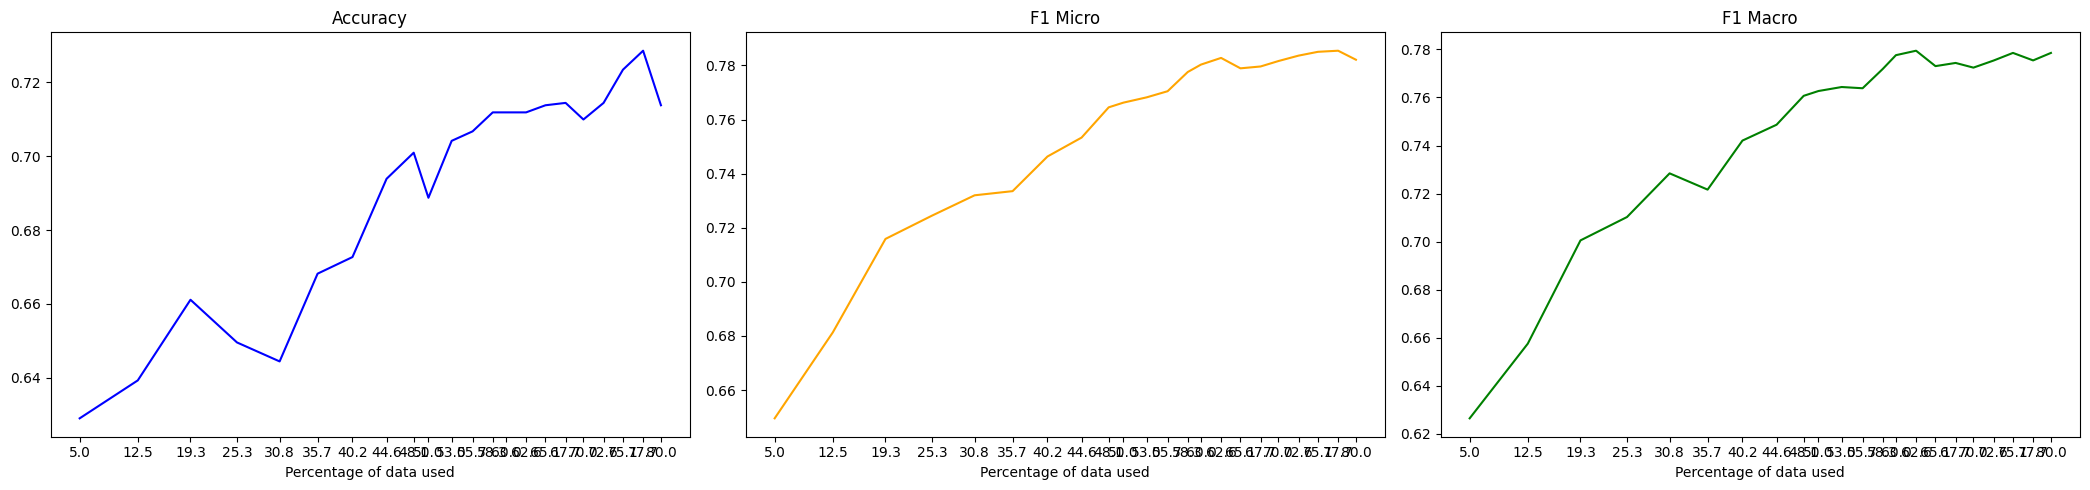

In [ ]:
active_learning(seeds[3], 3)

## RUN 5

TRIAL 5
Random seed: 94


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.458386,0.505466,1.000000,0.080694,0.149337,0.114072
2,No log,0.384749,0.584566,0.914454,0.233786,0.372372,0.251831
3,No log,0.356113,0.571704,0.750000,0.348416,0.475798,0.347973
4,No log,0.330139,0.593569,0.773109,0.416290,0.541176,0.453938
5,No log,0.312512,0.608360,0.758850,0.517345,0.615247,0.548237
6,No log,0.303364,0.628296,0.745247,0.591252,0.659378,0.634356
7,No log,0.297518,0.625080,0.737660,0.608597,0.666942,0.633439
8,No log,0.296958,0.624437,0.752000,0.567119,0.646604,0.609105
9,No log,0.293293,0.627653,0.743662,0.597285,0.662484,0.635006
10,No log,0.293404,0.627653,0.747126,0.588235,0.658228,0.629208


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.83      0.85      0.84       362
                sara       0.72      0.29      0.41       237
         radikalisme       0.72      0.61      0.66       235
pencemaran_nama_baik       0.67      0.59      0.63       492

           micro avg       0.74      0.61      0.67      1326
           macro avg       0.73      0.58      0.63      1326
        weighted avg       0.73      0.61      0.65      1326
         samples avg       0.38      0.35      0.35      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 388: Accuracy: 0.62508038585209, F1 Micro: 0.6669421487603305, F1 Macro: 0.6334393870554681
                      precision    recall  f1-score   support

          pornografi       0.83      0.85      0.84       362
                sara       0.72      0.29      0.41       237
         radikalisme       0.72      0.61      0.66       235
pencemaran_nama_baik       0.67      0.59      0.63       492

           micro avg       0.74      0.61      0.67      1326
           macro avg       0.73      0.58      0.63      1326
        weighted avg       0.73      0.61      0.65      1326
         samples avg       0.38      0.35      0.35      1326



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 3886
Threshold: 26.603021430969243
Samples above threshold: 583
Acquired samples: 583
Sampling duration: 20.864587545394897 seconds
New train size: 971


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.378975,0.558199,0.825521,0.239065,0.370760,0.242515
2,No log,0.325853,0.591640,0.829670,0.341629,0.483974,0.340743
3,No log,0.295100,0.643087,0.734079,0.643288,0.685691,0.671884
4,No log,0.289647,0.621865,0.683920,0.747360,0.714234,0.700222
5,No log,0.283788,0.653376,0.727344,0.702112,0.714505,0.693483
6,No log,0.286634,0.669453,0.750413,0.684766,0.716088,0.700938
7,No log,0.293994,0.661736,0.762697,0.656863,0.705835,0.681453
8,No log,0.297643,0.668167,0.761946,0.661388,0.708115,0.689465
9,0.128600,0.303592,0.664952,0.744939,0.693816,0.718469,0.701903
10,0.128600,0.305558,0.665595,0.760345,0.665158,0.709574,0.685553


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.86      0.88      0.87       362
                sara       0.68      0.49      0.57       237
         radikalisme       0.70      0.67      0.68       235
pencemaran_nama_baik       0.70      0.66      0.68       492

           micro avg       0.74      0.69      0.72      1326
           macro avg       0.74      0.68      0.70      1326
        weighted avg       0.74      0.69      0.71      1326
         samples avg       0.40      0.39      0.38      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 971: Accuracy: 0.6649517684887459, F1 Micro: 0.7184693479109723, F1 Macro: 0.7019032146516351
                      precision    recall  f1-score   support

          pornografi       0.86      0.88      0.87       362
                sara       0.68      0.49      0.57       237
         radikalisme       0.70      0.67      0.68       235
pencemaran_nama_baik       0.70      0.66      0.68       492

           micro avg       0.74      0.69      0.72      1326
           macro avg       0.74      0.68      0.70      1326
        weighted avg       0.74      0.69      0.71      1326
         samples avg       0.40      0.39      0.38      1326



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 3886
Threshold: 24.79934539794922
Samples above threshold: 525
Acquired samples: 525
Sampling duration: 18.705563068389893 seconds
New train size: 1496


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.352474,0.561415,0.801282,0.282805,0.418060,0.281852
2,No log,0.299060,0.627653,0.861199,0.411765,0.557143,0.474100
3,No log,0.268803,0.650161,0.769161,0.643288,0.700616,0.647708
4,No log,0.292332,0.659164,0.843596,0.516591,0.640786,0.572550
5,No log,0.269028,0.672026,0.768007,0.691554,0.727778,0.702153
6,0.129400,0.273564,0.682315,0.756156,0.717949,0.736557,0.720663
7,0.129400,0.288191,0.670740,0.768968,0.680241,0.721889,0.696995
8,0.129400,0.294172,0.673312,0.757353,0.699095,0.727059,0.705667
9,0.129400,0.303783,0.675241,0.767007,0.680241,0.721023,0.696971
10,0.129400,0.302241,0.681672,0.760163,0.705128,0.731612,0.710914


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.92      0.86      0.89       362
                sara       0.63      0.49      0.55       237
         radikalisme       0.73      0.74      0.73       235
pencemaran_nama_baik       0.70      0.71      0.71       492

           micro avg       0.76      0.72      0.74      1326
           macro avg       0.75      0.70      0.72      1326
        weighted avg       0.75      0.72      0.73      1326
         samples avg       0.42      0.41      0.40      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 1496: Accuracy: 0.682315112540193, F1 Micro: 0.7365570599613154, F1 Macro: 0.7206626583745689
                      precision    recall  f1-score   support

          pornografi       0.92      0.86      0.89       362
                sara       0.63      0.49      0.55       237
         radikalisme       0.73      0.74      0.73       235
pencemaran_nama_baik       0.70      0.71      0.71       492

           micro avg       0.76      0.72      0.74      1326
           macro avg       0.75      0.70      0.72      1326
        weighted avg       0.75      0.72      0.73      1326
         samples avg       0.42      0.41      0.40      1326



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 3886
Threshold: 23.189731407165528
Samples above threshold: 473
Acquired samples: 473
Sampling duration: 16.830559015274048 seconds
New train size: 1969


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.351712,0.584566,0.938838,0.231523,0.371446,0.247617
2,No log,0.275260,0.642444,0.821429,0.520362,0.637119,0.560176
3,No log,0.262711,0.674598,0.756779,0.694570,0.724341,0.705491
4,No log,0.264828,0.685531,0.751767,0.721719,0.736437,0.724180
5,0.137600,0.287469,0.668810,0.797310,0.625943,0.701310,0.668039
6,0.137600,0.290559,0.686174,0.760130,0.707391,0.732812,0.717175
7,0.137600,0.310743,0.678457,0.780686,0.652338,0.710764,0.681464
8,0.137600,0.312312,0.686174,0.770213,0.682504,0.723711,0.698729
9,0.045800,0.309013,0.684244,0.760033,0.699849,0.728700,0.710309
10,0.045800,0.310858,0.688746,0.765095,0.697587,0.729783,0.713042


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.92      0.87      0.89       362
                sara       0.63      0.52      0.57       237
         radikalisme       0.75      0.72      0.74       235
pencemaran_nama_baik       0.69      0.71      0.70       492

           micro avg       0.75      0.72      0.74      1326
           macro avg       0.75      0.71      0.72      1326
        weighted avg       0.75      0.72      0.74      1326
         samples avg       0.42      0.42      0.41      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 1969: Accuracy: 0.6855305466237942, F1 Micro: 0.7364370911889188, F1 Macro: 0.7241803335553336
                      precision    recall  f1-score   support

          pornografi       0.92      0.87      0.89       362
                sara       0.63      0.52      0.57       237
         radikalisme       0.75      0.72      0.74       235
pencemaran_nama_baik       0.69      0.71      0.70       492

           micro avg       0.75      0.72      0.74      1326
           macro avg       0.75      0.71      0.72      1326
        weighted avg       0.75      0.72      0.74      1326
         samples avg       0.42      0.42      0.41      1326



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 3886
Threshold: 22.646933746337893
Samples above threshold: 425
Acquired samples: 425
Sampling duration: 15.111121654510498 seconds
New train size: 2394


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.355296,0.578135,0.801923,0.314480,0.451788,0.341604
2,No log,0.269292,0.654019,0.843256,0.523379,0.645882,0.591689
3,No log,0.281708,0.674598,0.820803,0.601056,0.693949,0.659657
4,0.155700,0.261695,0.685531,0.753478,0.735294,0.744275,0.728212
5,0.155700,0.282775,0.686817,0.775000,0.677979,0.723250,0.696288
6,0.155700,0.291721,0.692605,0.742560,0.752640,0.747566,0.740738
7,0.060600,0.294806,0.679743,0.737657,0.754902,0.746180,0.738452
8,0.060600,0.304893,0.682958,0.773032,0.696078,0.732540,0.712060
9,0.060600,0.313142,0.686174,0.763432,0.717949,0.739992,0.721408
10,0.033400,0.317750,0.680386,0.747893,0.736048,0.741923,0.726636


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.94      0.87      0.90       362
                sara       0.59      0.60      0.60       237
         radikalisme       0.71      0.81      0.76       235
pencemaran_nama_baik       0.70      0.72      0.71       492

           micro avg       0.74      0.75      0.75      1326
           macro avg       0.74      0.75      0.74      1326
        weighted avg       0.75      0.75      0.75      1326
         samples avg       0.42      0.43      0.41      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 2394: Accuracy: 0.692604501607717, F1 Micro: 0.7475655430711611, F1 Macro: 0.7407383256979893
                      precision    recall  f1-score   support

          pornografi       0.94      0.87      0.90       362
                sara       0.59      0.60      0.60       237
         radikalisme       0.71      0.81      0.76       235
pencemaran_nama_baik       0.70      0.72      0.71       492

           micro avg       0.74      0.75      0.75      1326
           macro avg       0.74      0.75      0.74      1326
        weighted avg       0.75      0.75      0.75      1326
         samples avg       0.42      0.43      0.41      1326



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 3886
Threshold: 23.581730270385744
Samples above threshold: 383
Acquired samples: 383
Sampling duration: 13.534852504730225 seconds
New train size: 2777


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.307452,0.592926,0.846435,0.349170,0.494394,0.404703
2,No log,0.255652,0.659164,0.801223,0.592760,0.681404,0.634314
3,0.165100,0.250727,0.682958,0.810212,0.634238,0.711506,0.687207
4,0.165100,0.270248,0.681029,0.726368,0.770739,0.747896,0.733500
5,0.165100,0.273686,0.688746,0.787271,0.680995,0.730287,0.714671
6,0.071800,0.301389,0.679743,0.703196,0.812971,0.754110,0.744103
7,0.071800,0.319846,0.668167,0.689113,0.825792,0.751286,0.747141
8,0.071800,0.297737,0.686174,0.745712,0.754148,0.749906,0.735130
9,0.039500,0.310180,0.695177,0.758540,0.736802,0.747513,0.732588
10,0.039500,0.314052,0.686174,0.731237,0.771493,0.750826,0.740664


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.86      0.92      0.89       362
                sara       0.59      0.62      0.60       237
         radikalisme       0.70      0.81      0.75       235
pencemaran_nama_baik       0.65      0.83      0.73       492

           micro avg       0.70      0.81      0.75      1326
           macro avg       0.70      0.79      0.74      1326
        weighted avg       0.71      0.81      0.75      1326
         samples avg       0.46      0.47      0.45      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 2777: Accuracy: 0.6797427652733119, F1 Micro: 0.7541098286114025, F1 Macro: 0.7441028698264844
                      precision    recall  f1-score   support

          pornografi       0.86      0.92      0.89       362
                sara       0.59      0.62      0.60       237
         radikalisme       0.70      0.81      0.75       235
pencemaran_nama_baik       0.65      0.83      0.73       492

           micro avg       0.70      0.81      0.75      1326
           macro avg       0.70      0.79      0.74      1326
        weighted avg       0.71      0.81      0.75      1326
         samples avg       0.46      0.47      0.45      1326



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 3886
Threshold: 22.041595458984375
Samples above threshold: 345
Acquired samples: 345
Sampling duration: 12.391844987869263 seconds
New train size: 3122


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.337693,0.594855,0.894000,0.337104,0.489595,0.396421
2,No log,0.264855,0.668167,0.716075,0.776018,0.744843,0.730915
3,0.179300,0.267459,0.673312,0.705726,0.799397,0.749646,0.738766
4,0.179300,0.266823,0.689389,0.768791,0.709653,0.738039,0.723255
5,0.179300,0.286420,0.679100,0.726579,0.789593,0.756776,0.745037
6,0.085600,0.307254,0.680386,0.716099,0.808446,0.759476,0.753157
7,0.085600,0.300640,0.691318,0.748154,0.763952,0.755970,0.743328
8,0.046700,0.317711,0.688103,0.731175,0.783560,0.756462,0.745790
9,0.046700,0.317852,0.690032,0.743608,0.767722,0.755473,0.744372
10,0.046700,0.325449,0.693248,0.737179,0.780543,0.758242,0.747780


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.93      0.90      0.91       362
                sara       0.62      0.61      0.62       237
         radikalisme       0.71      0.81      0.76       235
pencemaran_nama_baik       0.63      0.84      0.72       492

           micro avg       0.72      0.81      0.76      1326
           macro avg       0.73      0.79      0.75      1326
        weighted avg       0.73      0.81      0.76      1326
         samples avg       0.45      0.46      0.45      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 3122: Accuracy: 0.6803858520900321, F1 Micro: 0.7594757350336521, F1 Macro: 0.7531574538203383
                      precision    recall  f1-score   support

          pornografi       0.93      0.90      0.91       362
                sara       0.62      0.61      0.62       237
         radikalisme       0.71      0.81      0.76       235
pencemaran_nama_baik       0.63      0.84      0.72       492

           micro avg       0.72      0.81      0.76      1326
           macro avg       0.73      0.79      0.75      1326
        weighted avg       0.73      0.81      0.76      1326
         samples avg       0.45      0.46      0.45      1326



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 3886
Threshold: 21.46354389190674
Samples above threshold: 310
Acquired samples: 310
Sampling duration: 11.144921064376831 seconds
New train size: 3432


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.305319,0.583923,0.772464,0.401961,0.528770,0.415425
2,No log,0.261149,0.681672,0.782108,0.665913,0.719348,0.706097
3,0.193700,0.254260,0.700322,0.752600,0.763952,0.758234,0.746675
4,0.193700,0.259355,0.690032,0.740129,0.777526,0.758367,0.749375
5,0.096000,0.285300,0.691318,0.715872,0.826546,0.767238,0.764425
6,0.096000,0.314697,0.682315,0.705031,0.845400,0.768861,0.767707
7,0.055900,0.295251,0.691961,0.750366,0.773002,0.761516,0.752072
8,0.055900,0.318868,0.686817,0.722222,0.813725,0.765248,0.760874
9,0.055900,0.320395,0.697106,0.738279,0.795626,0.765880,0.761684
10,0.036600,0.320747,0.700322,0.740845,0.793363,0.766205,0.760561


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.91      0.90      0.90       362
                sara       0.61      0.71      0.66       237
         radikalisme       0.70      0.89      0.78       235
pencemaran_nama_baik       0.64      0.85      0.73       492

           micro avg       0.71      0.85      0.77      1326
           macro avg       0.71      0.84      0.77      1326
        weighted avg       0.72      0.85      0.77      1326
         samples avg       0.45      0.47      0.45      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 3432: Accuracy: 0.682315112540193, F1 Micro: 0.7688614540466392, F1 Macro: 0.7677069924958002
                      precision    recall  f1-score   support

          pornografi       0.91      0.90      0.90       362
                sara       0.61      0.71      0.66       237
         radikalisme       0.70      0.89      0.78       235
pencemaran_nama_baik       0.64      0.85      0.73       492

           micro avg       0.71      0.85      0.77      1326
           macro avg       0.71      0.84      0.77      1326
        weighted avg       0.72      0.85      0.77      1326
         samples avg       0.45      0.47      0.45      1326



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 3886
Threshold: 20.314455032348633
Samples above threshold: 279
Acquired samples: 279
Sampling duration: 9.942038536071777 seconds
New train size: 3711


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.285125,0.609646,0.830216,0.435143,0.571004,0.488491
2,No log,0.239230,0.699035,0.781276,0.711161,0.744572,0.732297
3,0.206900,0.238312,0.702251,0.783103,0.726998,0.754009,0.740985
4,0.206900,0.270473,0.693891,0.713465,0.843137,0.772900,0.769046
5,0.108400,0.268980,0.701608,0.763514,0.766968,0.765237,0.754862
6,0.108400,0.278441,0.703537,0.752525,0.786576,0.769174,0.761264
7,0.069400,0.299765,0.691318,0.738179,0.788839,0.762669,0.750888
8,0.069400,0.294076,0.705466,0.761481,0.775264,0.768311,0.758948
9,0.043100,0.314721,0.699035,0.745533,0.786576,0.765505,0.754478
10,0.043100,0.316014,0.705466,0.746818,0.796380,0.770803,0.762975


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.92      0.90      0.91       362
                sara       0.60      0.70      0.64       237
         radikalisme       0.71      0.87      0.78       235
pencemaran_nama_baik       0.65      0.86      0.74       492

           micro avg       0.71      0.84      0.77      1326
           macro avg       0.72      0.83      0.77      1326
        weighted avg       0.73      0.84      0.78      1326
         samples avg       0.46      0.48      0.46      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 3711: Accuracy: 0.6938906752411576, F1 Micro: 0.7729001036985828, F1 Macro: 0.7690459303281029
                      precision    recall  f1-score   support

          pornografi       0.92      0.90      0.91       362
                sara       0.60      0.70      0.64       237
         radikalisme       0.71      0.87      0.78       235
pencemaran_nama_baik       0.65      0.86      0.74       492

           micro avg       0.71      0.84      0.77      1326
           macro avg       0.72      0.83      0.77      1326
        weighted avg       0.73      0.84      0.78      1326
         samples avg       0.46      0.48      0.46      1326



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 3886
Threshold: 20.01470375061035
Samples above threshold: 251
Acquired samples: 175
Sampling duration: 9.129427671432495 seconds
New train size: 3886


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.286603,0.609646,0.826399,0.434389,0.569451,0.475345
2,No log,0.245838,0.685531,0.726018,0.793363,0.758198,0.747459
3,0.216700,0.235923,0.715113,0.774713,0.762443,0.768529,0.762701
4,0.216700,0.262805,0.693891,0.723702,0.819759,0.768741,0.767772
5,0.115900,0.295531,0.697749,0.708701,0.847662,0.771978,0.770998
6,0.115900,0.299922,0.689389,0.724917,0.822775,0.770752,0.764950
7,0.071900,0.308216,0.695177,0.732606,0.809955,0.769341,0.766846
8,0.071900,0.310254,0.690675,0.745985,0.770739,0.758160,0.747866
9,0.045900,0.326400,0.690032,0.732267,0.794118,0.761939,0.755129
10,0.045900,0.323881,0.695177,0.743790,0.790347,0.766362,0.760711


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.94      0.89      0.91       362
                sara       0.58      0.79      0.67       237
         radikalisme       0.67      0.87      0.76       235
pencemaran_nama_baik       0.66      0.84      0.74       492

           micro avg       0.71      0.85      0.77      1326
           macro avg       0.72      0.85      0.77      1326
        weighted avg       0.73      0.85      0.78      1326
         samples avg       0.45      0.47      0.45      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 3886: Accuracy: 0.6977491961414791, F1 Micro: 0.7719780219780219, F1 Macro: 0.77099829712646
                      precision    recall  f1-score   support

          pornografi       0.94      0.89      0.91       362
                sara       0.58      0.79      0.67       237
         radikalisme       0.67      0.87      0.76       235
pencemaran_nama_baik       0.66      0.84      0.74       492

           micro avg       0.71      0.85      0.77      1326
           macro avg       0.72      0.85      0.77      1326
        weighted avg       0.73      0.85      0.78      1326
         samples avg       0.45      0.47      0.45      1326



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 4663
Threshold: 20.29145755767822
Samples above threshold: 234
Acquired samples: 234
Sampling duration: 8.337588548660278 seconds
New train size: 4120


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.264519,0.659807,0.805815,0.585219,0.678025,0.611635
2,0.213900,0.241520,0.695820,0.786318,0.702112,0.741833,0.715342
3,0.213900,0.249462,0.695820,0.742165,0.785822,0.763370,0.751997
4,0.120500,0.257680,0.696463,0.757463,0.765460,0.761440,0.749966
5,0.120500,0.284970,0.700965,0.735913,0.817496,0.774562,0.768385
6,0.074900,0.292320,0.697749,0.734948,0.800905,0.766510,0.760848
7,0.074900,0.309123,0.706752,0.745931,0.794872,0.769624,0.762022
8,0.051400,0.320262,0.700965,0.748212,0.788839,0.767988,0.761926
9,0.051400,0.327361,0.706109,0.751601,0.796380,0.773343,0.766668
10,0.035700,0.330687,0.702251,0.745954,0.799397,0.771751,0.766347


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.95      0.88      0.91       362
                sara       0.64      0.65      0.64       237
         radikalisme       0.72      0.83      0.77       235
pencemaran_nama_baik       0.67      0.85      0.75       492

           micro avg       0.74      0.82      0.77      1326
           macro avg       0.74      0.80      0.77      1326
        weighted avg       0.75      0.82      0.78      1326
         samples avg       0.46      0.47      0.45      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 4120: Accuracy: 0.7009646302250804, F1 Micro: 0.7745623436941764, F1 Macro: 0.7683852899703885
                      precision    recall  f1-score   support

          pornografi       0.95      0.88      0.91       362
                sara       0.64      0.65      0.64       237
         radikalisme       0.72      0.83      0.77       235
pencemaran_nama_baik       0.67      0.85      0.75       492

           micro avg       0.74      0.82      0.77      1326
           macro avg       0.74      0.80      0.77      1326
        weighted avg       0.75      0.82      0.78      1326
         samples avg       0.46      0.47      0.45      1326



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 4663
Threshold: 19.321107864379883
Samples above threshold: 210
Acquired samples: 210
Sampling duration: 7.643132925033569 seconds
New train size: 4330


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.268761,0.676527,0.719606,0.772247,0.744998,0.729980
2,0.225800,0.240383,0.700322,0.806540,0.669683,0.731768,0.711346
3,0.225800,0.234919,0.706109,0.769641,0.760935,0.765264,0.751175
4,0.131600,0.248648,0.708039,0.753034,0.795626,0.773744,0.766487
5,0.131600,0.269104,0.715113,0.740260,0.816742,0.776622,0.774436
6,0.085500,0.297242,0.705466,0.729694,0.826546,0.775106,0.772171
7,0.085500,0.300860,0.706109,0.741777,0.799397,0.769510,0.764943
8,0.056900,0.301053,0.708039,0.768171,0.757164,0.762628,0.750927
9,0.056900,0.332804,0.694534,0.724850,0.820513,0.769721,0.767388
10,0.042800,0.327818,0.702251,0.738832,0.810709,0.773103,0.769744


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.97      0.88      0.92       362
                sara       0.61      0.73      0.67       237
         radikalisme       0.70      0.85      0.77       235
pencemaran_nama_baik       0.69      0.79      0.74       492

           micro avg       0.74      0.82      0.78      1326
           macro avg       0.74      0.81      0.77      1326
        weighted avg       0.75      0.82      0.78      1326
         samples avg       0.45      0.46      0.45      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 4330: Accuracy: 0.715112540192926, F1 Micro: 0.7766224453209034, F1 Macro: 0.7744361270470002
                      precision    recall  f1-score   support

          pornografi       0.97      0.88      0.92       362
                sara       0.61      0.73      0.67       237
         radikalisme       0.70      0.85      0.77       235
pencemaran_nama_baik       0.69      0.79      0.74       492

           micro avg       0.74      0.82      0.78      1326
           macro avg       0.74      0.81      0.77      1326
        weighted avg       0.75      0.82      0.78      1326
         samples avg       0.45      0.46      0.45      1326



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 4663
Threshold: 19.567958641052247
Samples above threshold: 189
Acquired samples: 200
Sampling duration: 6.9065821170806885 seconds
New train size: 4530


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.274823,0.652733,0.859813,0.485671,0.620723,0.549437
2,0.233700,0.246532,0.691318,0.794826,0.671946,0.728239,0.720465
3,0.233700,0.247496,0.706109,0.761406,0.767722,0.764551,0.752347
4,0.138500,0.254469,0.704823,0.732974,0.819759,0.773941,0.768889
5,0.138500,0.278006,0.709968,0.735532,0.824284,0.777383,0.768169
6,0.094500,0.289884,0.714469,0.743802,0.814480,0.777538,0.770747
7,0.094500,0.294640,0.713826,0.748081,0.808446,0.777093,0.772083
8,0.060900,0.308721,0.709968,0.747546,0.803922,0.774709,0.768192
9,0.044700,0.316271,0.714469,0.754436,0.801659,0.777331,0.770201
10,0.044700,0.329123,0.708039,0.735913,0.817496,0.774562,0.768757


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.92      0.91      0.91       362
                sara       0.61      0.68      0.65       237
         radikalisme       0.72      0.84      0.78       235
pencemaran_nama_baik       0.71      0.80      0.75       492

           micro avg       0.74      0.81      0.78      1326
           macro avg       0.74      0.81      0.77      1326
        weighted avg       0.75      0.81      0.78      1326
         samples avg       0.45      0.46      0.45      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 4530: Accuracy: 0.7144694533762058, F1 Micro: 0.7775377969762418, F1 Macro: 0.7707473424541633
                      precision    recall  f1-score   support

          pornografi       0.92      0.91      0.91       362
                sara       0.61      0.68      0.65       237
         radikalisme       0.72      0.84      0.78       235
pencemaran_nama_baik       0.71      0.80      0.75       492

           micro avg       0.74      0.81      0.78      1326
           macro avg       0.74      0.81      0.77      1326
        weighted avg       0.75      0.81      0.78      1326
         samples avg       0.45      0.46      0.45      1326



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 4663
Threshold: 20.46924934387207
Samples above threshold: 169
Acquired samples: 133
Sampling duration: 6.4248480796813965 seconds
New train size: 4663


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.254902,0.661093,0.750399,0.709653,0.729457,0.687002
2,0.240100,0.231787,0.712540,0.769231,0.769231,0.769231,0.763052
3,0.240100,0.234690,0.718971,0.763939,0.795626,0.779461,0.770527
4,0.143900,0.250465,0.711897,0.751758,0.806184,0.778020,0.769483
5,0.143900,0.274256,0.719614,0.738095,0.841629,0.786469,0.782159
6,0.096100,0.287708,0.713826,0.737903,0.828054,0.780384,0.773959
7,0.067200,0.298087,0.711254,0.740816,0.821267,0.778970,0.772735
8,0.067200,0.314402,0.709968,0.739013,0.824284,0.779323,0.773553
9,0.047300,0.330954,0.707395,0.724789,0.840121,0.778205,0.775169
10,0.047300,0.316940,0.717685,0.757184,0.794872,0.775570,0.766414


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.94      0.91      0.92       362
                sara       0.63      0.72      0.67       237
         radikalisme       0.71      0.87      0.78       235
pencemaran_nama_baik       0.68      0.84      0.75       492

           micro avg       0.74      0.84      0.79      1326
           macro avg       0.74      0.83      0.78      1326
        weighted avg       0.75      0.84      0.79      1326
         samples avg       0.46      0.48      0.46      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 4663: Accuracy: 0.7196141479099678, F1 Micro: 0.7864693446088794, F1 Macro: 0.7821589511843442
                      precision    recall  f1-score   support

          pornografi       0.94      0.91      0.92       362
                sara       0.63      0.72      0.67       237
         radikalisme       0.71      0.87      0.78       235
pencemaran_nama_baik       0.68      0.84      0.75       492

           micro avg       0.74      0.84      0.79      1326
           macro avg       0.74      0.83      0.78      1326
        weighted avg       0.75      0.84      0.79      1326
         samples avg       0.46      0.48      0.46      1326



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 5441
Threshold: 19.54924774169922
Samples above threshold: 156
Acquired samples: 200
Sampling duration: 5.757965087890625 seconds
New train size: 4863


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.248303,0.691318,0.778154,0.693062,0.733147,0.720832
2,0.246500,0.231357,0.708039,0.762787,0.776018,0.769346,0.751530
3,0.246500,0.236339,0.715113,0.761216,0.793363,0.776957,0.770073
4,0.151000,0.265279,0.708039,0.722861,0.853695,0.782849,0.778199
5,0.108100,0.272458,0.712540,0.747426,0.821267,0.782609,0.780182
6,0.108100,0.290981,0.707395,0.741379,0.810709,0.774496,0.766828
7,0.071100,0.307998,0.712540,0.743572,0.828808,0.783880,0.777822
8,0.071100,0.315748,0.711897,0.743537,0.824284,0.781831,0.774200
9,0.054200,0.320503,0.711254,0.742818,0.819005,0.779053,0.771143
10,0.042300,0.321487,0.711897,0.746905,0.819005,0.781295,0.775329


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.94      0.91      0.92       362
                sara       0.64      0.69      0.67       237
         radikalisme       0.71      0.83      0.77       235
pencemaran_nama_baik       0.69      0.84      0.75       492

           micro avg       0.74      0.83      0.78      1326
           macro avg       0.75      0.82      0.78      1326
        weighted avg       0.75      0.83      0.79      1326
         samples avg       0.47      0.47      0.46      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 4863: Accuracy: 0.712540192926045, F1 Micro: 0.7838801711840228, F1 Macro: 0.7778219395544442
                      precision    recall  f1-score   support

          pornografi       0.94      0.91      0.92       362
                sara       0.64      0.69      0.67       237
         radikalisme       0.71      0.83      0.77       235
pencemaran_nama_baik       0.69      0.84      0.75       492

           micro avg       0.74      0.83      0.78      1326
           macro avg       0.75      0.82      0.78      1326
        weighted avg       0.75      0.83      0.79      1326
         samples avg       0.47      0.47      0.46      1326



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 5441
Threshold: 19.358652114868164
Samples above threshold: 136
Acquired samples: 200
Sampling duration: 5.02797532081604 seconds
New train size: 5063


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.244462,0.695820,0.775244,0.717949,0.745497,0.728590
2,0.252500,0.232953,0.710611,0.748775,0.806938,0.776770,0.768871
3,0.252500,0.239255,0.697106,0.745324,0.781297,0.762887,0.755874
4,0.161000,0.244595,0.720900,0.763494,0.810709,0.786394,0.776540
5,0.113300,0.269883,0.713826,0.734448,0.828054,0.778447,0.771373
6,0.113300,0.284140,0.711254,0.742916,0.810709,0.775334,0.766490
7,0.079300,0.291468,0.720257,0.764020,0.791101,0.777325,0.768746
8,0.058400,0.308282,0.720257,0.754411,0.806184,0.779439,0.773012
9,0.058400,0.326500,0.711254,0.738079,0.828808,0.780817,0.775317
10,0.045300,0.321538,0.720257,0.750870,0.813725,0.781035,0.774717


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.93      0.91      0.92       362
                sara       0.67      0.64      0.65       237
         radikalisme       0.73      0.82      0.77       235
pencemaran_nama_baik       0.71      0.82      0.76       492

           micro avg       0.76      0.81      0.79      1326
           macro avg       0.76      0.80      0.78      1326
        weighted avg       0.77      0.81      0.79      1326
         samples avg       0.46      0.46      0.45      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 5063: Accuracy: 0.7209003215434083, F1 Micro: 0.7863935625457206, F1 Macro: 0.776540471074806
                      precision    recall  f1-score   support

          pornografi       0.93      0.91      0.92       362
                sara       0.67      0.64      0.65       237
         radikalisme       0.73      0.82      0.77       235
pencemaran_nama_baik       0.71      0.82      0.76       492

           micro avg       0.76      0.81      0.79      1326
           macro avg       0.76      0.80      0.78      1326
        weighted avg       0.77      0.81      0.79      1326
         samples avg       0.46      0.46      0.45      1326



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 5441
Threshold: 18.079985427856446
Samples above threshold: 116
Acquired samples: 200
Sampling duration: 4.244022369384766 seconds
New train size: 5263


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.249045,0.672669,0.834208,0.599548,0.697674,0.657607
2,0.262600,0.232443,0.706752,0.752475,0.802413,0.776642,0.768524
3,0.262600,0.221977,0.720900,0.793130,0.766214,0.779440,0.770040
4,0.172000,0.241721,0.715113,0.781155,0.775264,0.778198,0.771595
5,0.120800,0.256209,0.717685,0.752606,0.816742,0.783363,0.774875
6,0.120800,0.275725,0.715756,0.754533,0.815988,0.784058,0.779582
7,0.087700,0.304416,0.711897,0.741604,0.815988,0.777020,0.767999
8,0.064400,0.306134,0.714469,0.753357,0.803922,0.777818,0.769796
9,0.064400,0.321798,0.713183,0.743032,0.824284,0.781552,0.776348
10,0.050000,0.317718,0.713826,0.751943,0.802413,0.776359,0.767535


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.97      0.89      0.93       362
                sara       0.59      0.73      0.66       237
         radikalisme       0.73      0.84      0.78       235
pencemaran_nama_baik       0.72      0.79      0.76       492

           micro avg       0.75      0.82      0.78      1326
           macro avg       0.75      0.81      0.78      1326
        weighted avg       0.77      0.82      0.79      1326
         samples avg       0.46      0.47      0.45      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 5263: Accuracy: 0.7157556270096463, F1 Micro: 0.7840579710144927, F1 Macro: 0.7795816574804101
                      precision    recall  f1-score   support

          pornografi       0.97      0.89      0.93       362
                sara       0.59      0.73      0.66       237
         radikalisme       0.73      0.84      0.78       235
pencemaran_nama_baik       0.72      0.79      0.76       492

           micro avg       0.75      0.82      0.78      1326
           macro avg       0.75      0.81      0.78      1326
        weighted avg       0.77      0.82      0.79      1326
         samples avg       0.46      0.47      0.45      1326



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 5441
Threshold: 18.77902641296387
Samples above threshold: 96
Acquired samples: 178
Sampling duration: 3.7901928424835205 seconds
New train size: 5441


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.242958,0.686817,0.802752,0.659879,0.724338,0.705162
2,0.269800,0.228862,0.715113,0.787589,0.746606,0.766551,0.759787
3,0.178500,0.231656,0.718971,0.808848,0.730769,0.767829,0.752131
4,0.178500,0.233883,0.710611,0.779739,0.766214,0.772917,0.758262
5,0.128600,0.260243,0.709968,0.745480,0.808446,0.775687,0.769937
6,0.096600,0.275790,0.713826,0.749826,0.813725,0.780470,0.774318
7,0.096600,0.291721,0.711254,0.752999,0.804676,0.777980,0.770714
8,0.070900,0.311988,0.706109,0.738095,0.818250,0.776109,0.770262
9,0.052200,0.315659,0.709968,0.748782,0.811463,0.778864,0.771582
10,0.052200,0.317291,0.709968,0.751938,0.804676,0.777413,0.771064


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.93      0.92      0.92       362
                sara       0.63      0.67      0.65       237
         radikalisme       0.74      0.82      0.78       235
pencemaran_nama_baik       0.69      0.80      0.74       492

           micro avg       0.75      0.81      0.78      1326
           macro avg       0.75      0.80      0.77      1326
        weighted avg       0.75      0.81      0.78      1326
         samples avg       0.46      0.47      0.45      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 5441: Accuracy: 0.7138263665594855, F1 Micro: 0.7804701627486437, F1 Macro: 0.7743178059013909
                      precision    recall  f1-score   support

          pornografi       0.93      0.92      0.92       362
                sara       0.63      0.67      0.65       237
         radikalisme       0.74      0.82      0.78       235
pencemaran_nama_baik       0.69      0.80      0.74       492

           micro avg       0.75      0.81      0.78      1326
           macro avg       0.75      0.80      0.77      1326
        weighted avg       0.75      0.81      0.78      1326
         samples avg       0.46      0.47      0.45      1326



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 6218
Threshold: 17.678473663330077
Samples above threshold: 78
Acquired samples: 200
Sampling duration: 3.0581915378570557 seconds
New train size: 5641


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.254129,0.689389,0.819980,0.625189,0.709457,0.686683
2,0.277200,0.235269,0.720257,0.751226,0.808446,0.778787,0.774449
3,0.181100,0.231993,0.724116,0.760200,0.800905,0.780022,0.772011
4,0.181100,0.235933,0.723473,0.770241,0.796380,0.783092,0.775767
5,0.137600,0.246629,0.724116,0.794304,0.757164,0.775290,0.767010
6,0.104300,0.268305,0.728617,0.791894,0.766214,0.778842,0.768675
7,0.104300,0.292269,0.709968,0.740163,0.822775,0.779286,0.774837
8,0.075400,0.302072,0.713183,0.748257,0.809201,0.777536,0.770605
9,0.057500,0.302960,0.715756,0.755977,0.810709,0.782387,0.777351
10,0.051300,0.310391,0.715113,0.753695,0.807692,0.779760,0.773500


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.95      0.90      0.92       362
                sara       0.62      0.69      0.65       237
         radikalisme       0.73      0.83      0.77       235
pencemaran_nama_baik       0.75      0.76      0.76       492

           micro avg       0.77      0.80      0.78      1326
           macro avg       0.76      0.79      0.78      1326
        weighted avg       0.78      0.80      0.79      1326
         samples avg       0.46      0.45      0.45      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 5641: Accuracy: 0.7234726688102894, F1 Micro: 0.7830923248053392, F1 Macro: 0.7757672202082376
                      precision    recall  f1-score   support

          pornografi       0.95      0.90      0.92       362
                sara       0.62      0.69      0.65       237
         radikalisme       0.73      0.83      0.77       235
pencemaran_nama_baik       0.75      0.76      0.76       492

           micro avg       0.77      0.80      0.78      1326
           macro avg       0.76      0.79      0.78      1326
        weighted avg       0.78      0.80      0.79      1326
         samples avg       0.46      0.45      0.45      1326



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 6218
Threshold: 17.052099990844727
Samples above threshold: 58
Acquired samples: 200
Sampling duration: 2.3230693340301514 seconds
New train size: 5841


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.245765,0.693891,0.739286,0.780543,0.759354,0.749230
2,0.279300,0.228293,0.712540,0.802542,0.714178,0.755786,0.746769
3,0.188100,0.227777,0.717685,0.787500,0.760181,0.773599,0.757977
4,0.188100,0.231627,0.715113,0.765387,0.797134,0.780938,0.772943
5,0.145400,0.255073,0.716399,0.760000,0.788084,0.773787,0.765860
6,0.104400,0.285242,0.707395,0.732707,0.822775,0.775133,0.770365
7,0.082900,0.291476,0.711254,0.750533,0.796380,0.772777,0.766486
8,0.082900,0.296889,0.711897,0.758922,0.785822,0.772138,0.764236
9,0.064000,0.313983,0.717685,0.755524,0.799397,0.776841,0.769367
10,0.048600,0.314133,0.711897,0.755764,0.791101,0.773029,0.766669


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.93      0.90      0.92       362
                sara       0.62      0.67      0.64       237
         radikalisme       0.74      0.82      0.78       235
pencemaran_nama_baik       0.74      0.77      0.75       492

           micro avg       0.77      0.80      0.78      1326
           macro avg       0.76      0.79      0.77      1326
        weighted avg       0.77      0.80      0.78      1326
         samples avg       0.46      0.46      0.45      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 5841: Accuracy: 0.715112540192926, F1 Micro: 0.7809383080901368, F1 Macro: 0.7729432484022782
                      precision    recall  f1-score   support

          pornografi       0.93      0.90      0.92       362
                sara       0.62      0.67      0.64       237
         radikalisme       0.74      0.82      0.78       235
pencemaran_nama_baik       0.74      0.77      0.75       492

           micro avg       0.77      0.80      0.78      1326
           macro avg       0.76      0.79      0.77      1326
        weighted avg       0.77      0.80      0.78      1326
         samples avg       0.46      0.46      0.45      1326



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 6218
Threshold: 15.9430570602417
Samples above threshold: 38
Acquired samples: 200
Sampling duration: 1.6040830612182617 seconds
New train size: 6041


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.241220,0.706752,0.793451,0.712670,0.750894,0.745173
2,0.286800,0.222238,0.718971,0.800987,0.734540,0.766326,0.752811
3,0.191300,0.221446,0.724116,0.766858,0.806184,0.786029,0.776456
4,0.151000,0.235832,0.726688,0.793184,0.772247,0.782575,0.774609
5,0.151000,0.263562,0.731190,0.752710,0.837858,0.793005,0.788364
6,0.111400,0.262224,0.718971,0.772727,0.794872,0.783643,0.777714
7,0.085000,0.274147,0.718328,0.779456,0.778281,0.778868,0.772430
8,0.065500,0.301894,0.717685,0.750172,0.822021,0.784455,0.780527
9,0.065500,0.304071,0.716399,0.764748,0.801659,0.782769,0.778168
10,0.052800,0.311327,0.717685,0.763480,0.800905,0.781745,0.776145


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.93      0.91      0.92       362
                sara       0.62      0.74      0.68       237
         radikalisme       0.74      0.85      0.79       235
pencemaran_nama_baik       0.71      0.82      0.76       492

           micro avg       0.75      0.84      0.79      1326
           macro avg       0.75      0.83      0.79      1326
        weighted avg       0.76      0.84      0.80      1326
         samples avg       0.47      0.48      0.46      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 6041: Accuracy: 0.7311897106109325, F1 Micro: 0.7930049964311205, F1 Macro: 0.78836435871646
                      precision    recall  f1-score   support

          pornografi       0.93      0.91      0.92       362
                sara       0.62      0.74      0.68       237
         radikalisme       0.74      0.85      0.79       235
pencemaran_nama_baik       0.71      0.82      0.76       492

           micro avg       0.75      0.84      0.79      1326
           macro avg       0.75      0.83      0.79      1326
        weighted avg       0.76      0.84      0.80      1326
         samples avg       0.47      0.48      0.46      1326



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Nearest checkpoint: 6218
Threshold: 14.581657409667969
Samples above threshold: 18
Acquired samples: 177
Sampling duration: 1.1257624626159668 seconds
New train size: 6218


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Micro,F1 Macro
1,No log,0.239204,0.702894,0.756024,0.757164,0.756594,0.746679
2,0.296100,0.221539,0.713826,0.786400,0.741327,0.763199,0.753022
3,0.200200,0.236429,0.707395,0.738160,0.822775,0.778174,0.771569
4,0.159700,0.238722,0.717685,0.787666,0.760935,0.774070,0.760082
5,0.159700,0.245433,0.724116,0.776453,0.785822,0.781109,0.771466
6,0.120400,0.270487,0.717042,0.761803,0.803167,0.781938,0.773271
7,0.089400,0.275160,0.718971,0.769062,0.791101,0.779926,0.772661
8,0.074200,0.294963,0.716399,0.771956,0.788839,0.780306,0.769489
9,0.059900,0.305569,0.717042,0.764281,0.797134,0.780362,0.772545
10,0.059900,0.306267,0.722830,0.767844,0.803167,0.785109,0.778222


Trainer is attempting to log a value of "                      precision    recall  f1-score   support

          pornografi       0.93      0.92      0.92       362
                sara       0.64      0.67      0.65       237
         radikalisme       0.75      0.83      0.79       235
pencemaran_nama_baik       0.73      0.77      0.75       492

           micro avg       0.77      0.80      0.79      1326
           macro avg       0.76      0.80      0.78      1326
        weighted avg       0.77      0.80      0.79      1326
         samples avg       0.46      0.46      0.45      1326
" of type <class 'str'> for key "eval/report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Iteration 6218: Accuracy: 0.7228295819935692, F1 Micro: 0.7851087357169186, F1 Macro: 0.7782218911931085
                      precision    recall  f1-score   support

          pornografi       0.93      0.92      0.92       362
                sara       0.64      0.67      0.65       237
         radikalisme       0.75      0.83      0.79       235
pencemaran_nama_baik       0.73      0.77      0.75       492

           micro avg       0.77      0.80      0.79      1326
           macro avg       0.76      0.80      0.78      1326
        weighted avg       0.77      0.80      0.79      1326
         samples avg       0.46      0.46      0.45      1326

Total sampling time: 183.9 seconds
Total runtime: 11669.858672380447 seconds


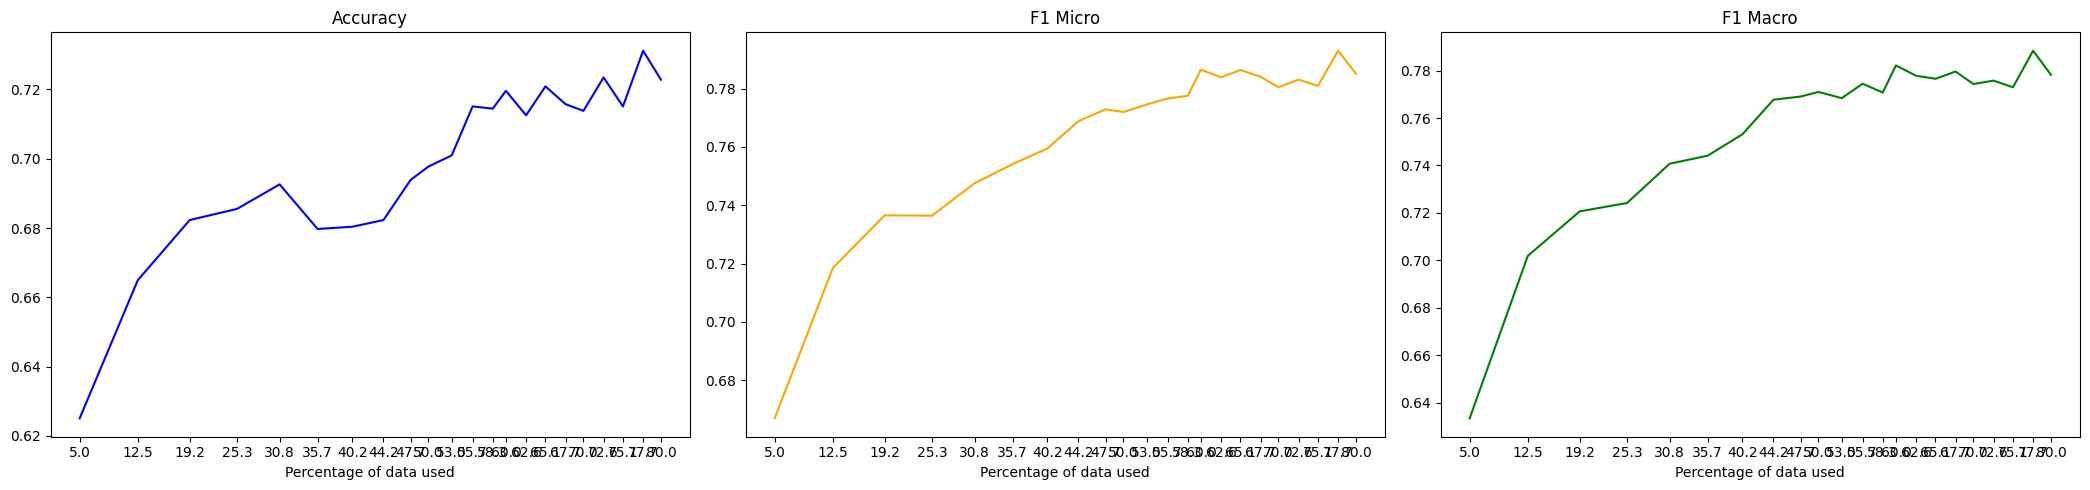

In [ ]:
active_learning(seeds[4], 4)